In [1]:
!pip install dtreeviz
!pip install kneed
!pip install pyclustertend
!pip install geopandas

import pandas as pd
import numpy as np
import geopandas as gp
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from pyclustertend import hopkins
from yellowbrick.cluster import SilhouetteVisualizer

#Visualización
from seaborn import color_palette
import matplotlib.pyplot as plt
import seaborn as sns
import dtreeviz.trees as dtreeviz

#modelos y métricas
from sklearn import tree, metrics
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split,RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, recall_score, accuracy_score,f1_score, precision_score, auc, roc_auc_score, mean_squared_error, silhouette_score, classification_report
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    plot_roc_curve,
    roc_auc_score,
    confusion_matrix,
)
import statistics
from sklearn.metrics import mean_absolute_error, mean_squared_error, max_error, median_absolute_error, r2_score, explained_variance_score


#preprocesamiento
from sklearn.preprocessing import MinMaxScaler, StandardScaler

#configuración warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

#Importacion arboles
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier

# Pickle
import pickle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 72 kB 308 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 18.0 MB/s 
     |████████████████████████████████| 16.7 MB 58.6 MB/s 
     |████████████████████████████████| 6.3 MB 67.8 MB/s 


In [2]:
def plot_confusion_matrix(y_true, y_pred):
    names = sorted(set(y_true))
    cm = confusion_matrix(y_true, y_pred, labels=names)
    df_cm = pd.DataFrame(cm, names, names)

    plt.figure(dpi=100)
    plt.title("Matriz de confusion")
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g', square=True)
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()


def report(model, x_train, y_train, x_test, y_test):
    # Get a prediction over x_test
    prediction = model.predict(x_test)
    
    # Calculate various precision and accuracy score
    score = model.score(x_test, y_test)
    cv_score = cross_val_score(model, x_train, y_train, cv=5)
    accuracy = accuracy_score(y_test, prediction)
    precision = precision_score(y_test, prediction)
    recall = recall_score(y_test, prediction)
    f1 = f1_score(y_test, prediction)

    # Print all scores
    print(f"El score general del modelo es {score}")
    print(
        f"La media del cross validation score con k=5 es {statistics.median(cv_score)}"
    )
    print(f"El accuracy del modelo es {accuracy}")
    print(f"La precision del modelo es {precision}")
    print(f"El recall del modelo es {recall}")
    print(f"El f1 del modelo es {f1}")

    # Steal the confusion matrix that Jorge wrote
    plot_confusion_matrix(y_test, prediction)

    # Plot the roc curve using sklearn
    plot_roc_curve(model, x_test, y_test)
    plt.show()

def report_regression(model, x_train, y_train, x_test, y_test):
    # Get a prediction over x_test
    y_pred = model.predict(x_test)
    
    error = y_test - y_pred
    percentil = [25,50,75]
    percentil_value = np.percentile(error, percentil)
    
    metrics = [
        ('mean absolute error', mean_absolute_error(y_test, y_pred)),
        ('median absolute error', median_absolute_error(y_test, y_pred)),
        ('mean squared error', mean_squared_error(y_test, y_pred)),
        ('max error', max_error(y_test, y_pred)),
        ('r2 score', r2_score(y_test, y_pred)),
        ('explained variance score', explained_variance_score(y_test, y_pred))
    ]
    
    print('Metricas for regression:')
    for metric_name, metric_value in metrics:
        print(f'{metric_name:>25s}: {metric_value: >20.3f}')
        
    print('\nPercentiles:')
    for p, pv in zip(percentil, percentil_value):
        print(f'{p: 25d}: {pv:>20.3f}')

    # Calculate various precision and accuracy score
    score = model.score(x_test, y_test)
    cv_score = cross_val_score(model, x_train, y_train, cv=5)


    # Print all scores
    print(f"El score general del modelo es {score}")
    print(
        f"La media del cross validation score con k=5 es {statistics.median(cv_score)}"
    )

# Prestardo de
def regression_roc_auc_score(y_true, y_pred, num_rounds = 10000):
  """
  Computes Regression-ROC-AUC-score.
  
  Parameters:
  ----------
  y_true: array-like of shape (n_samples,). Binary or continuous target variable.
  y_pred: array-like of shape (n_samples,). Target scores.
  num_rounds: int or string. If integer, number of random pairs of observations. 
              If string, 'exact', all possible pairs of observations will be evaluated.
  
  Returns:
  -------
  rroc: float. Regression-ROC-AUC-score.
  """
  
  import numpy as np
    
  y_true = np.array(y_true)
  y_pred = np.array(y_pred)

  num_pairs = 0
  num_same_sign = 0
  
  for i, j in _yield_pairs(y_true, num_rounds):
    diff_true = y_true[i] - y_true[j]
    diff_score = y_pred[i] - y_pred[j]
    if diff_true * diff_score > 0:
      num_same_sign += 1
    elif diff_score == 0:
      num_same_sign += .5
    num_pairs += 1
      
  return num_same_sign / num_pairs


def _yield_pairs(y_true, num_rounds):
  """
  Returns pairs of valid indices. Indices must belong to observations having different values.
  
  Parameters:
  ----------
  y_true: array-like of shape (n_samples,). Binary or continuous target variable.
  num_rounds: int or string. If integer, number of random pairs of observations to return. 
              If string, 'exact', all possible pairs of observations will be returned.
  
  Yields:
  -------
  i, j: tuple of int of shape (2,). Indices referred to a pair of samples.
  
  """
  import numpy as np
  
  if num_rounds == 'exact':
    for i in range(len(y_true)):
      for j in np.where((y_true != y_true[i]) & (np.arange(len(y_true)) > i))[0]:
        yield i, j     
  else:
    for r in range(num_rounds):
      i = np.random.choice(range(len(y_true)))
      j = np.random.choice(np.where(y_true != y_true[i])[0])
      yield i, j

In [3]:
# Importamos el DS
url = 'https://drive.google.com/file/d/1pjD0WMUmUzX871xIXfkqqAEEi17C87rd/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]

ds_propiedades = pd.read_csv(path)

# **1. Análisis Exploratorio y Preprocesamiento de Datos**

##Selección de datos

Seleccionamos las propiedades que estan en Capital Federal, donde la operacion es venta, la moneda es dolares.

In [4]:
# Obtenemos las propiedades que estan en Capital Federal
propiedades_caba = ds_propiedades.loc[ds_propiedades.place_l2.str.contains('Capital Federal')]

# Nos quedamos con las propiedades que tienen su precio en dolares y cuyo tipo de opreación sea venta.
propiedades_usd_venta = propiedades_caba.loc[propiedades_caba.property_currency.str.contains('USD', na=False) & propiedades_caba.operation.str.contains('Venta')]

# Finalmente el data set con el que trabajamos solo tiene los tipo de vivienda Casa, PH y Departamento.
ds_propiedades = propiedades_usd_venta.loc[(propiedades_usd_venta.property_type.str.contains('Casa|PH|Departamento', regex=True))] 

ds_propiedades.rename(columns = {'place_l3':'barrio'}, inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [5]:
#Separamos conjunto de Train y de Test (80/20)
ds_trabajo_train, ds_trabajo_test = train_test_split(ds_propiedades, test_size=0.20, random_state=0)

##Exploracion inicial

In [6]:
ds_propiedades.head(10)

id  start_date    end_date  created_on    latitud  \
25  CyZu6IaZgmQYGk8jmPajCg==  2021-09-09  2021-09-26  2021-09-09        NaN   
42  d3Z0MblSb2IMBoOBMGJEEQ==  2021-09-09  2021-09-26  2021-09-09 -34.637319   
43  rL7qPkQnomsMGu2ViS3sBw==  2021-09-09  2021-09-28  2021-09-09 -34.628647   
49  vuX/ccLAMVml4qWRFcOJUA==  2021-09-09  2022-01-05  2021-09-09 -34.610027   
51  ZTtSCeqZ3HUgf5jjwEzRcw==  2021-09-09  2022-03-09  2021-09-09 -34.631621   
53  3XhGN1xIqtzxywrDb3vC/w==  2021-09-09  2022-01-27  2021-09-09 -34.623886   
55  zIXYgKHTdJ5HFYpZ8oROeQ==  2021-09-09  2021-09-19  2021-09-09 -34.625588   
56  ahcEMvB66wjPz0SYWZQDBw==  2021-09-09  2021-09-26  2021-09-09 -34.629398   
57  M0g0l0s6S13X+cZlGkUo8g==  2021-09-09  2021-09-19  2021-09-09 -34.620748   
58  tgaK6Ibor1zLY5bvNxsXfw==  2021-09-09  2021-09-26  2021-09-09 -34.633730   

     longitud         place_l2 barrio place_l4 place_l5  place_l6 operation  \
25        NaN  Capital Federal    NaN      NaN      NaN       NaN     Venta   
42 -58.361124  Capital Federal   Boca      NaN      NaN       NaN     Venta   
43 -58.361871  Capital Federal   Boca      NaN      NaN       NaN     Venta   
49 -58.401934  Capital Federal   Once      NaN      NaN       NaN     Venta   
51 -58.416825  Capital Federal  Boedo      NaN      NaN       NaN     Venta   
53 -58.412746  Capital Federal  Boedo      NaN      NaN       NaN     Venta   
55 -58.423056  Capital Federal  Boedo      NaN      NaN       NaN     Venta   
56 -58.425852  Capital Federal  Boedo      NaN      NaN       NaN     Venta   
57 -58.412004  Capital Federal  Boedo      NaN      NaN       NaN     Venta   
58 -58.424729  Capital Federal  Boedo      NaN      NaN       NaN     Venta   

   property_type  property_rooms  property_bedrooms  property_surface_total  \
25          Casa             4.0                3.0                   171.0   
42  Departamento             3.0                2.0                    58.0   
43  Departamento             4.0                3.0                    70.0   
49  Departamento             4.0                2.0                     NaN   
51            PH             4.0                2.0                     NaN   
53            PH             2.0                1.0                    61.0   
55            PH             4.0                2.0                   104.0   
56  Departamento             2.0                1.0                    62.0   
57  Departamento             3.0                2.0                    59.0   
58          Casa            10.0               10.0                   394.0   

    property_surface_covered  property_price property_currency  \
25                     133.0        210000.0               USD   
42                      55.0         82900.0               USD   
43                      70.0         99000.0               USD   
49                     104.0        146000.0               USD   
51                      73.0        250000.0               USD   
53                      46.0        100000.0               USD   
55                      54.0        185000.0               USD   
56                      44.0        100000.0               USD   
57                      55.0        185000.0               USD   
58                     244.0        500000.0               USD   

                                       property_title  
25        VENTA CASA LLAVE EN MANO - COSTA ESMERALDA   
42             VENTA TRES AMBIENTES LA BOCA PISO ALTO  
43         Departamento - 4 Ambientes - Catalinas Sur  
49                Venta departamento 4 ambientes Once  
51                                         PH - Boedo  
53               PH 2 Ambientes c/Patio HECHO A NUEVO  
55   PH Venta PH 3 ambientes + Patio + Terraza Divino  
56  VENTA 2 ambientes EN DUPLEX sin Expensas en Boedo  
57  Venta depto 3 amb Boedo cochera fija y amenities.  
58  VENTA CASA BOEDO LOCAL  DEPARTAMENTOS HABITACI...

In [7]:
# Inspeccionamos las dimensiones iniciales del dataframe
ds_propiedades.shape

(94256, 20)

In [8]:
ds_propiedades.dtypes

id                           object
start_date                   object
end_date                     object
created_on                   object
latitud                     float64
longitud                    float64
place_l2                     object
barrio                       object
place_l4                     object
place_l5                     object
place_l6                    float64
operation                    object
property_type                object
property_rooms              float64
property_bedrooms           float64
property_surface_total      float64
property_surface_covered    float64
property_price              float64
property_currency            object
property_title               object
dtype: object

        Vivienda  Count
0   Departamento  80829
1             PH   9266
2           Casa   4154
3  Casa de campo      7


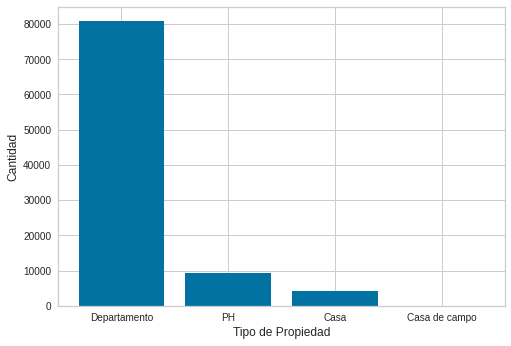

In [9]:
# Vemos la cantidad de viviendas

tipo_vivienda = ds_propiedades.property_type.value_counts().to_frame().reset_index().rename(columns={'index':'Vivienda', 'property_type':'Count'})

print(tipo_vivienda)

plt.ylabel('Cantidad', fontsize = 12);
plt.xlabel('Tipo de Propiedad', fontsize = 12);
plt.bar(tipo_vivienda.Vivienda, tipo_vivienda.Count)
plt.show()

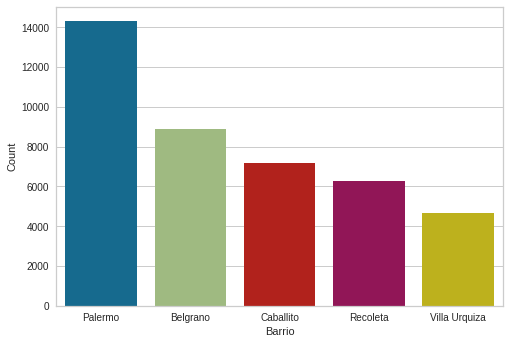

In [10]:
#graficamos la cantidad de viviendas en venta por barrio
viviendas_por_barrio = ds_propiedades.barrio.value_counts().to_frame().reset_index().rename(columns={'index':'Barrio', 'barrio':'Count'})
sns.barplot(x=viviendas_por_barrio.head()['Barrio'], y=viviendas_por_barrio.head()['Count'])

In [11]:
filas_totales = ds_propiedades.shape[0]
print('Porcentaje de filas pertenecientes al valor Casa de campo:',round((ds_propiedades.loc[ds_propiedades.property_type == 'Casa de campo'].shape[0]/filas_totales * 100),2))

Porcentaje de filas pertenecientes al valor Casa de campo: 0.01


Ya que la cantidad de casas de campo es muy baja, las eliminamos, ya que consideramos que podrian afectar negativamente al analisis ya que estamos analizando propiedades en una ciudad.

In [12]:
#quitamos, una vez que vemos que son unicamente 7 y que podrían afectar negativamente al análisis, las casas de campo
ds_propiedades = ds_propiedades[ds_propiedades.property_type != 'Casa de campo']

Variables Cuantitativas:

In [13]:
#vemos la media de las variables cuantitativas
variables_cuantitativas = ['property_rooms', 'property_bedrooms', 'property_surface_total', 'property_surface_covered', 'property_price']
round(ds_propiedades[variables_cuantitativas].mean(), 2)

property_rooms                   2.82
property_bedrooms                2.01
property_surface_total         109.09
property_surface_covered        87.93
property_price              226238.21
dtype: float64

In [14]:
#vemos la mediana de las variables cuantitativas
ds_propiedades[variables_cuantitativas].median()

property_rooms                   3.0
property_bedrooms                2.0
property_surface_total          65.0
property_surface_covered        58.0
property_price              143900.0
dtype: float64

In [15]:
#vemos la moda de las variables cuantitativas
ds_propiedades[variables_cuantitativas].mode()

property_rooms  property_bedrooms  property_surface_total  \
0             3.0                1.0                    50.0   

   property_surface_covered  property_price  
0                      40.0        110000.0

In [16]:
#mostramos mas propiedades estadísticas de las variables cuantitativas
ds_propiedades[variables_cuantitativas].describe()

property_rooms  property_bedrooms  property_surface_total  \
count    93205.000000       83262.000000            89405.000000   
mean         2.822799           2.014629              109.092970   
std          1.426148           1.129767              980.401976   
min          1.000000          -1.000000               10.000000   
25%          2.000000           1.000000               45.000000   
50%          3.000000           2.000000               65.000000   
75%          4.000000           3.000000              105.000000   
max         40.000000          70.000000           137000.000000   

       property_surface_covered  property_price  
count              90895.000000    9.424900e+04  
mean                  87.931932    2.262382e+05  
std                  990.927129    3.186035e+05  
min                    1.000000    5.000000e+03  
25%                   40.000000    9.500000e+04  
50%                   58.000000    1.439000e+05  
75%                   88.000000    2.370000e+05  
max               217000.000000    2.140000e+07

Promedio de Superficie Total de las casas: 313.51 m2
Promedio de Superficie Total de los ph: 140.97 m2
Promedio de Superficie Total de los departamentos: 95.5 m2


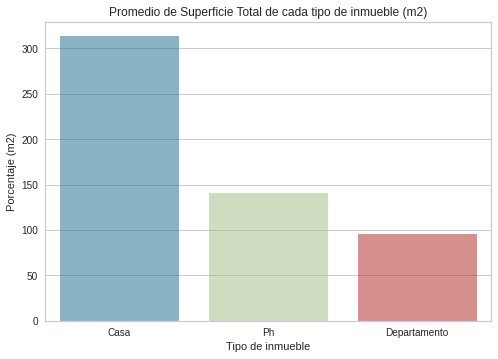

In [17]:
promedio_superficie_total_casa = ds_propiedades.loc[ds_propiedades.property_type.str.contains('Casa')].property_surface_total.mean(skipna = True).round(2)
promedio_superficie_total_ph = ds_propiedades.loc[ds_propiedades.property_type.str.contains('PH')].property_surface_total.mean(skipna = True).round(2)
promedio_superficie_total_departamento = ds_propiedades.loc[ds_propiedades.property_type.str.contains('Departamento')].property_surface_total.mean(skipna = True).round(2)

print('Promedio de Superficie Total de las casas:', promedio_superficie_total_casa, 'm2')
print('Promedio de Superficie Total de los ph:', promedio_superficie_total_ph, 'm2')
print('Promedio de Superficie Total de los departamentos:', promedio_superficie_total_departamento, 'm2')

eje_x = ['Casa', 'Ph', 'Departamento']
eje_y = [promedio_superficie_total_casa, promedio_superficie_total_ph, promedio_superficie_total_departamento]

sns_bar_plot=sns.barplot(x=eje_x, y=eje_y, alpha=0.5).set(title="Promedio de Superficie Total de cada tipo de inmueble (m2)",ylabel='Porcentaje (m2)',xlabel='Tipo de inmueble')

Promedio de Superficie Cubierta de las casas: 278.33
Promedio de Superficie Cubierta de los ph: 103.64
Promedio de Superficie Cubierta de los departamentos: 76.23


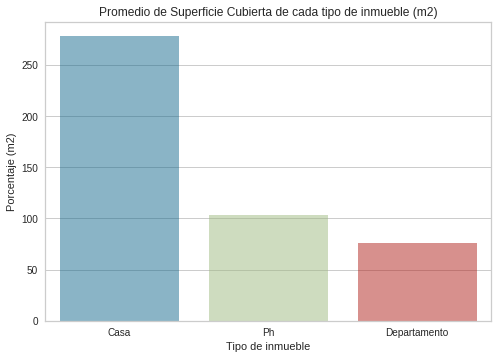

In [18]:
promedio_superficie_cubierta_casa = ds_propiedades.loc[ds_propiedades.property_type.str.contains('Casa')].property_surface_covered.mean(skipna = True).round(2)
promedio_superficie_cubierta_ph = ds_propiedades.loc[ds_propiedades.property_type.str.contains('PH')].property_surface_covered.mean(skipna = True).round(2)
promedio_superficie_cubierta_departamento = ds_propiedades.loc[ds_propiedades.property_type.str.contains('Departamento')].property_surface_covered.mean(skipna = True).round(2)

print('Promedio de Superficie Cubierta de las casas:', promedio_superficie_cubierta_casa)
print('Promedio de Superficie Cubierta de los ph:', promedio_superficie_cubierta_ph)
print('Promedio de Superficie Cubierta de los departamentos:', promedio_superficie_cubierta_departamento)

eje_x = ['Casa', 'Ph', 'Departamento']
eje_y = [promedio_superficie_cubierta_casa, promedio_superficie_cubierta_ph, promedio_superficie_cubierta_departamento]

sns_bar_plot=sns.barplot(x=eje_x, y=eje_y, alpha=0.5).set(title="Promedio de Superficie Cubierta de cada tipo de inmueble (m2)",ylabel='Porcentaje (m2)',xlabel='Tipo de inmueble')

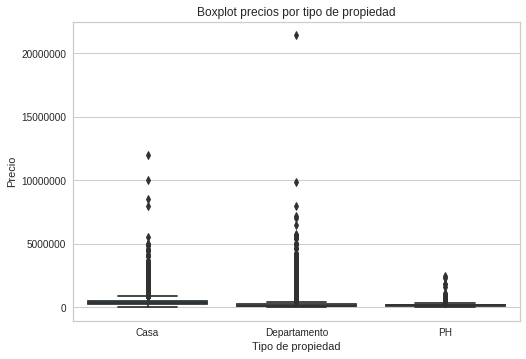

In [19]:
# Hago un boxplot de precios
plt.ticklabel_format(style='plain', axis='y')
grf=sns.boxplot(y="property_price", x="property_type", data=ds_propiedades).set(title="Boxplot precios por tipo de propiedad",xlabel="Tipo de propiedad",ylabel="Precio")

Distribucio de las variables

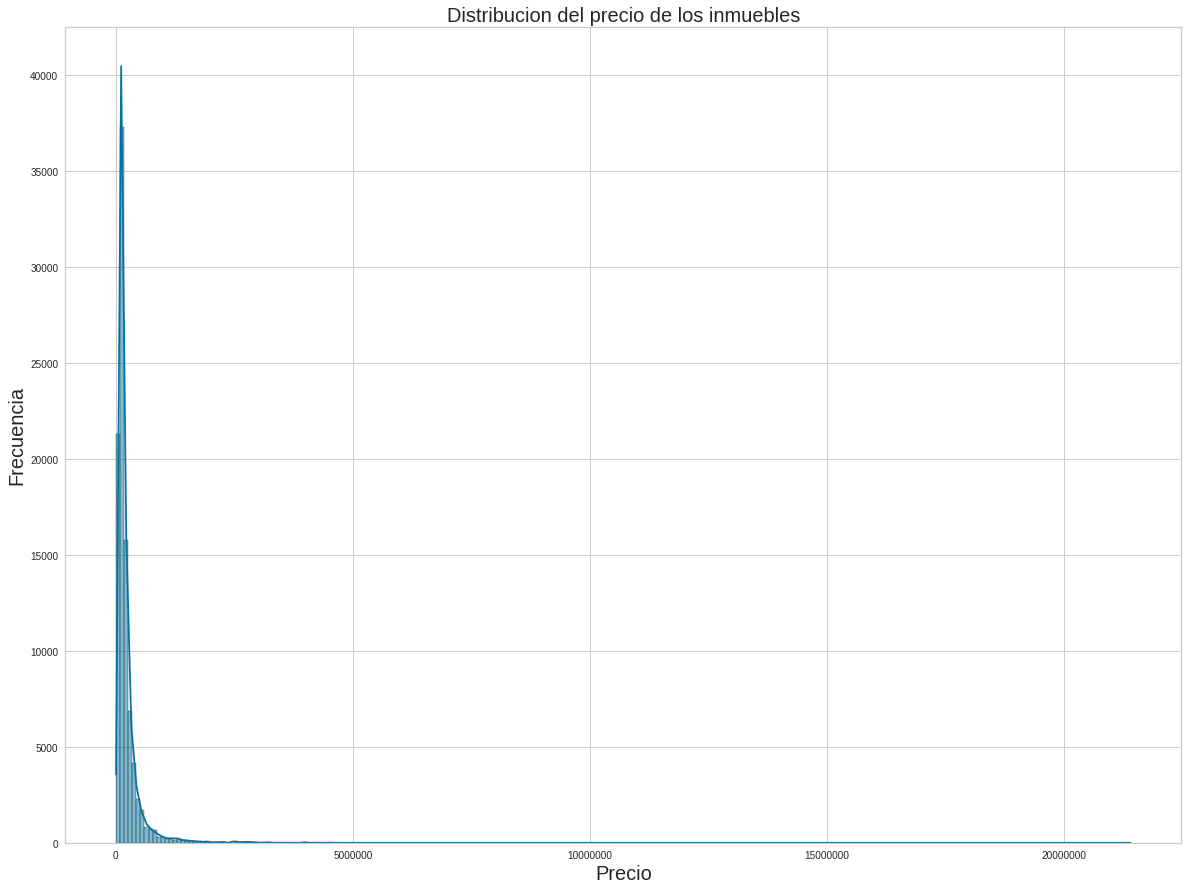

In [20]:
plt.figure(figsize=(20, 15))

plt.xlabel("Precio", fontsize = 20)
plt.ylabel("Frecuencia", fontsize = 20)
plt.ticklabel_format(style='plain', axis='x')
sns.histplot(data = ds_propiedades['property_price'],bins=250, edgecolor='black', kde=True).set_title("Distribucion del precio de los inmuebles",fontsize = 20)
plt.show()

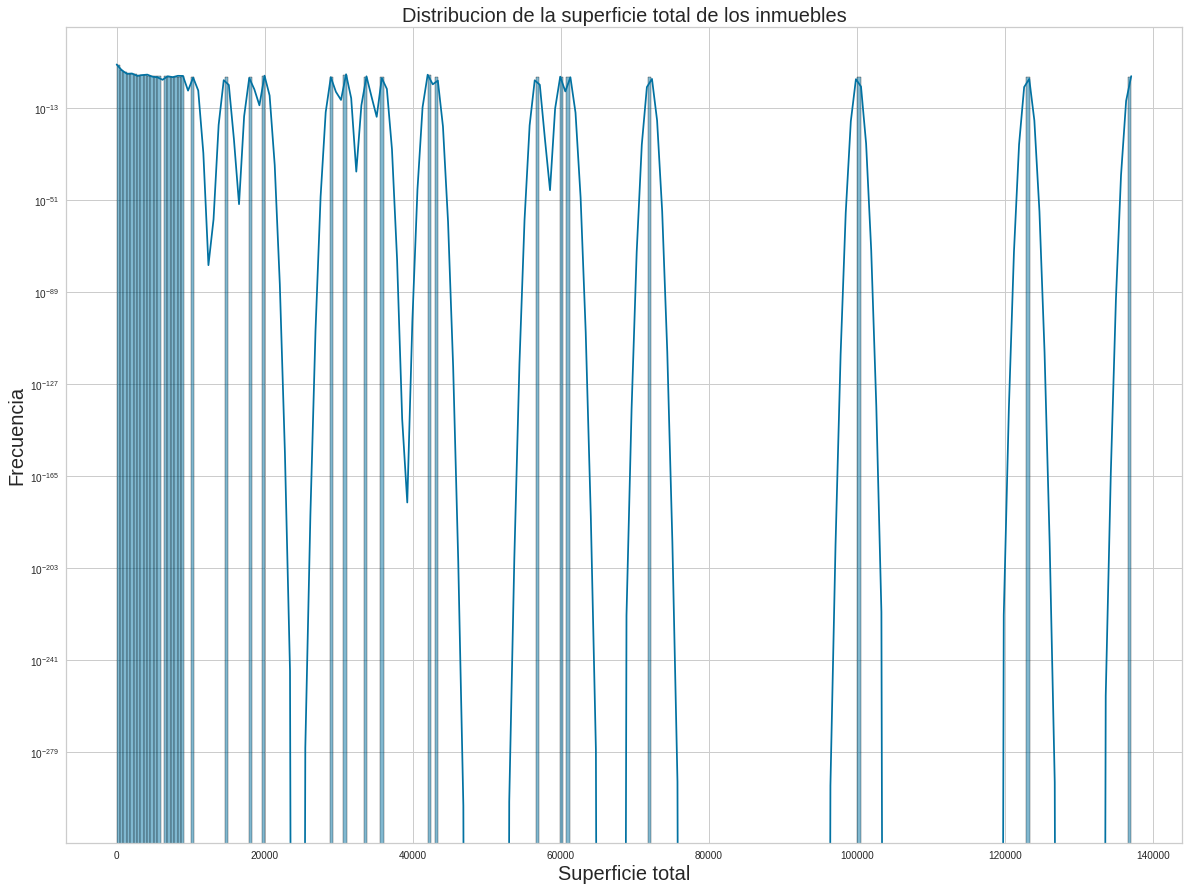

In [21]:
plt.figure(figsize=(20, 15))
plt.xlabel("Superficie total", fontsize = 20)
plt.ylabel("Frecuencia", fontsize = 20)
plt.ticklabel_format(style='plain', axis='x')
plt.yscale("log")
sns.histplot(data = ds_propiedades['property_surface_total'],bins=300, edgecolor='black', kde=True).set_title("Distribucion de la superficie total de los inmuebles",fontsize = 20)
plt.show()

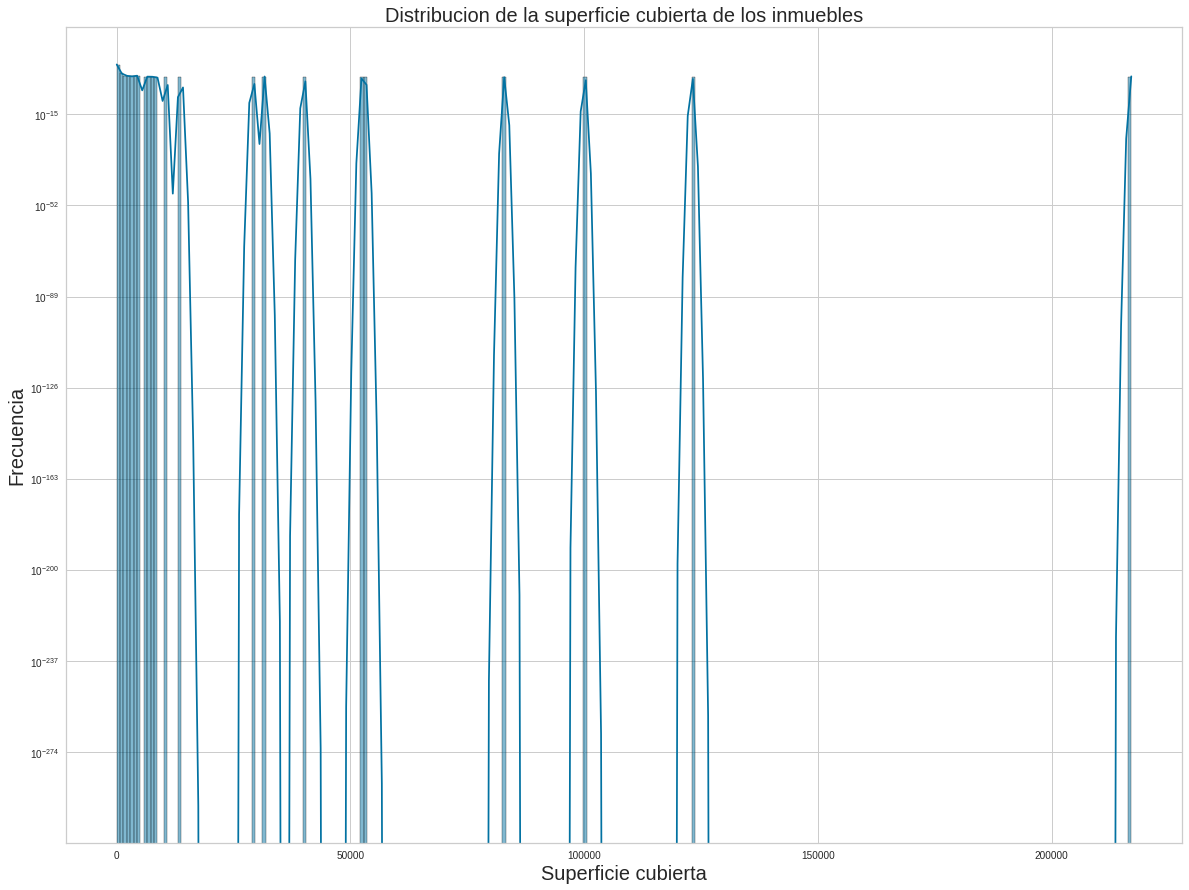

In [22]:
plt.figure(figsize=(20, 15))
plt.xlabel("Superficie cubierta", fontsize = 20)
plt.ylabel("Frecuencia", fontsize = 20)
plt.ticklabel_format(style='plain', axis='x')
plt.yscale("log")
sns.histplot(data = ds_propiedades['property_surface_covered'],bins=300, edgecolor='black', kde=True).set_title("Distribucion de la superficie cubierta de los inmuebles",fontsize = 20)
plt.show()

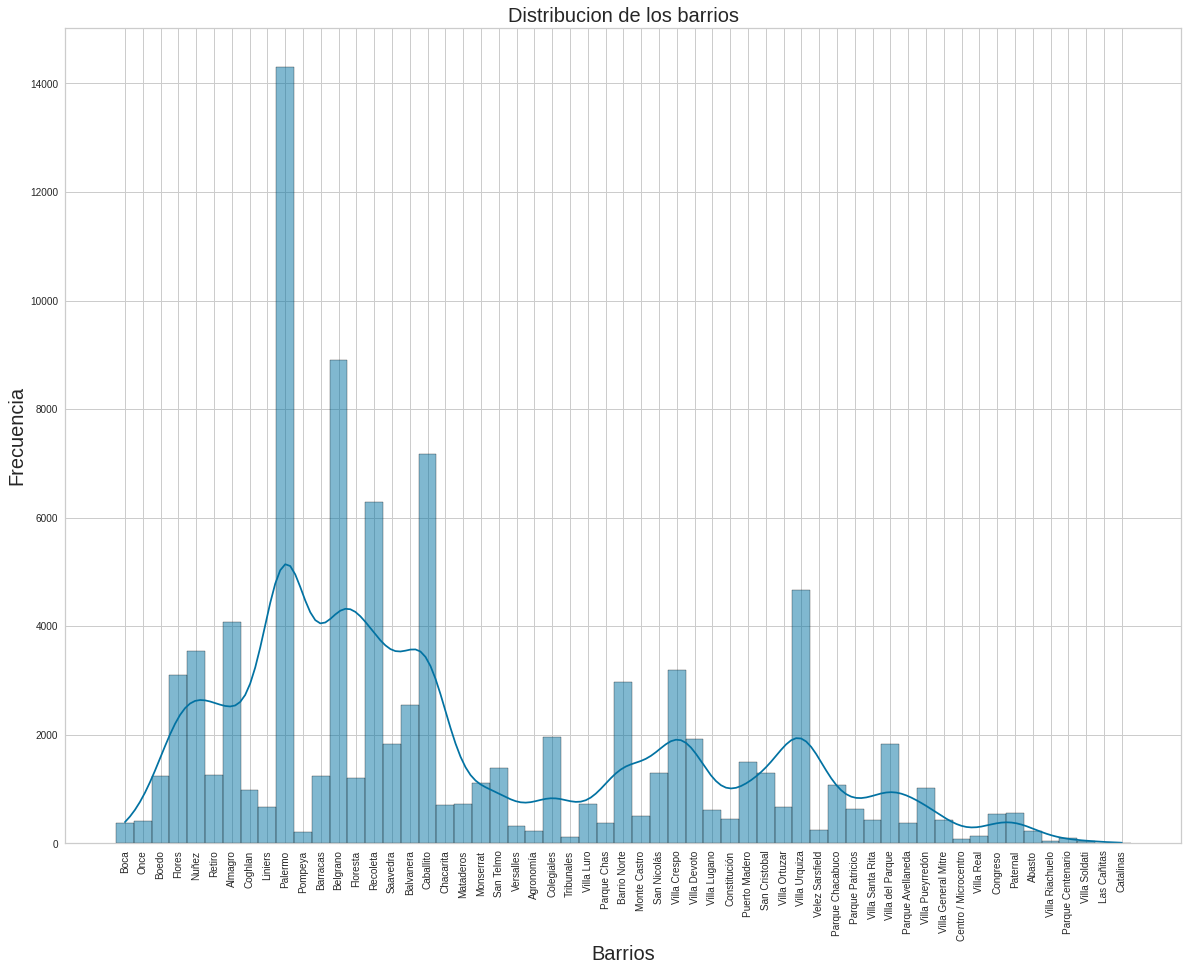

In [23]:
plt.figure(figsize=(20, 15))
plt.xlabel("Barrios", fontsize = 20)
plt.ylabel("Frecuencia", fontsize = 20)
plt.ticklabel_format(style='plain', axis='x')
plt.xticks(rotation=90)
sns.histplot(data = ds_propiedades['barrio'],bins=50, edgecolor='black', kde=True).set_title("Distribucion de los barrios",fontsize = 20)
plt.show()

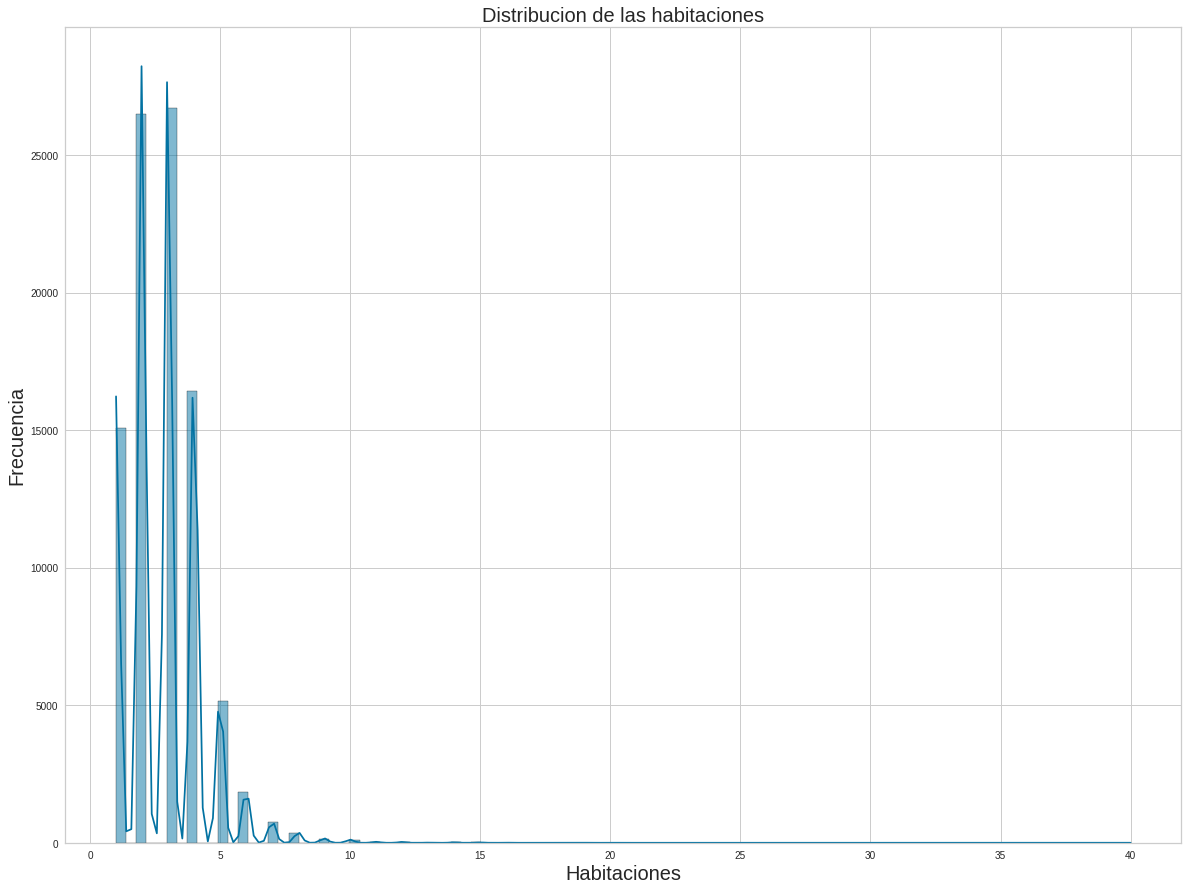

In [24]:
plt.figure(figsize=(20, 15))
plt.xlabel("Habitaciones", fontsize = 20)
plt.ylabel("Frecuencia", fontsize = 20)
plt.ticklabel_format(style='plain', axis='x')
sns.histplot(data = ds_propiedades['property_rooms'],bins=100, edgecolor='black', kde=True).set_title("Distribucion de las habitaciones",fontsize = 20)
plt.show()

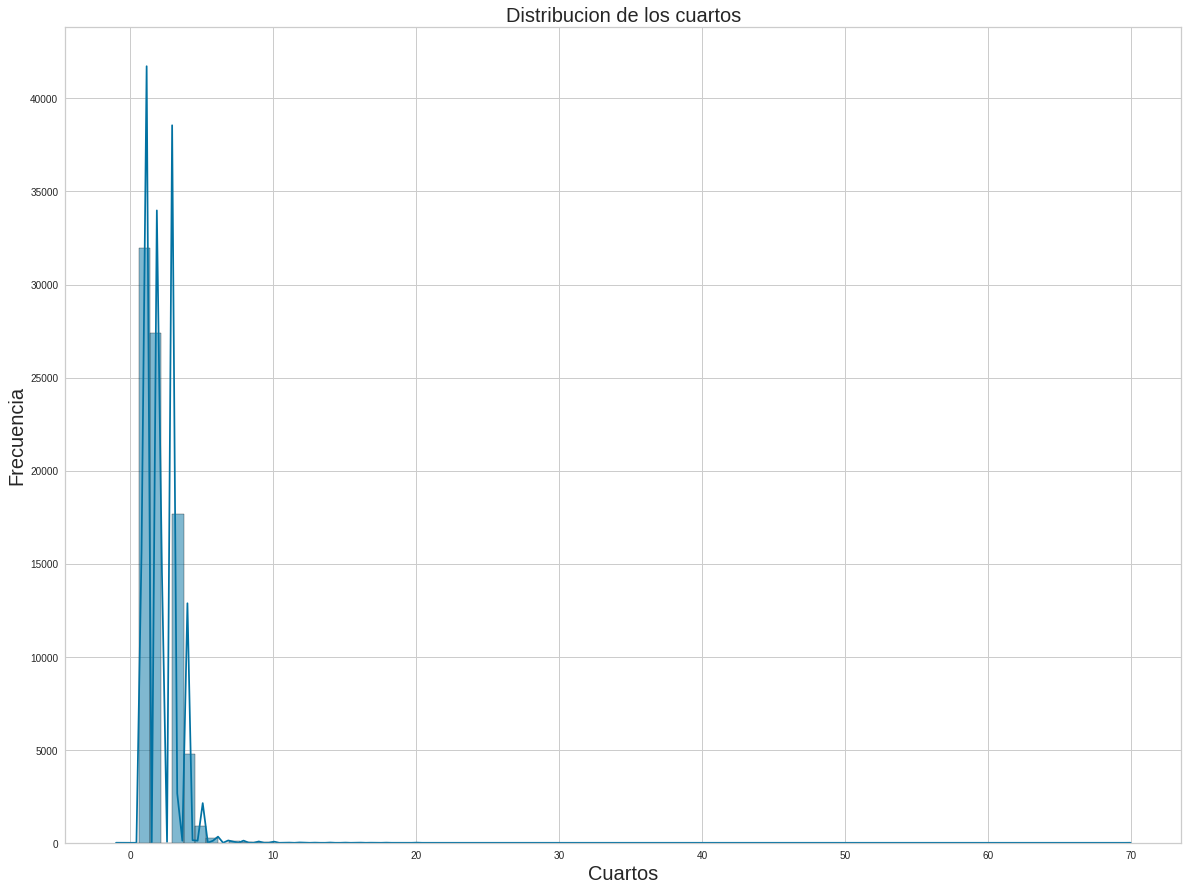

In [25]:
plt.figure(figsize=(20, 15))
plt.xlabel("Cuartos", fontsize = 20)
plt.ylabel("Frecuencia", fontsize = 20)
plt.ticklabel_format(style='plain', axis='x')

sns.histplot(data = ds_propiedades['property_bedrooms'],bins=90, edgecolor='black', kde=True).set_title("Distribucion de los cuartos",fontsize = 20)
plt.show()

Relacion entre las variables

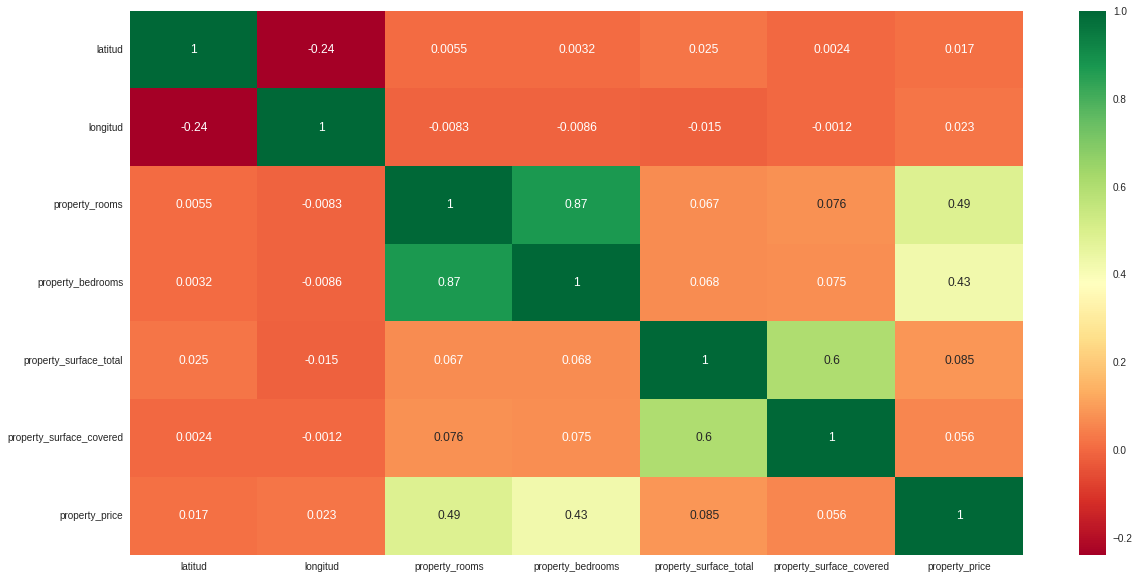

In [26]:
ds_relacion_variables = ds_propiedades.drop(['place_l6'], axis = 1, inplace = False)
plt.figure(figsize=(20,10))

color = plt.get_cmap('RdYlGn') 
color.set_bad('lightblue')

sns.heatmap(ds_relacion_variables.corr(),annot=True, cmap = color)

Describir las correlaciones que valgan la pena

PONER LAS CONCLUCIONES DE LA EXPLORACION INICIAL

In [27]:
# Creamos data set auxiliares
ds_propiedades_casas = ds_propiedades.loc[ds_propiedades.property_type == 'Casa']
ds_propiedades_ph = ds_propiedades.loc[ds_propiedades.property_type =='PH']
ds_propiedades_departamento = ds_propiedades.loc[ds_propiedades.property_type== 'Departamento']

##Variables irrelevantes en el análisis

Ademas del id, que ya nos dice la consigna que es apropiado sacarlo, nos parecieron datos innecesarios: 


*   place_l2 se borra porque todos los datos son de Capital Federal.
*   operation se borra porque todos los ventas.
*   property_currency se borra porque todos tienen el mismo tipo de moneda.
*   property_title se borra porque no creemos que aporte informacion relevante.
  



##Datos faltantes

<BarContainer object of 20 artists>

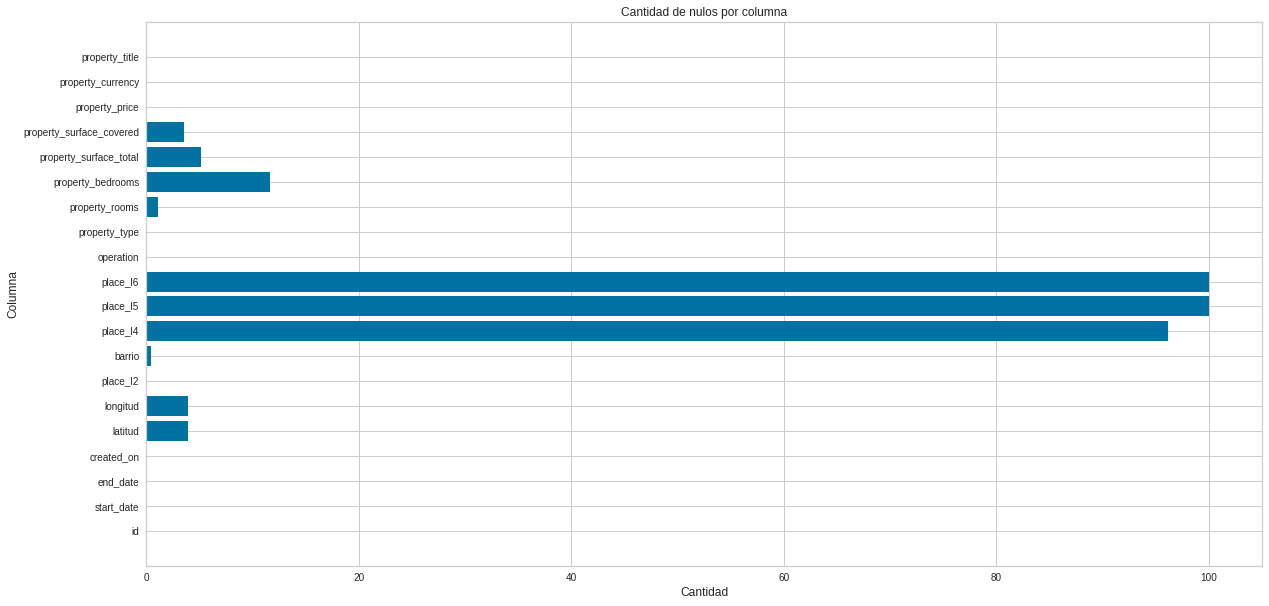

In [28]:
# Vemos cuantos valores nulos tiene cada columna porcentualmente respecto de la cantidad de filas
filas_totales = ds_propiedades.shape[0]
cantidad_nulos_columna = ds_propiedades.isna().sum()/filas_totales * 100

plt.figure(figsize=(20,10))
plt.xlabel('Cantidad', fontsize = 12)
plt.ylabel('Columna', fontsize = 12)
plt.title('Cantidad de nulos por columna')
plt.barh(ds_propiedades.columns, cantidad_nulos_columna)

In [29]:
filas_totales_casa = ds_propiedades_casas.shape[0]
filas_totales_ph = ds_propiedades_ph.shape[0]
filas_totales_departamento = ds_propiedades_departamento.shape[0]

porcentaje_nulos_casa = (ds_propiedades_casas.property_surface_total.isna().sum()/filas_totales_casa * 100).round(3)
porcentaje_nulos_ph = (ds_propiedades_ph.property_surface_total.isna().sum()/filas_totales_ph * 100).round(3)
porcentaje_nulos_depto = (ds_propiedades_departamento.property_surface_total.isna().sum()/filas_totales_departamento * 100).round(3)

print('Porcentaje de valores nulos en la columna Superficie Total de las casas:', porcentaje_nulos_casa)
print('Porcentaje de valores nulos en la columna Superficie Total de en los ph:', porcentaje_nulos_ph)
print('Porcentaje de valores nulos en la columna Superficie Total de los departamentos:', porcentaje_nulos_depto)

Porcentaje de valores nulos en la columna Superficie Total de las casas: 10.472
Porcentaje de valores nulos en la columna Superficie Total de en los ph: 4.047
Porcentaje de valores nulos en la columna Superficie Total de los departamentos: 4.991


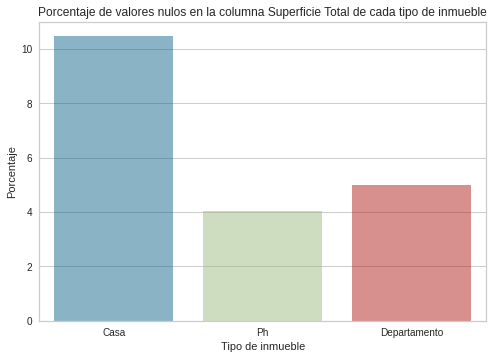

In [30]:
eje_x = ['Casa', 'Ph', 'Departamento']
eje_y = [porcentaje_nulos_casa, porcentaje_nulos_ph, porcentaje_nulos_depto]

sns_bar_plot=sns.barplot(x=eje_x, y=eje_y, alpha=0.5).set(title="Porcentaje de valores nulos en la columna Superficie Total de cada tipo de inmueble",ylabel='Porcentaje',xlabel='Tipo de inmueble')

In [31]:
filas_totales_casa = ds_propiedades_casas.shape[0]
filas_totales_ph = ds_propiedades_ph.shape[0]
filas_totales_departamento = ds_propiedades_departamento.shape[0]

porcentaje_nulos_casa = (ds_propiedades_casas.property_surface_covered.isna().sum()/filas_totales_casa * 100).round(3)
porcentaje_nulos_ph = (ds_propiedades_ph.property_surface_covered.isna().sum()/filas_totales_ph * 100).round(3)
porcentaje_nulos_depto = (ds_propiedades_departamento.property_surface_covered.isna().sum()/filas_totales_departamento * 100).round(3)

print('Porcentaje de valores nulos en la columna Superficie Cubierta de las casas:', porcentaje_nulos_casa, 'm2')
print('Porcentaje de valores nulos en la columna Superficie Cubierta de los ph:', porcentaje_nulos_ph, 'm2')
print('Porcentaje de valores nulos en la columna Superficie Cubierta de los departamentos:', porcentaje_nulos_depto, 'm2')

Porcentaje de valores nulos en la columna Superficie Cubierta de las casas: 2.792 m2
Porcentaje de valores nulos en la columna Superficie Cubierta de los ph: 2.644 m2
Porcentaje de valores nulos en la columna Superficie Cubierta de los departamentos: 3.703 m2


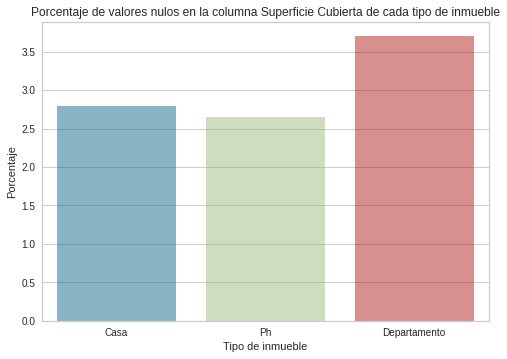

In [32]:
eje_x = ['Casa', 'Ph', 'Departamento']
eje_y = [porcentaje_nulos_casa, porcentaje_nulos_ph, porcentaje_nulos_depto]

sns_bar_plot=sns.barplot(x=eje_x, y=eje_y, alpha=0.5).set(title="Porcentaje de valores nulos en la columna Superficie Cubierta de cada tipo de inmueble",ylabel='Porcentaje',xlabel='Tipo de inmueble')

In [33]:
filas_totales = ds_propiedades.shape[0]
print('Porcentaje de filas con datos nulos en la columna property_rooms:',round(ds_propiedades.property_rooms.isna().sum()/filas_totales * 100,2))

Porcentaje de filas con datos nulos en la columna property_rooms: 1.11


In [34]:
#Borramos las filas con con datos nulos en la columna property_rooms.
condition = ds_propiedades[ds_propiedades.property_rooms.isna()]
ds_propiedades.drop(condition.index.tolist(), axis=0, inplace=True)

condition = ds_trabajo_test[ds_trabajo_test.property_rooms.isna()]
ds_trabajo_test.drop(condition.index.tolist(), axis=0, inplace=True)

condition = ds_trabajo_train[ds_trabajo_train.property_rooms.isna()]
ds_trabajo_train.drop(condition.index.tolist(), axis=0, inplace=True)

In [35]:
filas_totales = ds_propiedades.shape[0]
print('Porcentaje de filas con datos nulos en la columna property_bedrooms:',round(ds_propiedades.property_bedrooms.isna().sum()/filas_totales * 100,2))

Porcentaje de filas con datos nulos en la columna property_bedrooms: 11.32


In [36]:
filas_totales = ds_propiedades.shape[0]
print('Porcentaje de filas con datos nulos en la columna latitud:',round(ds_propiedades.latitud.isna().sum()/filas_totales * 100,2))

Porcentaje de filas con datos nulos en la columna latitud: 3.87


In [37]:
#Borramos las filas con con datos nulos en la columna latitud.
condition = ds_propiedades[ds_propiedades.latitud.isna()]
ds_propiedades.drop(condition.index.tolist(), axis=0, inplace=True)

condition = ds_trabajo_test[ds_trabajo_test.latitud.isna()]
ds_trabajo_test.drop(condition.index.tolist(), axis=0, inplace=True)

condition = ds_trabajo_train[ds_trabajo_train.latitud.isna()]
ds_trabajo_train.drop(condition.index.tolist(), axis=0, inplace=True)

In [38]:
filas_totales = ds_propiedades.shape[0]
print('Porcentaje de filas con datos nulos en la columna longitud:',round(ds_propiedades.longitud.isna().sum()/filas_totales * 100,2))

Porcentaje de filas con datos nulos en la columna longitud: 0.0


Reemplazamos valores nulos en la columna property_bedrooms con los valores de la columna property_rooms - 1, ya que suponemos que las casas tienen al menos una sala

In [39]:
def reemplazar_property_bedrooms_por_property_rooms(row):
  if (np.isnan(row.property_bedrooms)):
    return row.property_rooms - 1
  else: 
    return row.property_bedrooms

ds_propiedades.property_bedrooms = ds_propiedades.apply(lambda row: reemplazar_property_bedrooms_por_property_rooms(row), axis=1)
ds_trabajo_test.property_bedrooms = ds_trabajo_test.apply(lambda row: reemplazar_property_bedrooms_por_property_rooms(row), axis=1)
ds_trabajo_train.property_bedrooms = ds_trabajo_train.apply(lambda row: reemplazar_property_bedrooms_por_property_rooms(row), axis=1)

Como todos los datos son del mismo año, solo dejamos los meses en las columnas start_date y create on.

In [40]:
ds_propiedades['start_date_month'] = pd.DatetimeIndex(ds_propiedades['start_date']).month
ds_propiedades['created_on_month'] = pd.DatetimeIndex(ds_propiedades['created_on']).month
ds_propiedades.drop(['start_date', 'created_on'], axis = 1, inplace = True)

ds_trabajo_test['start_date_month'] = pd.DatetimeIndex(ds_trabajo_test['start_date']).month
ds_trabajo_test['created_on_month'] = pd.DatetimeIndex(ds_trabajo_test['created_on']).month
ds_trabajo_test.drop(['start_date', 'created_on'], axis = 1, inplace = True)

ds_trabajo_train['start_date_month'] = pd.DatetimeIndex(ds_trabajo_train['start_date']).month
ds_trabajo_train['created_on_month'] = pd.DatetimeIndex(ds_trabajo_train['created_on']).month
ds_trabajo_train.drop(['start_date', 'created_on'], axis = 1, inplace = True)

##Valores atipicos

In [41]:
superficies_anomalas = ds_propiedades.loc[ds_propiedades.property_surface_total < ds_propiedades.property_surface_covered].shape[0]
print('Porcentaje de filas con superficie total menor a la superficie cubierta:',round((superficies_anomalas/filas_totales * 100),2))

Porcentaje de filas con superficie total menor a la superficie cubierta: 0.18


In [42]:
#Porcentaje de datos nulos en la columna barrio
print('Porcentaje de datos nulos en la columna barrio', round(ds_propiedades.barrio.isnull().mean() * 100, 2))

Porcentaje de datos nulos en la columna barrio 0.22


In [43]:
#Borramos las filas con superficie total menor a la superficie cubierta
ds_propiedades = ds_propiedades[ds_propiedades.property_surface_total >= ds_propiedades.property_surface_covered]
ds_propiedades.reset_index(inplace=True)

ds_trabajo_test = ds_trabajo_test[ds_trabajo_test.property_surface_total >= ds_trabajo_test.property_surface_covered]
ds_trabajo_test.reset_index(inplace=True)

ds_trabajo_train = ds_trabajo_train[ds_trabajo_train.property_surface_total >= ds_trabajo_train.property_surface_covered]
ds_trabajo_train.reset_index(inplace=True)

In [44]:
#Borramos las filas que tienen barrio nulo.
ds_propiedades = ds_propiedades[ds_propiedades.barrio.notna()]

ds_trabajo_test = ds_trabajo_test[ds_trabajo_test.barrio.notna()]

ds_trabajo_train = ds_trabajo_train[ds_trabajo_train.barrio.notna()]

In [45]:
#Porcentaje de filas con fecha de finalizacion anomala
filas_totales = ds_propiedades.shape[0]
print(round(ds_propiedades[ds_propiedades.end_date == '9999-12-31'].shape[0]/filas_totales * 100,2))

4.9


Interpretamos las publiocaciones con fecha "9999-12-31" como publicaciones que siguen activas, asi que creamos una columna para indicar esa condicion.

In [46]:
#Entendemos que las fechas que tienen año 9999 o son mayores a la fecha actual son publicaciones que siguen activas en el sitio web.
#Creamos una columna que indique esto.

ds_propiedades = ds_propiedades.assign(pub_activa=0)
ds_trabajo_test = ds_trabajo_test.assign(pub_activa=0)
ds_trabajo_train = ds_trabajo_train.assign(pub_activa=0)

def definir_publicacion_activa(row):
  if row.end_date == '9999-12-31' or (pd.to_datetime(row.end_date) > pd.to_datetime("today").date()):
    return 1
  return 0

ds_propiedades.pub_activa = ds_propiedades.apply(lambda row: definir_publicacion_activa(row), axis=1)
ds_trabajo_test.pub_activa = ds_trabajo_test.apply(lambda row: definir_publicacion_activa(row), axis=1)
ds_trabajo_train.pub_activa = ds_trabajo_train.apply(lambda row: definir_publicacion_activa(row), axis=1)

In [47]:

print('Porcentaje de filas con 0 property_bedrooms:',round((ds_propiedades['property_bedrooms'] == 0).sum()/filas_totales * 100,2))

Porcentaje de filas con 0 property_bedrooms: 10.16


In [48]:
#vemos si hay propiedades que tengan otros tipos de superficies anómalas, como por ejemplo superficies cubiertas menores a las descubiertas 
#(en capital federal consideramos que no es muy posible en cualquiera de los 3 tipos de propiedades)

superficie_total_menor_a_cubierta_departamento = ds_propiedades[ds_propiedades.property_type == 'Departamento']
superficie_total_menor_a_cubierta_ph = ds_propiedades[ds_propiedades.property_type == 'PH']
superficie_total_menor_a_cubierta_casa = ds_propiedades[ds_propiedades.property_type == 'Casa']

filas_totales = ds_propiedades.shape[0]

superficies_anomalas_depto = superficie_total_menor_a_cubierta_departamento.loc[superficie_total_menor_a_cubierta_departamento.property_surface_total - 
                                                                          superficie_total_menor_a_cubierta_departamento.property_surface_covered > 
                                                                          superficie_total_menor_a_cubierta_departamento.property_surface_covered].shape[0]

superficies_anomalas_ph = superficie_total_menor_a_cubierta_ph.loc[superficie_total_menor_a_cubierta_ph.property_surface_total - 
                                                                      superficie_total_menor_a_cubierta_ph.property_surface_covered > 
                                                                      superficie_total_menor_a_cubierta_ph.property_surface_covered].shape[0]                                                              

superficies_anomalas_casa = superficie_total_menor_a_cubierta_casa.loc[superficie_total_menor_a_cubierta_casa.property_surface_total - 
                                                                      superficie_total_menor_a_cubierta_casa.property_surface_covered > 
                                                                      superficie_total_menor_a_cubierta_casa.property_surface_covered].shape[0] 

print('Porcentaje de filas con superficie cubierta menor a la superficie descubierta en Departamentos:',round((superficies_anomalas_depto/filas_totales * 100),2))
print('Porcentaje de filas con superficie cubierta menor a la superficie descubierta en PH:',round((superficies_anomalas_ph/filas_totales * 100),2))
print('Porcentaje de filas con superficie cubierta menor a la superficie descubierta en Casa:',round((superficies_anomalas_casa/filas_totales * 100),2))

Porcentaje de filas con superficie cubierta menor a la superficie descubierta en Departamentos: 1.06
Porcentaje de filas con superficie cubierta menor a la superficie descubierta en PH: 0.67
Porcentaje de filas con superficie cubierta menor a la superficie descubierta en Casa: 0.2


In [49]:
#Borramos las filas donde su superficie cubierta es menor a la descubierta.

condition = ds_propiedades[ds_propiedades.property_surface_total - ds_propiedades.property_surface_covered > ds_propiedades.property_surface_covered]
ds_propiedades.drop(condition.index.tolist(), axis=0, inplace=True)

condition = ds_trabajo_test[ds_trabajo_test.property_surface_total - ds_trabajo_test.property_surface_covered > ds_trabajo_test.property_surface_covered]
ds_trabajo_test.drop(condition.index.tolist(), axis=0, inplace=True)

condition = ds_trabajo_train[ds_trabajo_train.property_surface_total - ds_trabajo_train.property_surface_covered > ds_trabajo_train.property_surface_covered]
ds_trabajo_train.drop(condition.index.tolist(), axis=0, inplace=True)

In [50]:
filas_totales = ds_propiedades.shape[0]
print('Porcentaje de filas con menos ambientes que habitaciones:',round((ds_propiedades.loc[ds_propiedades.property_rooms < ds_propiedades.property_bedrooms].shape[0]/filas_totales * 100),2))

Porcentaje de filas con menos ambientes que habitaciones: 0.15


In [51]:
#Borramos las filas con menos ambientes que habitaciones.
condition = ds_propiedades[ds_propiedades.property_rooms < ds_propiedades.property_bedrooms]
ds_propiedades.drop(condition.index.tolist(), axis=0, inplace=True)

condition = ds_trabajo_test[ds_trabajo_test.property_rooms < ds_trabajo_test.property_bedrooms]
ds_trabajo_test.drop(condition.index.tolist(), axis=0, inplace=True)

condition = ds_trabajo_train[ds_trabajo_train.property_rooms < ds_trabajo_train.property_bedrooms]
ds_trabajo_train.drop(condition.index.tolist(), axis=0, inplace=True)

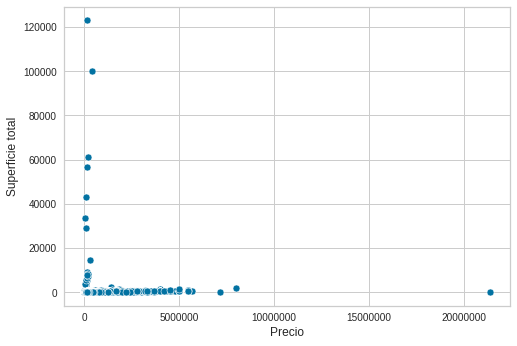

In [52]:
# Miro el scatterplot de precios con respecto a la superficie total
plt.ylabel('Superficie total', fontsize = 12);
plt.xlabel('Precio', fontsize = 12);
plt.ticklabel_format(style='plain', axis='x')
sns.scatterplot(data=ds_propiedades, x="property_price", y="property_surface_total")

Vemos que tenemos propiedades con superficie total muy alta con respecto a su precio y propiedades muy caras con respecto a su superficie total, analizamos un poco mas estos datos atipicos

In [53]:
# Vemos que departamentos en Capital Federal tienen mas de 300 m2
ds_propiedades[(ds_propiedades.property_surface_total > 2000) & (ds_propiedades.property_type == "Departamento")]
filas_totales = ds_propiedades.shape[0]

superficies_anomalas_depto = ds_propiedades.loc[(ds_propiedades.property_surface_total > 2000) & (ds_propiedades.property_type == "Departamento")].shape[0]

print('Porcentaje de departamentos con Superficie Total mayor a 2000 m2 :',round((superficies_anomalas_depto / filas_totales * 100),2))


Porcentaje de departamentos con Superficie Total mayor a 2000 m2 : 0.02


In [54]:
# Vemos que casas en Capital Federal tienen mas de 500 m2

ds_propiedades[(ds_propiedades.property_surface_total > 500) & (ds_propiedades.property_type == "Casa")]
filas_totales = ds_propiedades.shape[0]

superficies_anomalas_depto = ds_propiedades.loc[(ds_propiedades.property_surface_total > 1000) & (ds_propiedades.property_type == "Casa")].shape[0]

print('Porcentaje de Casa con Superficie Total mayor a 1000 m2 :',round((superficies_anomalas_depto / filas_totales * 100),2))

Porcentaje de Casa con Superficie Total mayor a 1000 m2 : 0.02


In [55]:
# Vemos que PH en Capital Federal tienen mas de 300 m2

ds_propiedades[(ds_propiedades.property_surface_total > 300) & (ds_propiedades.property_type == "PH")]
filas_totales = ds_propiedades.shape[0]

superficies_anomalas_depto = ds_propiedades.loc[(ds_propiedades.property_surface_total > 300) & (ds_propiedades.property_type == "PH")].shape[0]

print('Porcentaje de PH con Superficie Total mayor a 300 m2 :',round((superficies_anomalas_depto / filas_totales * 100),2))

Porcentaje de PH con Superficie Total mayor a 300 m2 : 0.24


In [56]:
# Vemos precios de propiedades

ds_propiedades.sort_values(by=['property_price'], ascending=False)


index                        id    end_date    latitud   longitud  \
10642   60073  uoM9HDKq3jZKQKgHXTIGkg==  2022-05-13 -34.616044 -58.458621   
26789  148534  AExqjjuaRO2KtiPjC8BUiQ==  2021-05-14 -34.565947 -58.442326   
54200  306829  nH/Kmmg1djAa7Wbrm742qA==  2021-06-05 -34.616918 -58.359927   
7792    45223  B1fGGdL5+aEWViK7FNPYVQ==  2021-06-18 -34.586413 -58.388982   
42732  241401  CKSEulXCVCU2yM4qtAqjWQ==  2021-06-05 -34.553355 -58.438662   
...       ...                       ...         ...        ...        ...   
25449  140460  u8oPwCg2R/C105SlZ9nlaQ==  2022-01-27 -34.579756 -58.406144   
46770  264963  CmmjZYus9eLZAT1UMsuaSQ==  9999-12-31 -34.598361 -58.387041   
39185  221731  mQStJ0NPSYuW7WA/0yOYuA==  2021-07-20 -34.576973 -58.406591   
65677  376985  Gi/LqlLpBXSMH9vD5kWUcw==  2021-03-19 -34.610046 -58.361382   
21291  117827  wv0/BYVHFO3KMwIt18OsNg==  9999-12-31 -34.587265 -58.389767   

              place_l2         barrio       place_l4 place_l5  place_l6  ...  \
10642  Capital Federal      Caballito            NaN      NaN       NaN  ...   
26789  Capital Federal       Belgrano            NaN      NaN       NaN  ...   
54200  Capital Federal  Puerto Madero            NaN      NaN       NaN  ...   
7792   Capital Federal       Recoleta            NaN      NaN       NaN  ...   
42732  Capital Federal       Belgrano            NaN      NaN       NaN  ...   
...                ...            ...            ...      ...       ...  ...   
25449  Capital Federal        Palermo            NaN      NaN       NaN  ...   
46770  Capital Federal       Recoleta            NaN      NaN       NaN  ...   
39185  Capital Federal        Palermo  Palermo Chico      NaN       NaN  ...   
65677  Capital Federal  Puerto Madero            NaN      NaN       NaN  ...   
21291  Capital Federal       Recoleta            NaN      NaN       NaN  ...   

      property_rooms property_bedrooms  property_surface_total  \
10642            3.0               2.0                    68.0   
26789            9.0               5.0                  1763.0   
54200            3.0               2.0                   128.0   
7792            10.0               4.0                   490.0   
42732            6.0               4.0                   516.0   
...              ...               ...                     ...   
25449            3.0               2.0                   120.0   
46770            1.0               0.0                    35.0   
39185            7.0               4.0                   415.0   
65677            4.0               3.0                   194.0   
21291           12.0              11.0                   385.0   

       property_surface_covered  property_price  property_currency  \
10642                      64.0      21400000.0                USD   
26789                    1763.0       8000000.0                USD   
54200                     118.0       7149999.0                USD   
7792                      490.0       5700000.0                USD   
42732                     456.0       5500000.0                USD   
...                         ...             ...                ...   
25449                     110.0          7500.0                USD   
46770                      35.0          6500.0                USD   
39185                     355.0          6200.0                USD   
65677                     194.0          5000.0                USD   
21291                     385.0          5000.0                USD   

                                          property_title start_date_month  \
10642                                 Departamento venta                1   
26789  Casa  Estilo Frances en Venta y/o Alquiler | V...                5   
54200                       Departamento - Puerto Madero                3   
7792                                        Posadas 1600                1   
42732           Espectacular Penthouse en Forum Alcorta!                4   
...                       

Vemos que tenemos un outlier, con un precio muy alto, una superficie muy chica y pocos ambientes, consideramos que borrar este dato seria lo correcto.

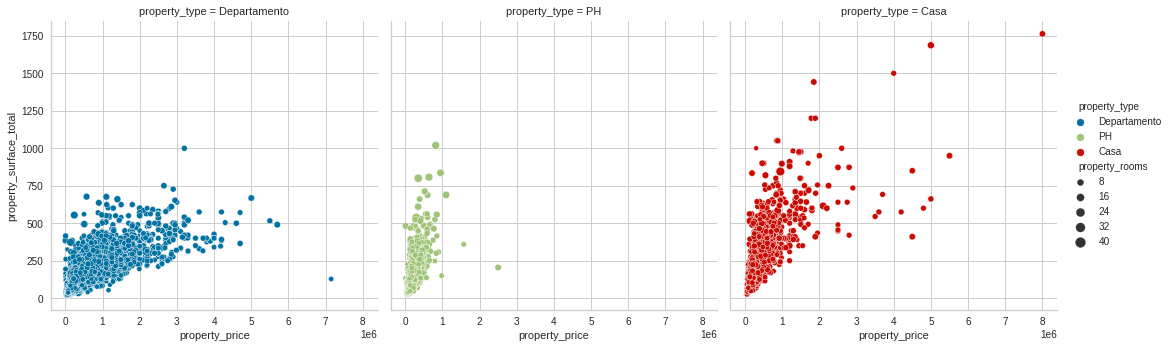

In [57]:
# Borramos el outlier
ds_propiedades = ds_propiedades[ds_propiedades.property_price != 21400000.0]
ds_trabajo_test = ds_trabajo_test[ds_trabajo_test.property_price != 21400000.0]
ds_trabajo_train = ds_trabajo_train[ds_trabajo_train.property_price != 21400000.0]

ds_tmp = ds_propiedades[ds_propiedades.property_surface_total < 2000]
sns.relplot(data=ds_tmp, x="property_price", y="property_surface_total", col='property_type', size="property_rooms", kind="scatter", hue="property_type")

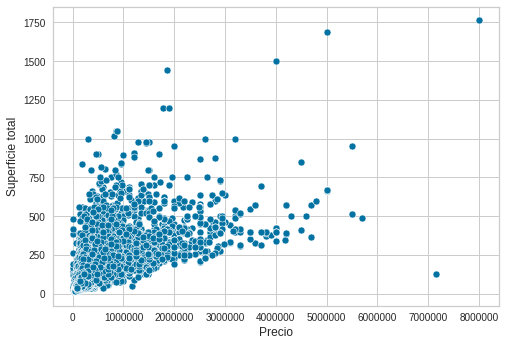

In [58]:
# Miro el scatterplot de precios con respecto a la superficie total
plt.ylabel('Superficie total', fontsize = 12);
plt.xlabel('Precio', fontsize = 12);
plt.ticklabel_format(style='plain', axis='x')
sns.scatterplot(data=ds_tmp, x="property_price", y="property_surface_total")

##Reduccion de la dimensionalidad

* placel4, place_l5, place_l6: son eliminados por cantidad elevada de datos nulos cómo se ve en el gráfico de arriba, todos con al menos 95% de datos nulos.
* nos importa saber que la publicacion esta activa, no la fecha de creacion y fin asique se eliminaran esas columnas.

In [59]:
columnas_a_eliminar=['index', 'id', 'place_l2', 'place_l5', 'place_l6', 'place_l4', 'end_date', 'property_title', 'property_currency', 'operation']
ds_propiedades.drop(columnas_a_eliminar, axis=1, inplace=True)
ds_trabajo_test.drop(columnas_a_eliminar, axis=1, inplace=True)
ds_trabajo_train.drop(columnas_a_eliminar, axis=1, inplace=True)

### PCA

Usamos PCA para ver los componentes principales y en base a eso reducir la dimensión del problema descartando la información excesiva.

In [60]:
#importamos las herramientas necesarias
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#elegimos las columnas que nos dan información de la propiedad de manera cuantitativa (sin contar el precio) y las normalizamos
columns = ['property_rooms', 'property_bedrooms','property_surface_total', 'property_surface_covered']
x_pca_train = ds_trabajo_train.loc[:,columns].values
scaler_pca = StandardScaler().fit_transform(x_pca_train)

#entrenamos el PCA
x_pca_train = PCA(random_state=0)
x_pca_train.fit(scaler_pca)


PCA(random_state=0)

In [61]:
#vemos la varianza acumulada componente a componente
var_cumu = np.cumsum(x_pca_train.explained_variance_ratio_) * 100 
#aislamos las que superan el 25% (aclaracion: k va a ser el índice del primer elemento que la supere, por lo que le debemos sumar 1 a lo que nos de de aca en adelante)
k = np.argmax(var_cumu > 95)
print(
    "El numero minimo de componentes para explicar el 95% de la varianza es: " + str(k + 1)
)

El numero minimo de componentes para explicar el 95% de la varianza es: 2


In [62]:
print(var_cumu)

[ 52.74409433  98.22567278  99.96324992 100.        ]


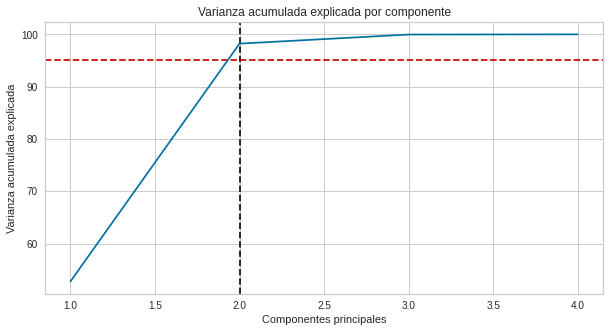

In [63]:
plt.figure(figsize=[10, 5])
plt.title('Varianza acumulada explicada por componente')
plt.ylabel('Varianza acumulada explicada')
plt.xlabel('Componentes principales')
plt.axvline(x=2, color="k", linestyle="--")
plt.axhline(y=95, color="r", linestyle="--")
ax = plt.plot(np.arange(1, var_cumu.shape[0] + 1, 1), var_cumu)
plt.show()

cp_1      cp_2
0 -1.301032  1.499042
1 -1.305450  1.495594
2 -0.946365  1.011828
3 -0.610282  0.638900
4 -0.600570  0.646582

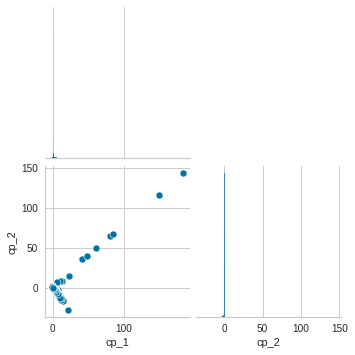

In [64]:
#obtenemos un modelo entrenado con las componentes principales (recordemos que son 2 por la k que sacamos antes más el elemento que ya explicamos que hay que sumar)
pca = PCA(n_components=2)
pca_transform=pca.fit_transform(scaler_pca)

cp_columns = ['cp_1', 'cp_2']

#cp es de componente principal
pca_df_aux = pd.DataFrame(data = pca_transform, columns = cp_columns)
pca_df_aux
sns.pairplot(pca_df_aux, corner=True)
pca_df_aux.head()

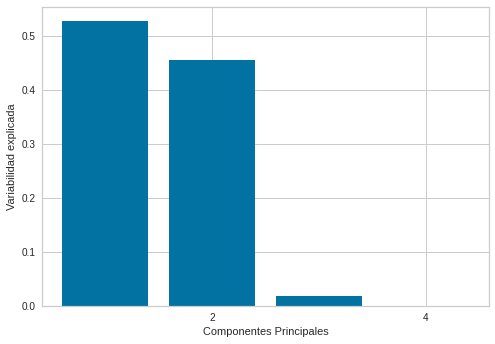

In [65]:
list_x = list(range(1, len(x_pca_train.explained_variance_ratio_)+1))

# Grafico varianza explicada y cantidad de componentes principales

plt.locator_params('x', nbins = 2)
plt.bar(list_x, x_pca_train.explained_variance_ratio_)
plt.xlabel(r'Componentes Principales')
plt.ylabel('Variabilidad explicada')
plt.show()

Podemos concluir que con 2 componentes perdemos mucha información, por lo que no sería correcto aplicar PCA a nuestro dataset.

Nuestro dataset reducido:

In [66]:
ds_train_reducido = ds_trabajo_train[['barrio', 'property_type']].copy()
ds_train_reducido[cp_columns] = pca_df_aux[cp_columns]

ds_test_reducido = ds_trabajo_test[['barrio', 'property_type']].copy()
ds_test_reducido[cp_columns] = pca_df_aux[cp_columns]

ds_reducido = pd.concat([ds_train_reducido, ds_test_reducido], axis=0)

ds_reducido



barrio property_type      cp_1      cp_2
0        Colegiales  Departamento -1.301032  1.499042
1          Congreso  Departamento -1.305450  1.495594
2           Liniers  Departamento -0.946365  1.011828
3       Parque Chas  Departamento -0.610282  0.638900
4             Boedo  Departamento -0.600570  0.646582
...             ...           ...       ...       ...
16358  Barrio Norte  Departamento -0.589462  0.655296
16359     Caballito  Departamento -0.909880  1.040596
16360     Caballito  Departamento  2.608113 -2.443353
16361       Palermo  Departamento  1.694023 -1.758739
16362     Caballito  Departamento -1.298792  1.500813

[80053 rows x 4 columns]

In [67]:
ds_reducido.to_csv('ds_reducido.csv', index=False)

##Analisis de los precios de los inmuebles

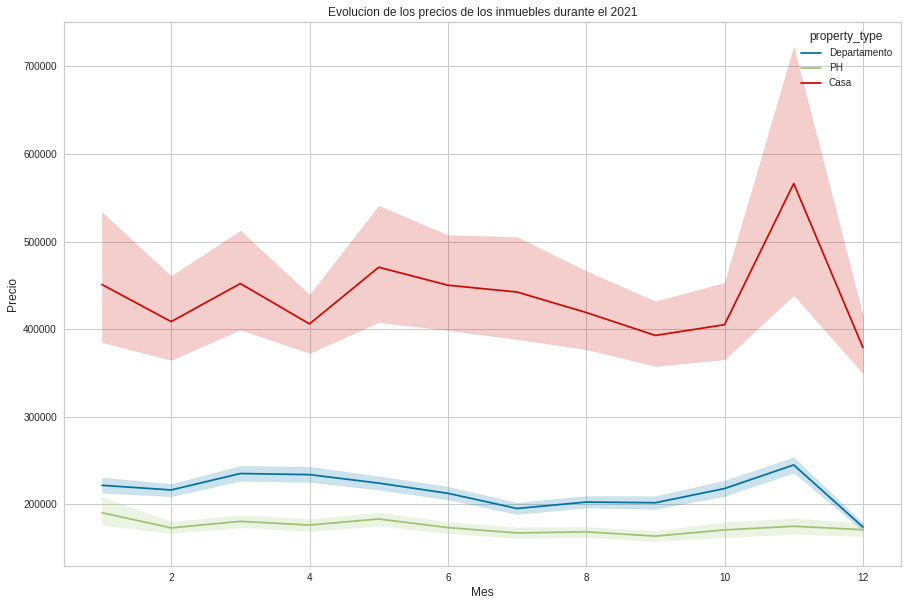

In [68]:
plt.figure(figsize=(15,10))
plt.ylabel('Precio', fontsize = 12);
plt.xlabel('Mes', fontsize = 12);
plt.title('Evolucion de los precios de los inmuebles durante el 2021')

sns.lineplot(x="start_date_month", y="property_price",hue="property_type", data=ds_propiedades)

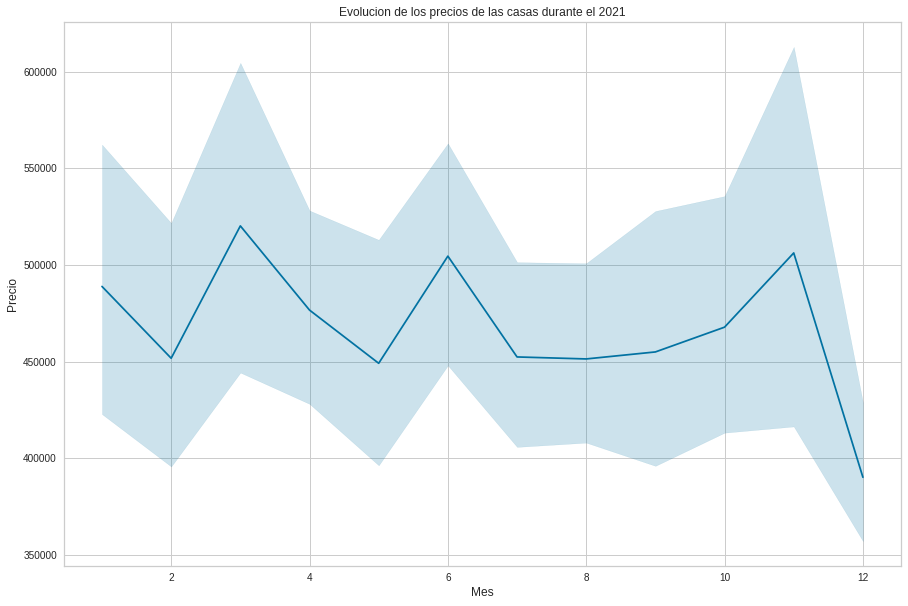

In [69]:
ds_propiedades_casas['month'] = pd.DatetimeIndex(ds_propiedades_casas['start_date']).month

plt.figure(figsize=(15,10))
plt.ylabel('Precio', fontsize = 12);
plt.xlabel('Mes', fontsize = 12);
plt.title('Evolucion de los precios de las casas durante el 2021')

sns.lineplot(x="month", y="property_price", data=ds_propiedades_casas)

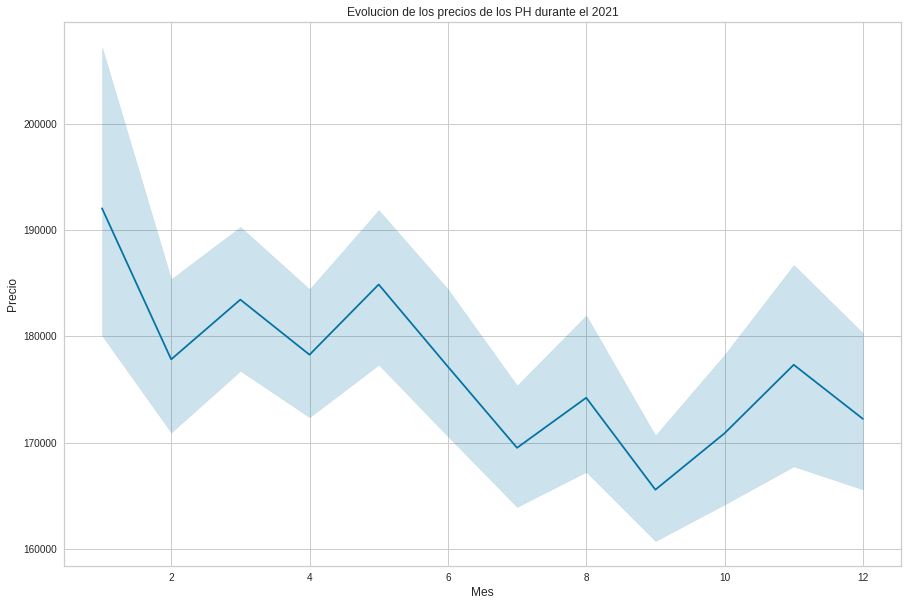

In [70]:
ds_propiedades_ph['month'] = pd.DatetimeIndex(ds_propiedades_ph['start_date']).month

plt.figure(figsize=(15,10))
plt.ylabel('Precio', fontsize = 12);
plt.xlabel('Mes', fontsize = 12);
plt.title('Evolucion de los precios de los PH durante el 2021')

sns.lineplot(x="month", y="property_price", data=ds_propiedades_ph)

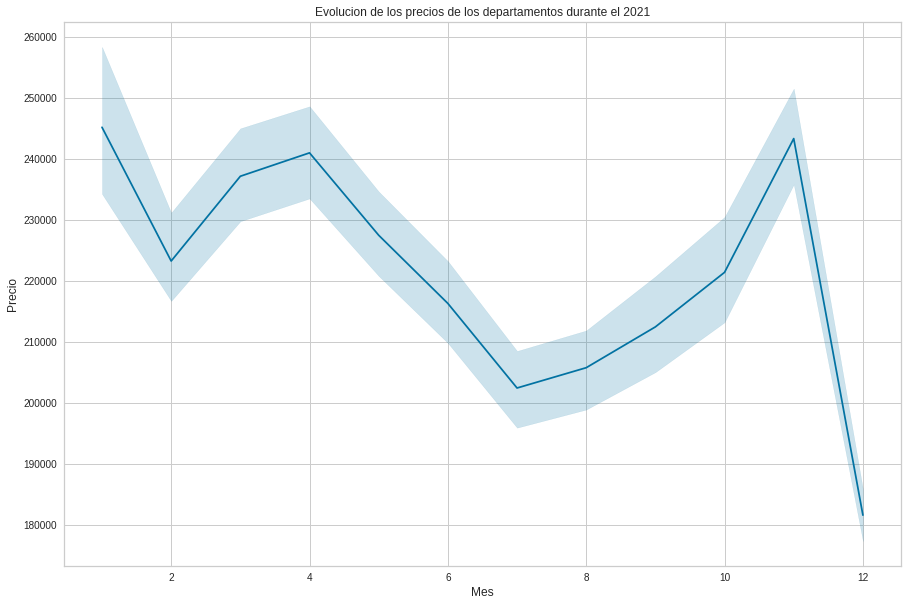

In [71]:
ds_propiedades_departamento['month'] = pd.DatetimeIndex(ds_propiedades_departamento['start_date']).month

plt.figure(figsize=(15,10))
plt.ylabel('Precio', fontsize = 12);
plt.xlabel('Mes', fontsize = 12);
plt.title('Evolucion de los precios de los departamentos durante el 2021')

sns.lineplot(x="month", y="property_price", data=ds_propiedades_departamento)

In [72]:
# Calculamos el precio promedio de tipo de propiedad por barrio
ds_promedio_precio_por_barrio = ds_propiedades.groupby(['barrio', 'property_type']).property_price.mean().round(2).reset_index()
ds_promedio_precio_por_barrio

barrio property_type  property_price
0              Abasto          Casa       291000.00
1              Abasto  Departamento       110470.09
2              Abasto            PH       223000.00
3           Agronomía          Casa       322333.33
4           Agronomía  Departamento       111499.74
..                ...           ...             ...
157     Villa Urquiza  Departamento       157299.46
158     Villa Urquiza            PH       178730.39
159  Villa del Parque          Casa       346379.69
160  Villa del Parque  Departamento       130162.29
161  Villa del Parque            PH       174536.04

[162 rows x 3 columns]

Promedio del valor de las casas: 465170.18 dolares
Promedio del valor de los ph: 176328.54 dolares
Promedio del valor de los departamentos: 219680.41 dolares


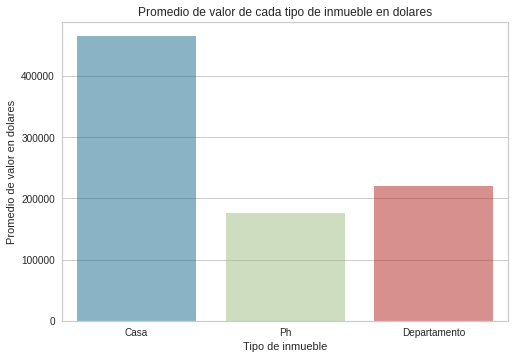

In [73]:
#Comparamos el promedio de valor de cada tipo de inmueble
promedio_valor_casas = ds_propiedades_casas.property_price.mean().round(2)
promedio_valor_ph = ds_propiedades_ph.property_price.mean().round(2)
promedio_valor_departamento = ds_propiedades_departamento.property_price.mean().round(2)

print('Promedio del valor de las casas:', promedio_valor_casas, 'dolares')
print('Promedio del valor de los ph:', promedio_valor_ph, 'dolares')
print('Promedio del valor de los departamentos:', promedio_valor_departamento, 'dolares')

eje_x = ['Casa', 'Ph', 'Departamento']
eje_y = [promedio_valor_casas, promedio_valor_ph, promedio_valor_departamento]

sns_bar_plot=sns.barplot(x=eje_x, y=eje_y, alpha=0.5).set(title="Promedio de valor de cada tipo de inmueble en dolares",ylabel='Promedio de valor en dolares',xlabel='Tipo de inmueble')

##Analisis de las superficies de cada inmueble

In [74]:
promedio_superficie_total_casa = ds_propiedades_casas.property_surface_total.mean(skipna = True).round(2)
promedio_superficie_total_ph = ds_propiedades_ph.property_surface_total.mean(skipna = True).round(2)
promedio_superficie_total_departamento = ds_propiedades_departamento.property_surface_total.mean(skipna = True).round(2)

print('Promedio de Superficie Total de las casas:', promedio_superficie_total_casa, 'm2')
print('Promedio de Superficie Total de los ph:', promedio_superficie_total_ph, 'm2')
print('Promedio de Superficie Total de los departamentos:', promedio_superficie_total_departamento, 'm2')

Promedio de Superficie Total de las casas: 313.51 m2
Promedio de Superficie Total de los ph: 140.97 m2
Promedio de Superficie Total de los departamentos: 95.5 m2


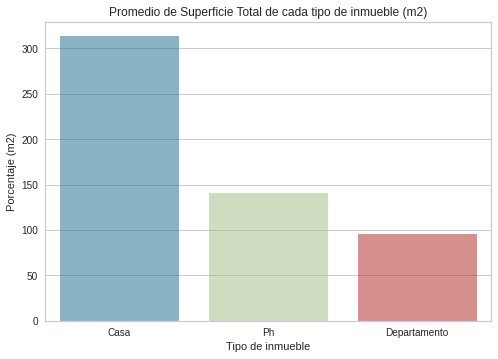

In [75]:
eje_x = ['Casa', 'Ph', 'Departamento']
eje_y = [promedio_superficie_total_casa, promedio_superficie_total_ph, promedio_superficie_total_departamento]

sns_bar_plot=sns.barplot(x=eje_x, y=eje_y, alpha=0.5).set(title="Promedio de Superficie Total de cada tipo de inmueble (m2)",ylabel='Porcentaje (m2)',xlabel='Tipo de inmueble')

In [76]:
promedio_superficie_cubierta_casa = ds_propiedades_casas.property_surface_covered.mean(skipna = True).round(2)
promedio_superficie_cubierta_ph = ds_propiedades_ph.property_surface_covered.mean(skipna = True).round(2)
promedio_superficie_cubierta_departamento = ds_propiedades_departamento.property_surface_covered.mean(skipna = True).round(2)

print('Proedio de Superficie Cubierta de las casas:', promedio_superficie_cubierta_casa)
print('Proedio de Superficie Cubierta de los ph:', promedio_superficie_cubierta_ph)
print('Proedio de Superficie Cubierta de los departamentos:', promedio_superficie_cubierta_departamento)

Proedio de Superficie Cubierta de las casas: 278.33
Proedio de Superficie Cubierta de los ph: 103.64
Proedio de Superficie Cubierta de los departamentos: 76.23


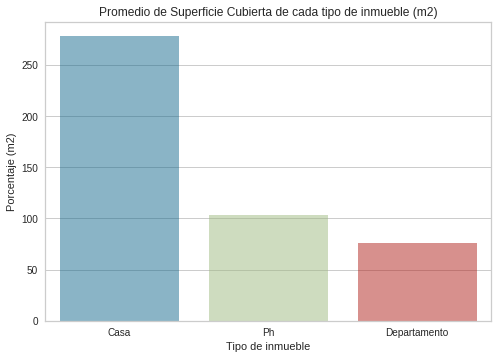

In [77]:
eje_x = ['Casa', 'Ph', 'Departamento']
eje_y = [promedio_superficie_cubierta_casa, promedio_superficie_cubierta_ph, promedio_superficie_cubierta_departamento]

sns_bar_plot=sns.barplot(x=eje_x, y=eje_y, alpha=0.5).set(title="Promedio de Superficie Cubierta de cada tipo de inmueble (m2)",ylabel='Porcentaje (m2)',xlabel='Tipo de inmueble')

In [78]:
# Trato los NaN de las columnas superficie
# Si alguna de las 2 columas es NaN, se copia el valor de la que si existe
# Si ambas son NaN, se dropea

ds_propiedades['property_surface_total'] = ds_propiedades['property_surface_total'].fillna(0)
ds_propiedades['property_surface_covered'] = ds_propiedades['property_surface_covered'].fillna(0)

ds_trabajo_train['property_surface_total'] = ds_trabajo_train['property_surface_total'].fillna(0)
ds_trabajo_train['property_surface_covered'] = ds_trabajo_train['property_surface_covered'].fillna(0)

ds_trabajo_test['property_surface_total'] = ds_trabajo_test['property_surface_total'].fillna(0)
ds_trabajo_test['property_surface_covered'] = ds_trabajo_test['property_surface_covered'].fillna(0)

def fix_superficies(ds):
  for index, row in ds.iterrows():
    if row.property_surface_total == 0:
        if row.property_surface_covered == 0:
            ds.drop(index, axis=0) # La dropeamos si ambas son 0
        else:
            ds.at[index, 'property_surface_total'] = row.property_surface_covered
    else:
        if row.property_surface_covered == 0:
          ds.at[index, 'property_surface_covered'] = row.property_surface_total

fix_superficies(ds_propiedades)
fix_superficies(ds_trabajo_test)
fix_superficies(ds_trabajo_train)

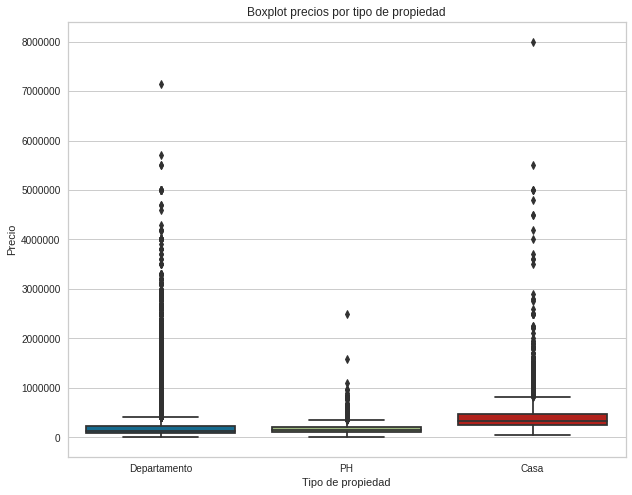

In [79]:
# Hago un boxplot de precios
plt.figure(figsize=(10,8))
plt.ticklabel_format(style='plain', axis='y')
grf=sns.boxplot(y="property_price", x="property_type", data=ds_propiedades).set(title="Boxplot precios por tipo de propiedad",xlabel="Tipo de propiedad",ylabel="Precio")

Vemos como se modificaron las distribuciones de las variables luego de trabajar con los datos faltantes y los valores atipicos

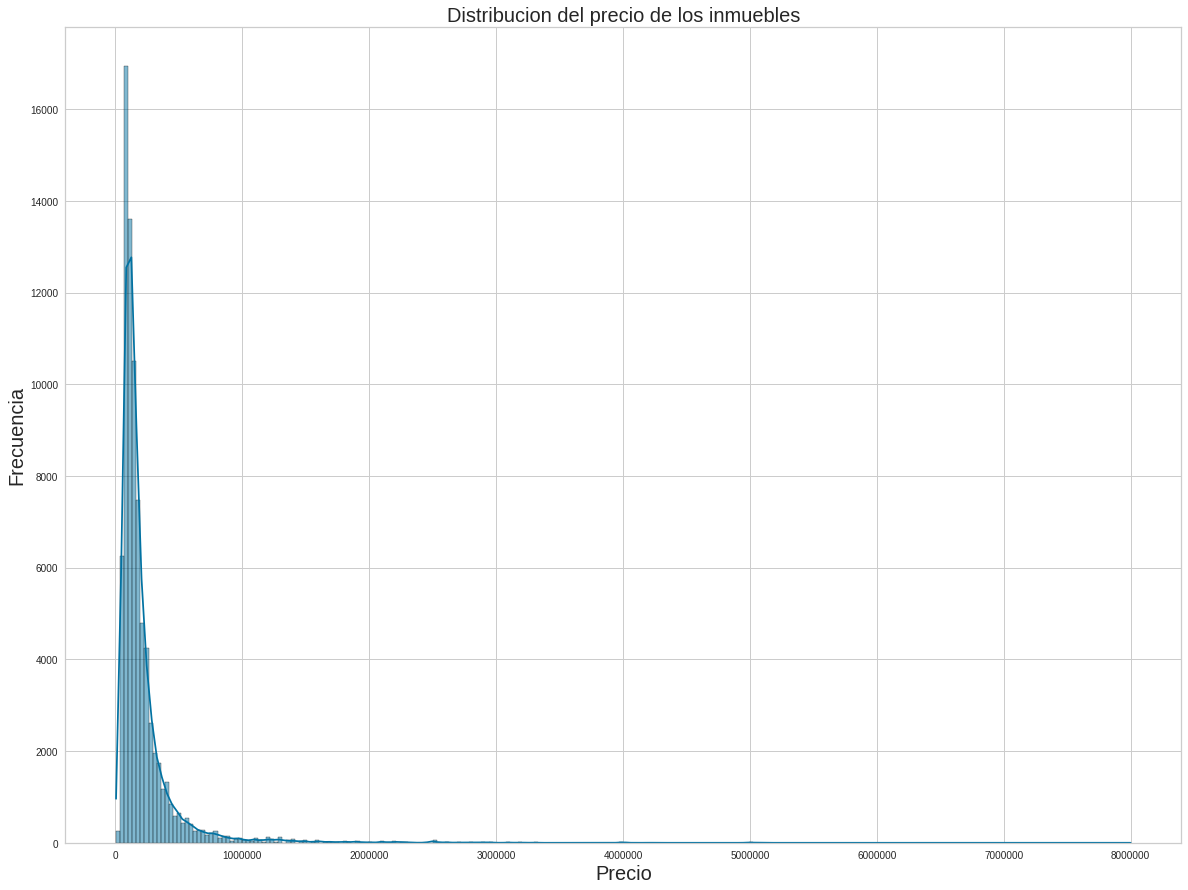

In [80]:
plt.figure(figsize=(20, 15))

plt.xlabel("Precio", fontsize = 20)
plt.ylabel("Frecuencia", fontsize = 20)
plt.ticklabel_format(style='plain', axis='x')
sns.histplot(data = ds_propiedades['property_price'],bins=250, edgecolor='black', kde=True).set_title("Distribucion del precio de los inmuebles",fontsize = 20)
plt.show()

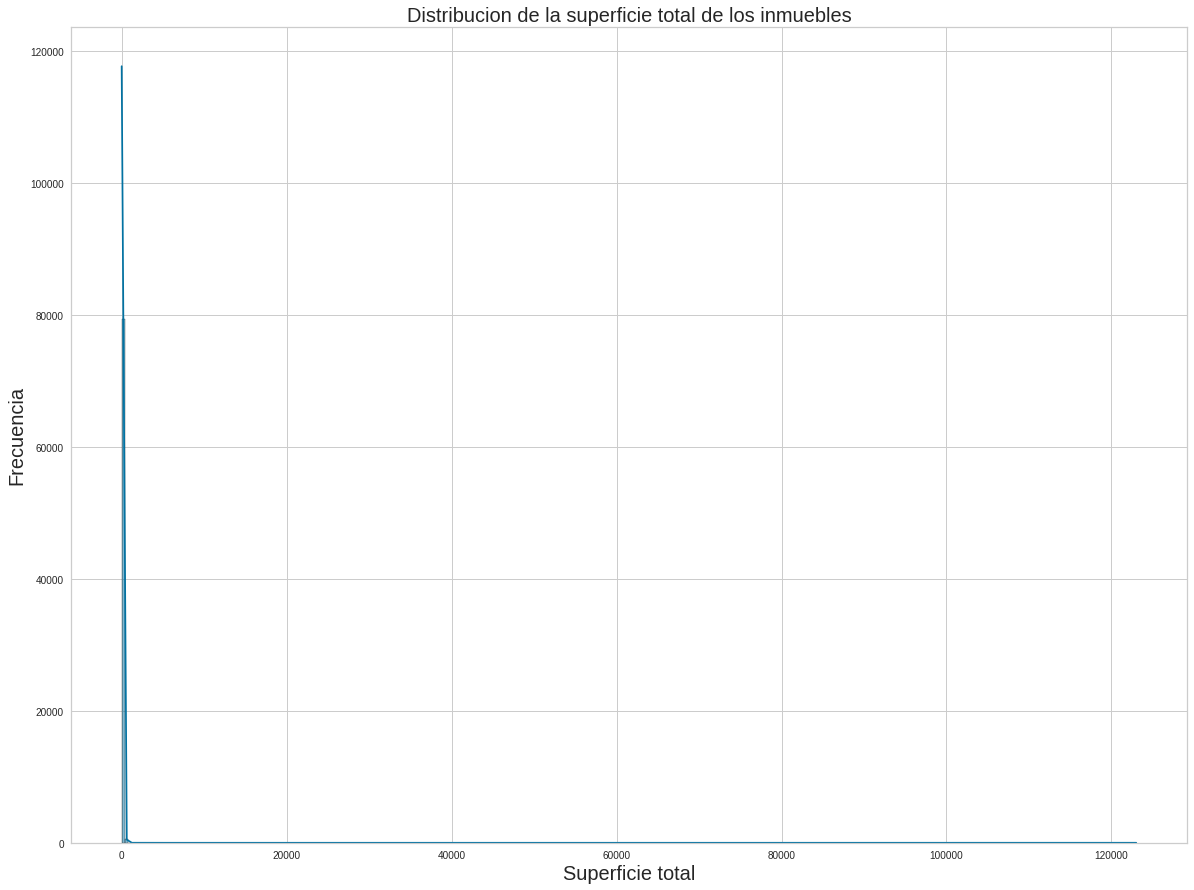

In [81]:
plt.figure(figsize=(20, 15))
plt.xlabel("Superficie total", fontsize = 20)
plt.ylabel("Frecuencia", fontsize = 20)
plt.ticklabel_format(style='plain', axis='x')
sns.histplot(data = ds_propiedades['property_surface_total'],bins=300, edgecolor='black', kde=True).set_title("Distribucion de la superficie total de los inmuebles",fontsize = 20)
plt.show()

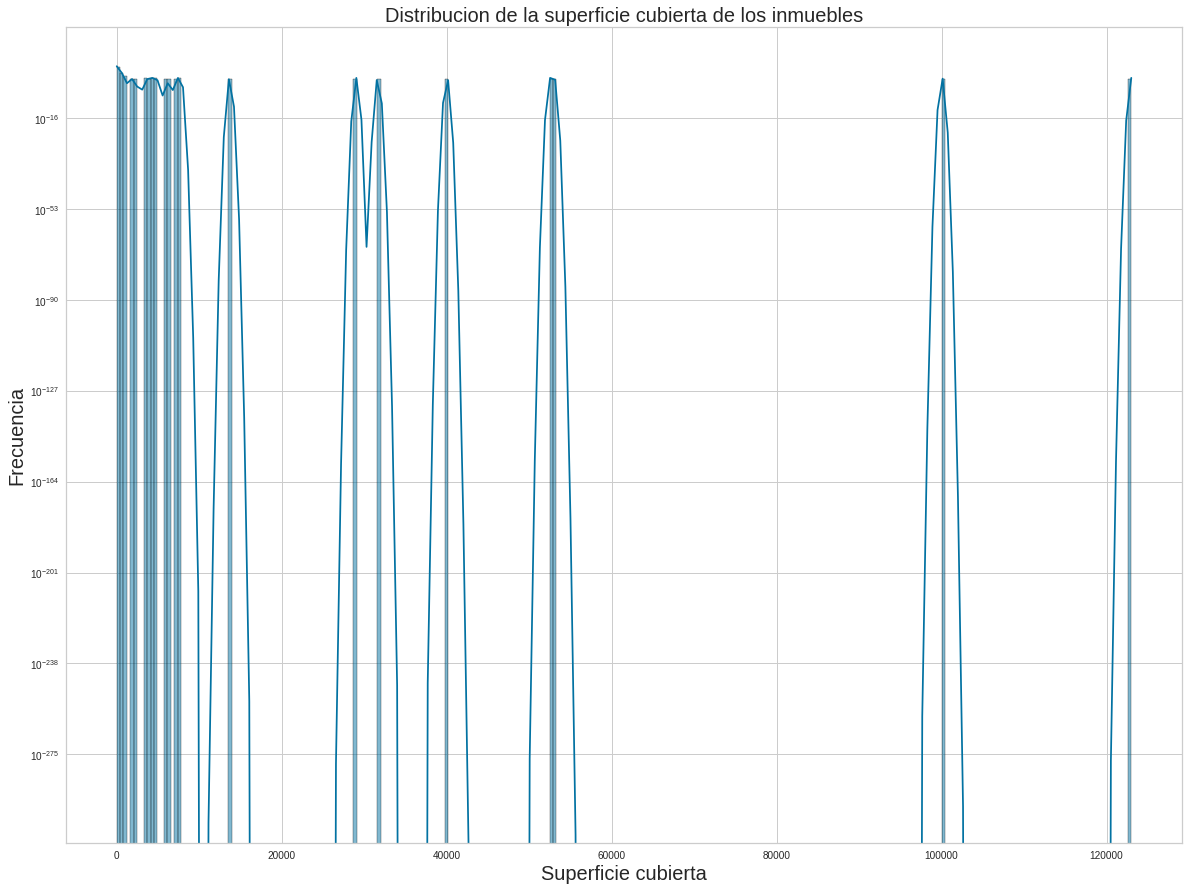

In [82]:
plt.figure(figsize=(20, 15))
plt.xlabel("Superficie cubierta", fontsize = 20)
plt.ylabel("Frecuencia", fontsize = 20)
plt.ticklabel_format(style='plain', axis='x')
plt.yscale("log")
sns.histplot(data = ds_propiedades['property_surface_covered'],bins=300, edgecolor='black', kde=True).set_title("Distribucion de la superficie cubierta de los inmuebles",fontsize = 20)
plt.show()

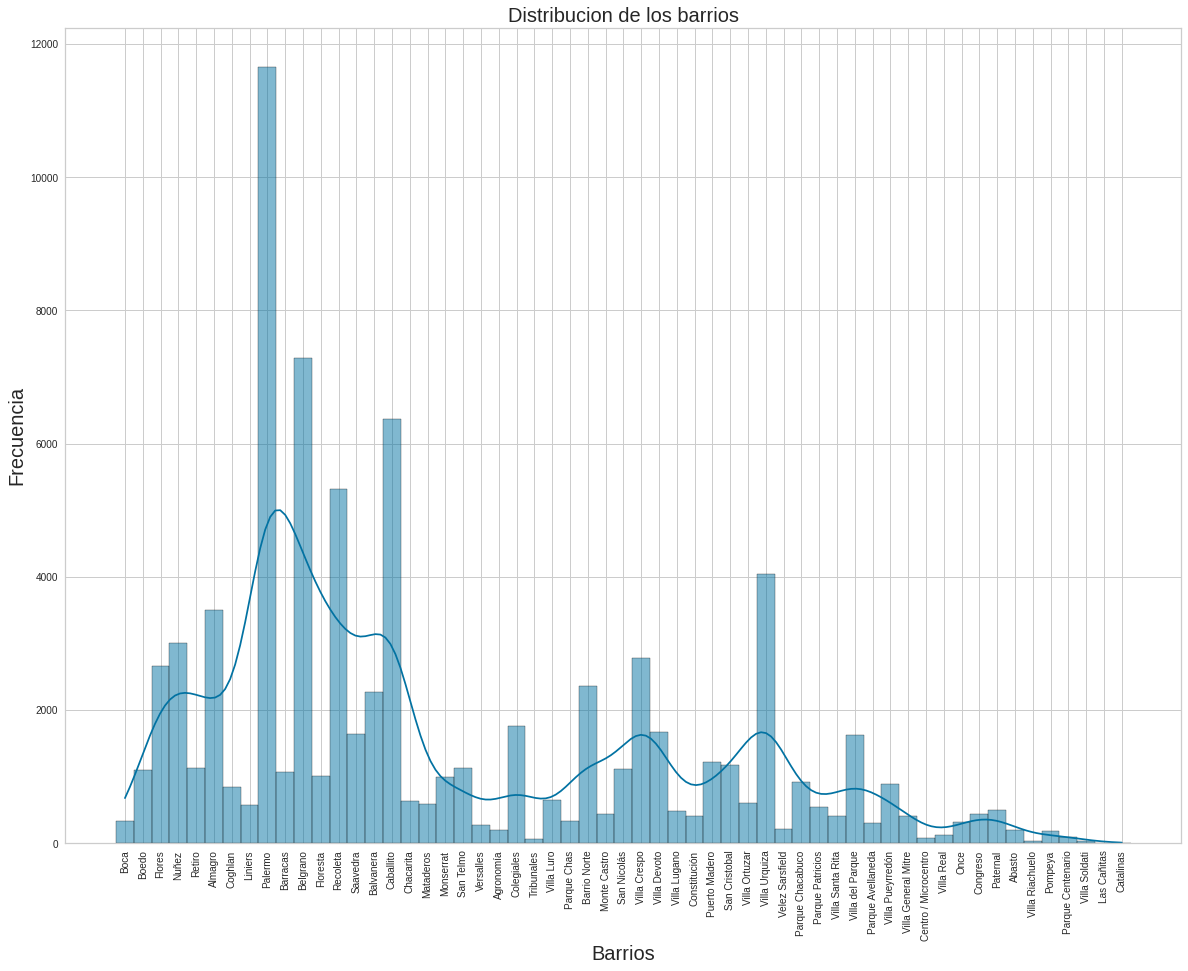

In [83]:
plt.figure(figsize=(20, 15))
plt.xlabel("Barrios", fontsize = 20)
plt.ylabel("Frecuencia", fontsize = 20)
plt.ticklabel_format(style='plain', axis='x')
plt.xticks(rotation=90)
sns.histplot(data = ds_propiedades['barrio'],bins=50, edgecolor='black', kde=True).set_title("Distribucion de los barrios",fontsize = 20)
plt.show()

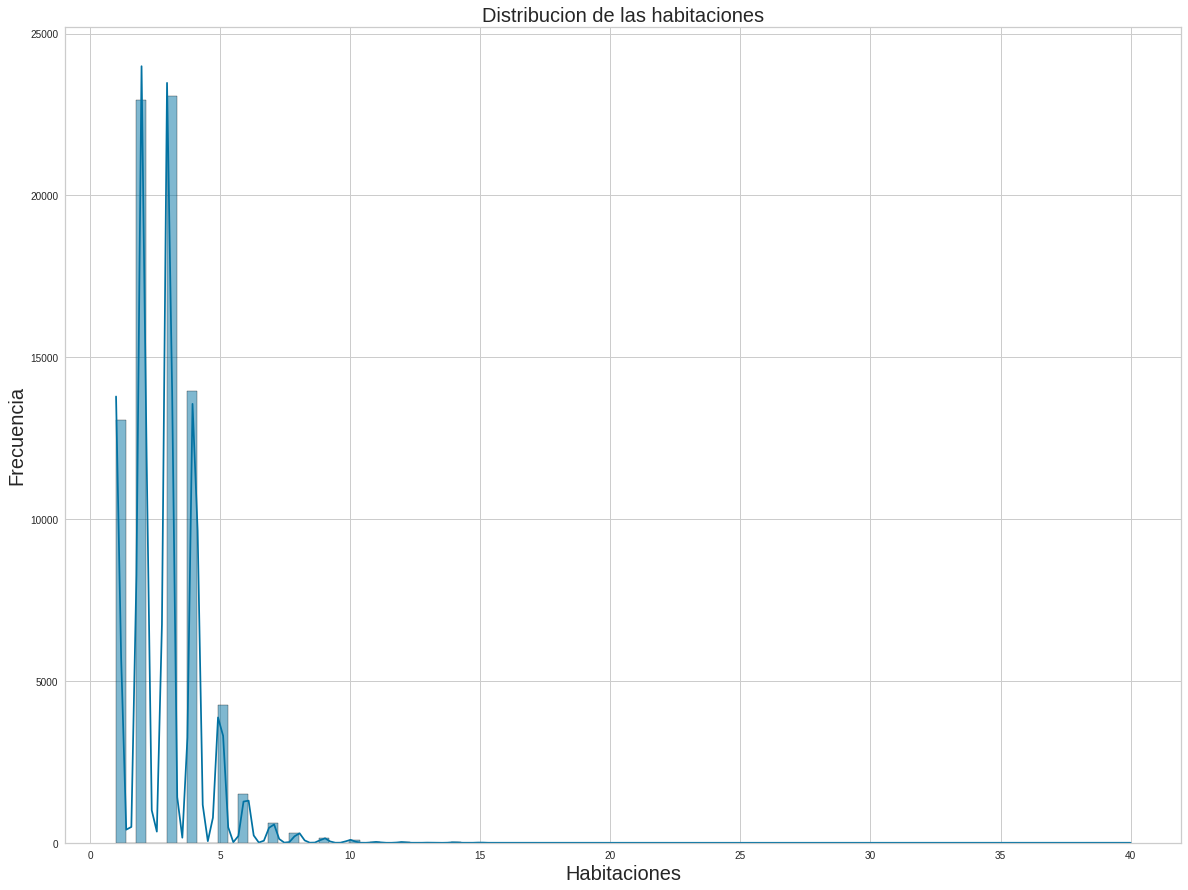

In [84]:
plt.figure(figsize=(20, 15))
plt.xlabel("Habitaciones", fontsize = 20)
plt.ylabel("Frecuencia", fontsize = 20)
plt.ticklabel_format(style='plain', axis='x')
sns.histplot(data = ds_propiedades['property_rooms'],bins=100, edgecolor='black', kde=True).set_title("Distribucion de las habitaciones",fontsize = 20)
plt.show()

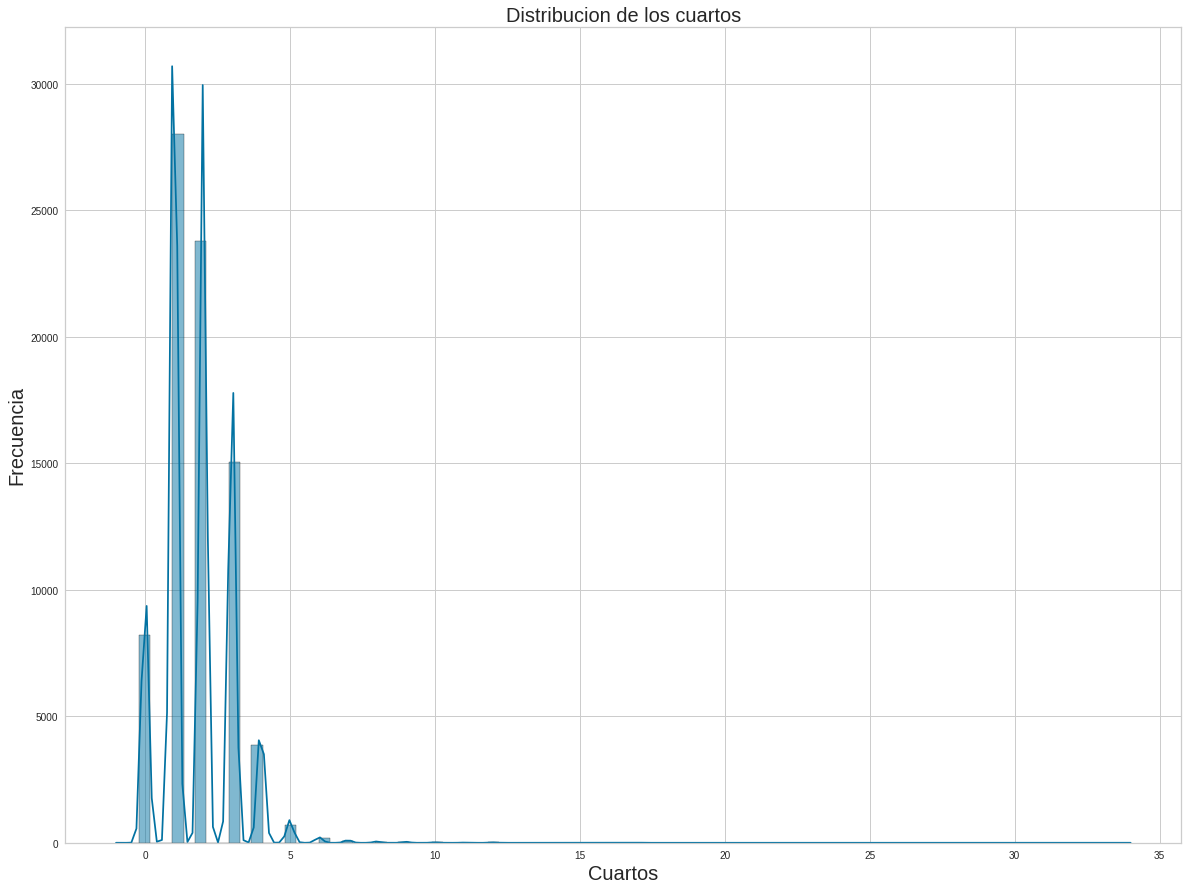

In [85]:
plt.figure(figsize=(20, 15))
plt.xlabel("Cuartos", fontsize = 20)
plt.ylabel("Frecuencia", fontsize = 20)
plt.ticklabel_format(style='plain', axis='x')

sns.histplot(data = ds_propiedades['property_bedrooms'],bins=90, edgecolor='black', kde=True).set_title("Distribucion de los cuartos",fontsize = 20)
plt.show()

Relacion entre las variables

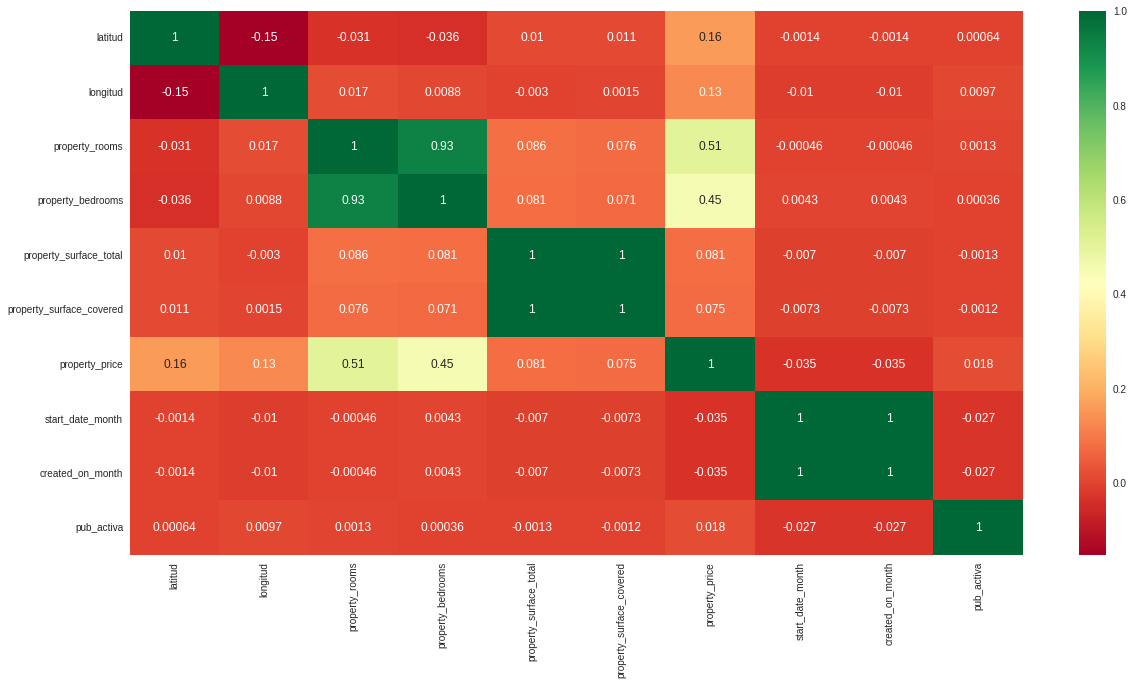

In [86]:
plt.figure(figsize=(20,10))

color = plt.get_cmap('RdYlGn') 
color.set_bad('lightblue')

sns.heatmap(ds_propiedades.corr(),annot=True, cmap = color)

# **2. Agrupamiento**

##Analisis de clusters

Preparamos el set de datos para el analisis de clusters

In [87]:
def definir_tipo_inmueble(row):
  if row.property_type == 'Departamento':
    return 0
  elif row.property_type == 'Casa':
    return 1
  else:
    return 2

ds_kmeans = ds_propiedades.copy()
ds_kmeans = ds_kmeans.assign(tipo_inmueble=0)
ds_kmeans.tipo_inmueble = ds_kmeans.apply(lambda row: definir_tipo_inmueble(row), axis=1)

Hopkins: Tendencia al clustering





In [88]:
ds_kmeans_price_m2 = ds_kmeans[['property_price', 'property_surface_total']]
ds_kmeans_lat_long = ds_kmeans[['latitud', 'longitud']].dropna()
ds_kmeans_price_type = ds_kmeans[['tipo_inmueble', 'property_price']]

In [89]:
print('Coeficiente de hopkins utilizando el precio y la superficie total de los inmuebles:', hopkins(ds_kmeans_price_m2,ds_kmeans_price_m2.shape[0]))
print('Coeficiente de hopkins utilizando la latitud y longitud de los inmuebles:', hopkins(ds_kmeans_lat_long,ds_kmeans_lat_long.shape[0]))
print('Coeficiente de hopkins utilizando el tipo y precio de los inmuebles:', hopkins(ds_kmeans_price_type,ds_kmeans_price_type.shape[0]))

Coeficiente de hopkins utilizando el precio y la superficie total de los inmuebles: 0.00031420107813406287
Coeficiente de hopkins utilizando la latitud y longitud de los inmuebles: 0.0099025186253996
Coeficiente de hopkins utilizando el tipo y precio de los inmuebles: 0.00034858046746403745


Vemos que el coeficiente de Hopkins mas alto que obtuvimos fue utilizando la latitud y longitud de los inmuebles. Con estos datos podemos agrupar los inmuebles en los distintos barrios.

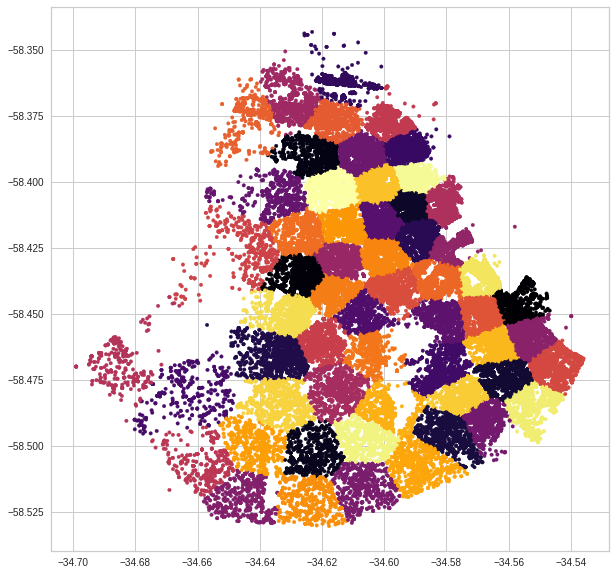

In [90]:
kmeans = KMeans(len(ds_kmeans.barrio.unique()), random_state=2456)
labels = kmeans.fit_predict(ds_kmeans_lat_long)

plt.figure(figsize=(10,10))
plt.scatter(ds_kmeans_lat_long["latitud"], ds_kmeans_lat_long["longitud"], c=labels, cmap='inferno', s=50, marker=".")
plt.show()

Calculamos el K optimo para nuestro set de datos utilizando el metodo de Elbow

In [91]:
ds_kmeans_encoded = pd.get_dummies(ds_kmeans, columns=["barrio","property_type"], drop_first=True).dropna()

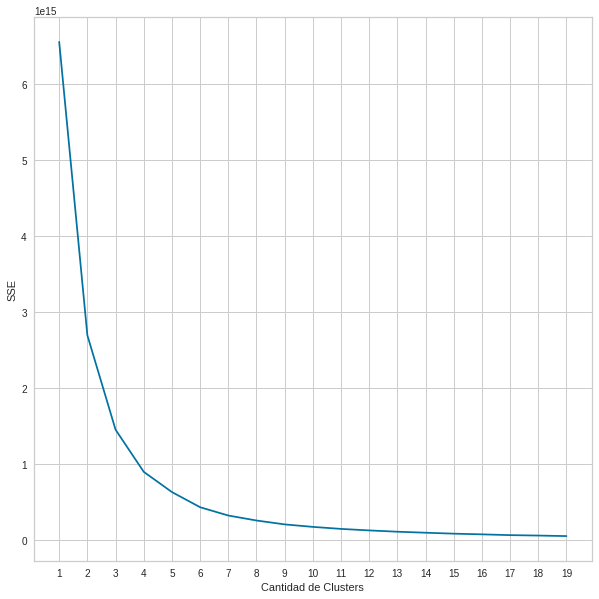

In [92]:
sse = []
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(ds_kmeans_encoded)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(10,10))
plt.plot(range(1, 20), sse)
plt.xticks(range(1, 20))
plt.xlabel("Cantidad de Clusters")
plt.ylabel("SSE")
plt.show()

Podemos observar que el numero optimo de clusters seria 3 o 4.

Indice de Silhouette

In [93]:
list_k = list(range(2, 6))

for n_clusters in list_k:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict(ds_kmeans_encoded)

    score = silhouette_score (ds_kmeans_encoded, preds)
    print ("Para K = " + str(n_clusters) + " el indice de silhouette es: " + str(score))

Para K = 2 el indice de silhouette es: 0.8894533951038158
Para K = 3 el indice de silhouette es: 0.779108062575108
Para K = 4 el indice de silhouette es: 0.7070453346310964
Para K = 5 el indice de silhouette es: 0.6462933787004381


Segun el indice de Silhouette el numero optimo de clusters es 2.

Agregamos al dataset una columna para indicar a que cluster pertenece cada fila.

In [94]:
ds_kmeans_surface_filter = ds_kmeans_encoded[ds_kmeans_encoded.property_surface_total < 2000]
kmeans = KMeans(random_state=0)

kmeans.fit(ds_kmeans_surface_filter) 

clusters_labels = kmeans.predict(ds_kmeans_surface_filter)

ds_kmeans_surface_filter['cluster_label'] = clusters_labels

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


##Graficos de algunos agrupamientos

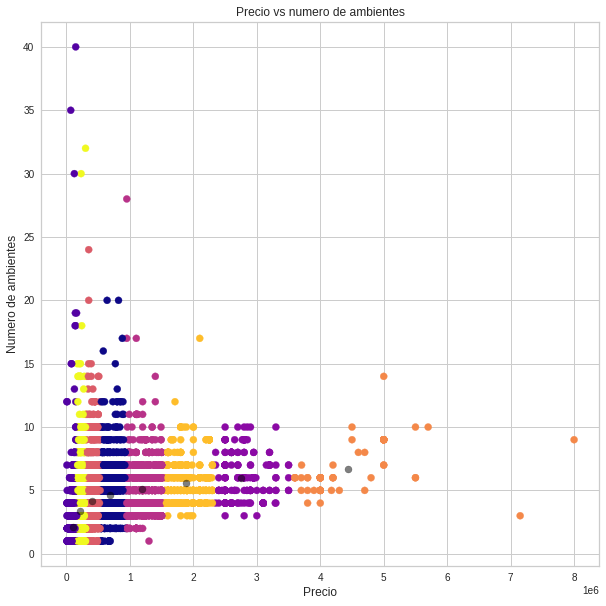

In [95]:
plt.figure(figsize=(10,10))
plt.title('Precio vs numero de ambientes', fontsize = 12)
plt.xlabel("Precio", fontsize = 12)
plt.ylabel("Numero de ambientes", fontsize = 12)
plt.scatter(ds_kmeans_surface_filter.property_price, ds_kmeans_surface_filter.property_rooms, c=clusters_labels, s=50, cmap='plasma')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 6], centers[:, 2], c='black', s=200, alpha=0.5,marker='.')
plt.show()

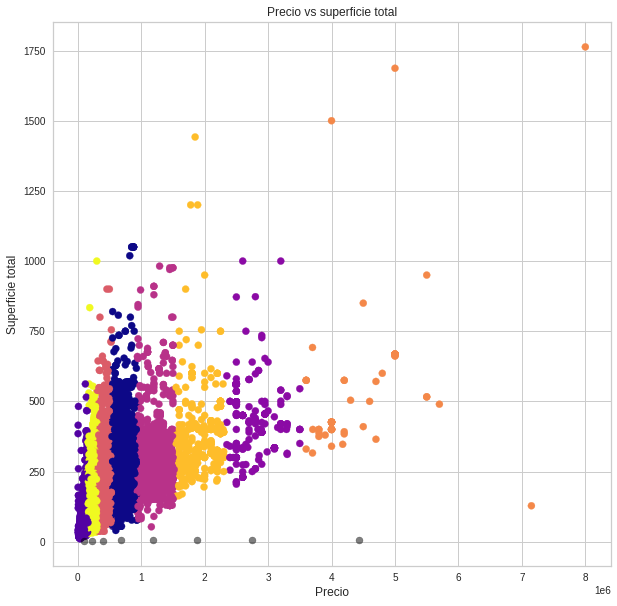

In [96]:
plt.figure(figsize=(10,10))
plt.title('Precio vs superficie total', fontsize = 12)
plt.xlabel("Precio", fontsize = 12)
plt.ylabel("Superficie total", fontsize = 12)
plt.scatter(ds_kmeans_surface_filter.property_price, ds_kmeans_surface_filter.property_surface_total, c=clusters_labels, s=50, cmap='plasma')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 6], centers[:, 2], c='black', s=200, alpha=0.5,marker='.')
plt.show()

En ambos graficos vemos que la separacion de los clusters se hacen en funcion del precio de los inmuebles

## Mapa de CABA

Ahora vamos a graficar en el mapa de CABA cada uno de los inmuebles indicando a que cluster pertenecen.

In [97]:
kmeans = KMeans(random_state=0)

kmeans.fit(ds_kmeans_encoded) 

clusters_labels = kmeans.predict(ds_kmeans_encoded)

ds_kmeans_encoded['cluster_label'] = clusters_labels

In [98]:
poly = gp.read_file('https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-educacion/barrios/barrios.geojson')
poly.head(5)

BARRIO  COMUNA    PERIMETRO          AREA  OBJETO  \
0         CHACARITA    15.0  7724.852955  3.115707e+06  BARRIO   
1          PATERNAL    15.0  7087.513295  2.229829e+06  BARRIO   
2      VILLA CRESPO    15.0  8131.857075  3.615978e+06  BARRIO   
3  VILLA DEL PARQUE    11.0  7705.389797  3.399596e+06  BARRIO   
4           ALMAGRO     5.0  8537.901368  4.050752e+06  BARRIO   

                                            geometry  
0  MULTIPOLYGON (((-58.45282 -34.59599, -58.45366...  
1  MULTIPOLYGON (((-58.46558 -34.59656, -58.46562...  
2  MULTIPOLYGON (((-58.42375 -34.59783, -58.42495...  
3  MULTIPOLYGON (((-58.49461 -34.61487, -58.49479...  
4  MULTIPOLYGON (((-58.41287 -34.61412, -58.41282...

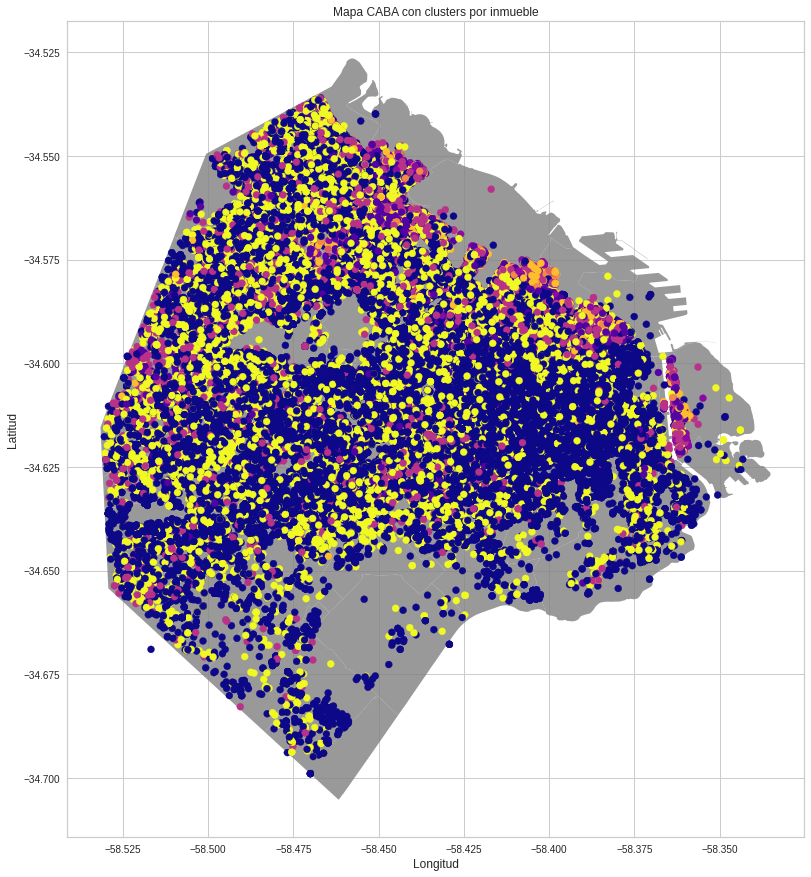

In [99]:
fig, ax = plt.subplots(figsize=(15,15))
plt.title('Mapa CABA con clusters por inmueble', fontsize = 12)
plt.xlabel("Longitud", fontsize = 12)
plt.ylabel("Latitud", fontsize = 12)
poly.plot(ax=ax,alpha=0.8, color="grey")
plt.scatter(ds_kmeans_encoded.longitud,ds_kmeans_encoded.latitud,c=clusters_labels, cmap="plasma")

plt.show()

## Analisis para K = 3

In [100]:
ds_kmeans_surface_filter = ds_kmeans_encoded[ds_kmeans_encoded.property_surface_total < 2000]
kmeans = KMeans(n_clusters = 3, random_state=0)

kmeans.fit(ds_kmeans_surface_filter) 

clusters_labels = kmeans.predict(ds_kmeans_surface_filter)

ds_kmeans_surface_filter['cluster_label'] = clusters_labels

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


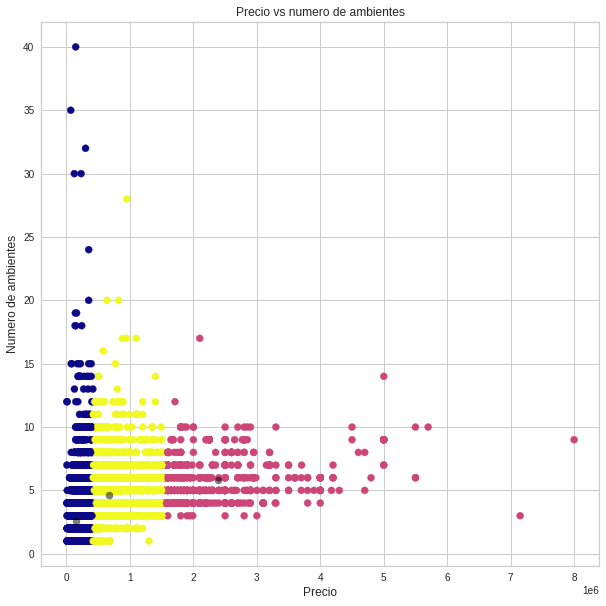

In [101]:
plt.figure(figsize=(10,10))
plt.title('Precio vs numero de ambientes', fontsize = 12)
plt.xlabel("Precio", fontsize = 12)
plt.ylabel("Numero de ambientes", fontsize = 12)
plt.scatter(ds_kmeans_surface_filter.property_price, ds_kmeans_surface_filter.property_rooms, c=clusters_labels, s=50, cmap='plasma')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 6], centers[:, 2], c='black', s=200, alpha=0.5,marker='.')
plt.show()

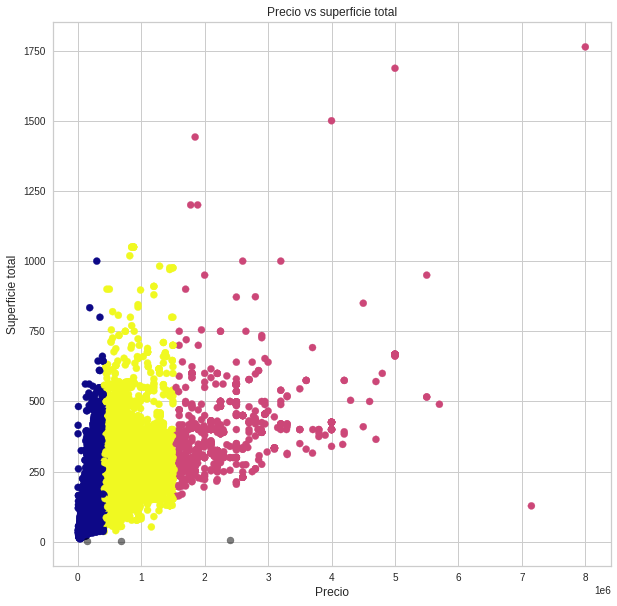

In [102]:
plt.figure(figsize=(10,10))
plt.title('Precio vs superficie total', fontsize = 12)
plt.xlabel("Precio", fontsize = 12)
plt.ylabel("Superficie total", fontsize = 12)
plt.scatter(ds_kmeans_surface_filter.property_price, ds_kmeans_surface_filter.property_surface_total, c=clusters_labels, s=50, cmap='plasma')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 6], centers[:, 2], c='black', s=200, alpha=0.5,marker='.')
plt.show()

Mapa de CABA

In [103]:
kmeans = KMeans(n_clusters = 3, random_state=0)

kmeans.fit(ds_kmeans_encoded) 

clusters_labels = kmeans.predict(ds_kmeans_encoded)

ds_kmeans_encoded['cluster_label'] = clusters_labels

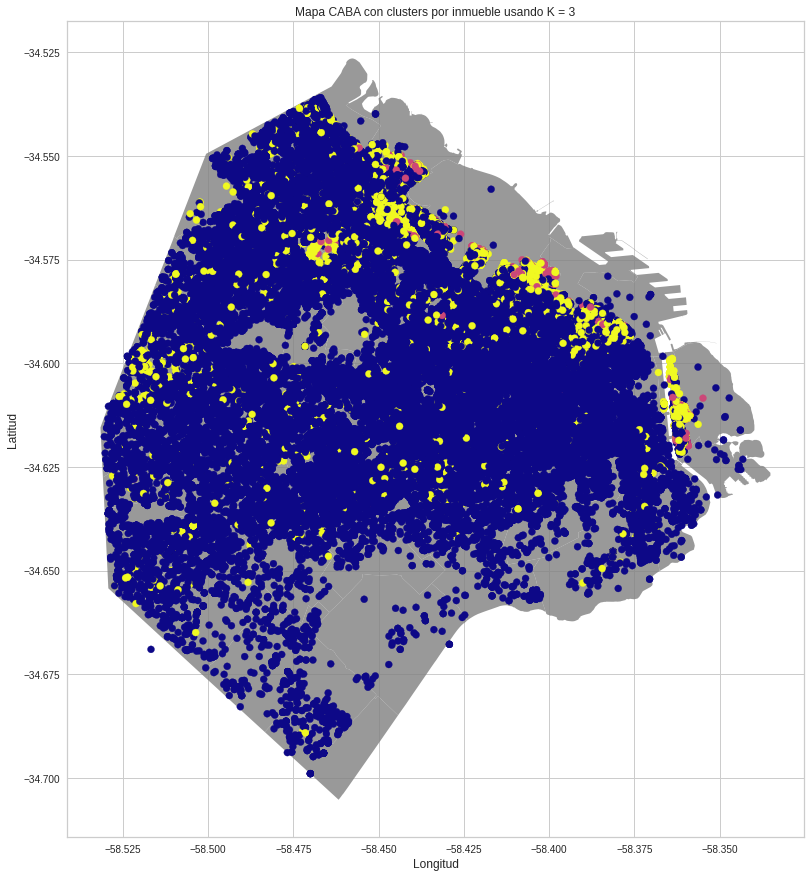

In [104]:
fig, ax = plt.subplots(figsize=(15,15))
plt.title('Mapa CABA con clusters por inmueble usando K = 3', fontsize = 12)
plt.xlabel("Longitud", fontsize = 12)
plt.ylabel("Latitud", fontsize = 12)
poly.plot(ax=ax,alpha=0.8, color="grey")
plt.scatter(ds_kmeans_encoded.longitud,ds_kmeans_encoded.latitud,c=clusters_labels, cmap="plasma")

plt.show()

# **3. Clasificacion y contruccion del target**

In [105]:
ds_propiedades["precio_metro_cuadrado"] = ds_propiedades["property_price"] / ds_propiedades["property_surface_total"]
ds_propiedades.drop(['property_price', 'property_surface_total'], axis = 1, inplace = True)

ds_trabajo_test["precio_metro_cuadrado"] = ds_trabajo_test["property_price"] / ds_trabajo_test["property_surface_total"]

ds_trabajo_train["precio_metro_cuadrado"] = ds_trabajo_train["property_price"] / ds_trabajo_train["property_surface_total"]


1. Dividimos la variable pxm2 en 3 intervalos con igual cantidad de observaciones.

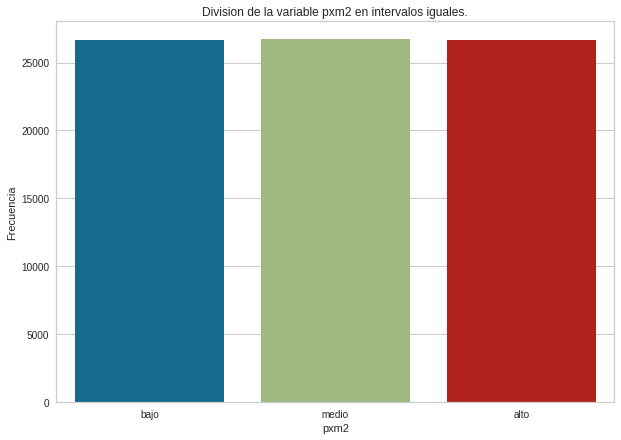

In [106]:
pxm2_general = ds_propiedades.copy()
pxm2_general = pxm2_general.assign(tipo_precio = pd.qcut(pxm2_general['precio_metro_cuadrado'], 3, labels=["bajo", "medio", "alto"]))

plt.figure(figsize=(10,7))
sns.countplot(pxm2_general['tipo_precio']).set(title='Division de la variable pxm2 en intervalos iguales.',ylabel='Frecuencia',xlabel='pxm2')
plt.show()

2. Dividimos la variable pxm2 en 3 intervalos, el primero con el 25% de las observaciones,
el siguiente con el 50% y el último con el 25% de las observaciones restantes.

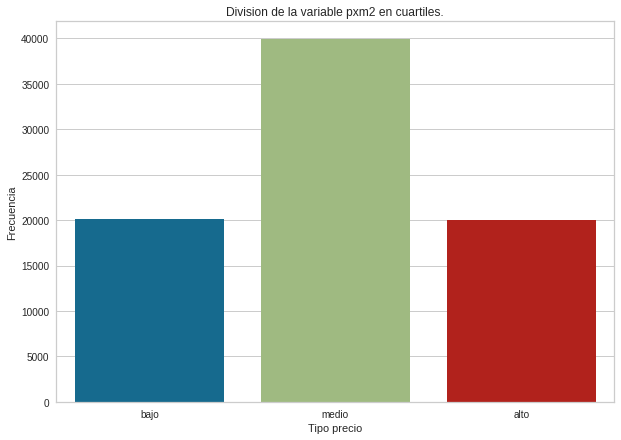

In [107]:
pxm2_general_cuartiles = ds_propiedades.copy()
pxm2_general_cuartiles = pxm2_general_cuartiles.assign(tipo_precio = pd.qcut(pxm2_general_cuartiles['precio_metro_cuadrado'], [0,0.25,0.75,1], labels=["bajo", "medio", "alto"]))

plt.figure(figsize=(10,7))
sns.countplot(pxm2_general_cuartiles['tipo_precio']).set(title='Division de la variable pxm2 en cuartiles.',ylabel='Frecuencia',xlabel='Tipo precio')
plt.show()

3. Variable pxm2 relativa a cada tipo de propiedad y luego dividirla como en
el punto anterior.

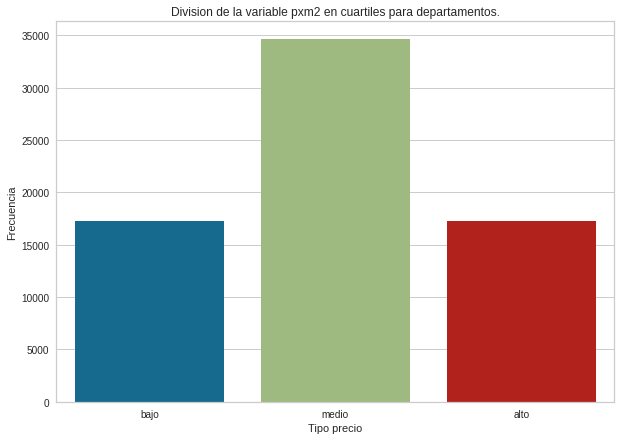

In [108]:
pxm2_general_cuartiles_depto = ds_propiedades.loc[ds_propiedades["property_type"]=="Departamento"]
pxm2_general_cuartiles_depto = pxm2_general_cuartiles_depto.assign(tipo_precio = pd.qcut(pxm2_general_cuartiles_depto['precio_metro_cuadrado'], [0,0.25,0.75,1], labels=["bajo", "medio", "alto"]))

plt.figure(figsize=(10,7))
sns.countplot(pxm2_general_cuartiles_depto['tipo_precio']).set(title='Division de la variable pxm2 en cuartiles para departamentos.',ylabel='Frecuencia',xlabel='Tipo precio')
plt.show()

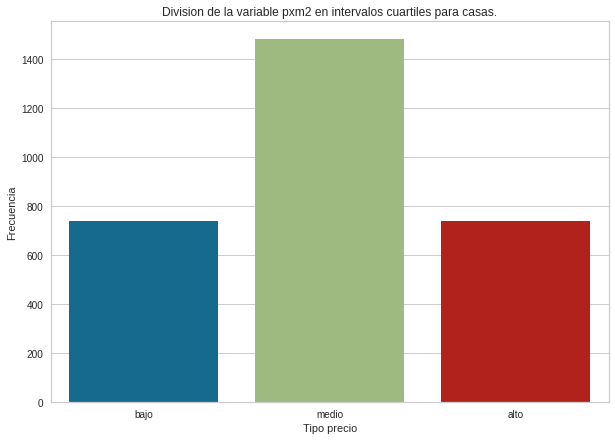

In [109]:
pxm2_general_cuartiles_casa = ds_propiedades.loc[ds_propiedades["property_type"]=="Casa"]
pxm2_general_cuartiles_casa = pxm2_general_cuartiles_casa.assign(tipo_precio = pd.qcut(pxm2_general_cuartiles_casa['precio_metro_cuadrado'], [0,0.25,0.75,1], labels=["bajo", "medio", "alto"]))

plt.figure(figsize=(10,7))
sns.countplot(pxm2_general_cuartiles_casa['tipo_precio']).set(title='Division de la variable pxm2 en intervalos cuartiles para casas.',ylabel='Frecuencia',xlabel='Tipo precio')
plt.show()

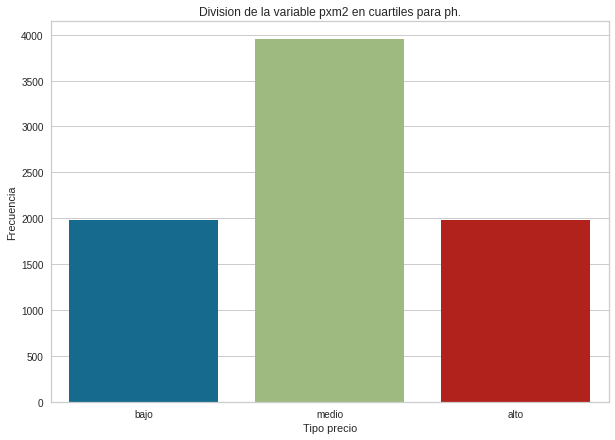

In [110]:
pxm2_general_cuartiles_ph = ds_propiedades.loc[ds_propiedades["property_type"]=="PH"]
pxm2_general_cuartiles_ph = pxm2_general_cuartiles_ph.assign(tipo_precio = pd.qcut(pxm2_general_cuartiles_ph['precio_metro_cuadrado'], [0,0.25,0.75,1], labels=["bajo", "medio", "alto"]))

plt.figure(figsize=(10,7))
sns.countplot(pxm2_general_cuartiles_ph['tipo_precio']).set(title='Division de la variable pxm2 en cuartiles para ph.',ylabel='Frecuencia',xlabel='Tipo precio')
plt.show()

Distribucion del precio por metro cuadrado en el data set general

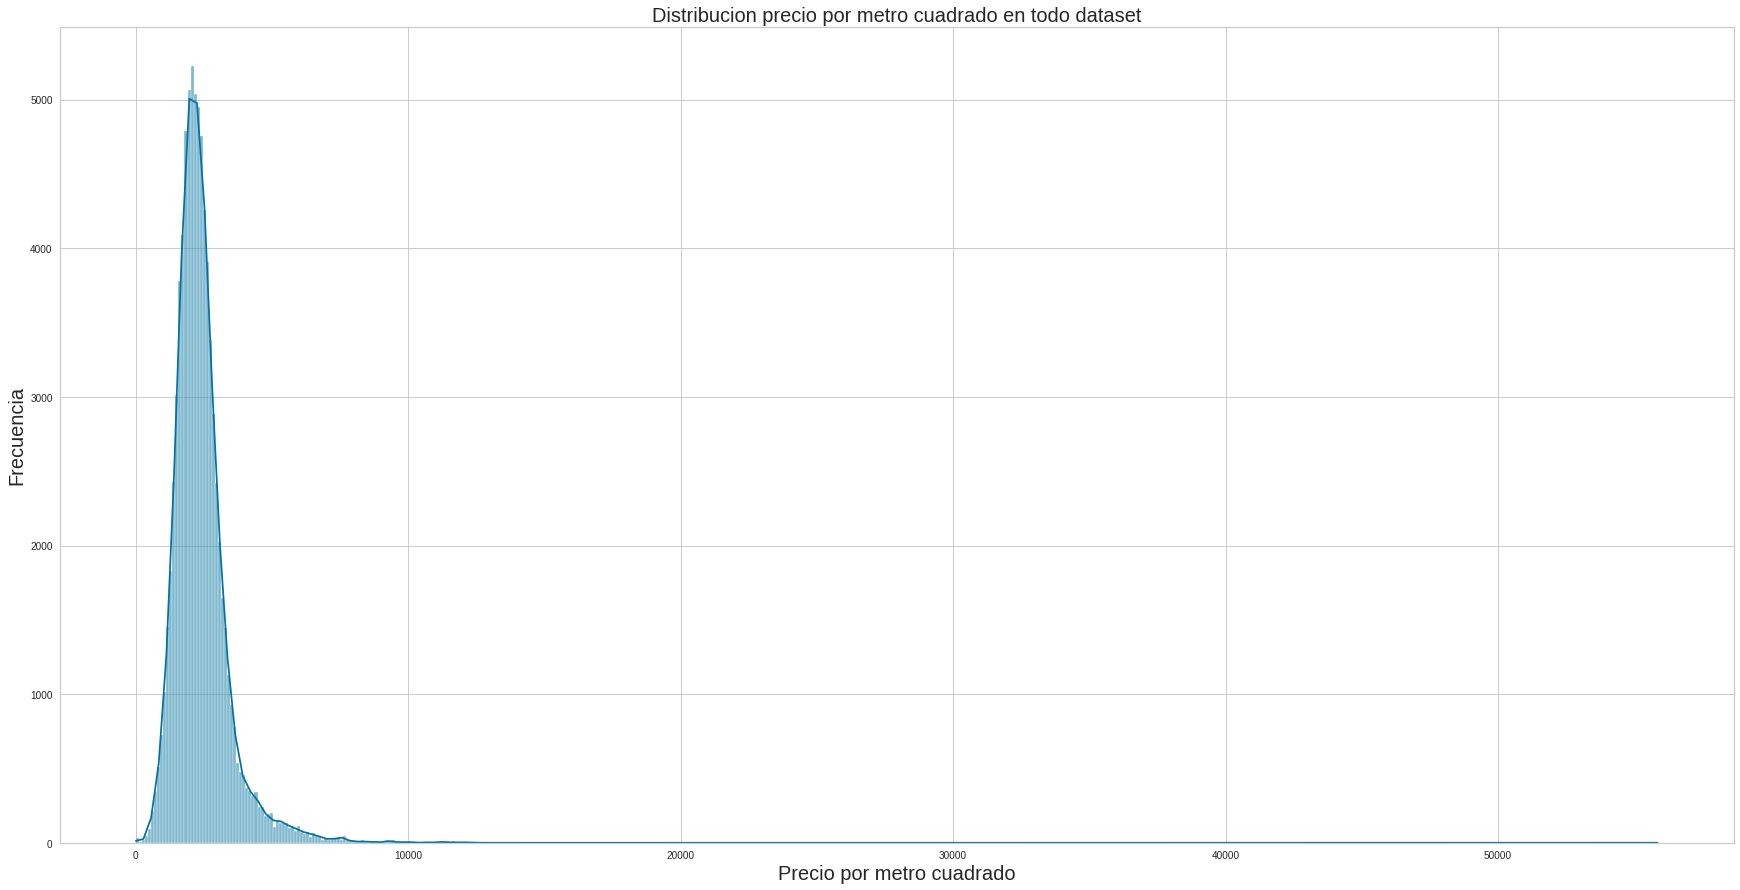

In [111]:
plt.figure(figsize=(30, 15))
plt.xlabel("Precio por metro cuadrado", fontsize = 20)
plt.ylabel("Frecuencia", fontsize = 20)
sns.histplot(data = pxm2_general['precio_metro_cuadrado'],bins=500, edgecolor='white', kde=True).set_title("Distribucion precio por metro cuadrado en todo dataset",fontsize = 20)
plt.show()

Distribucion del precio por metro cuadrado en casas

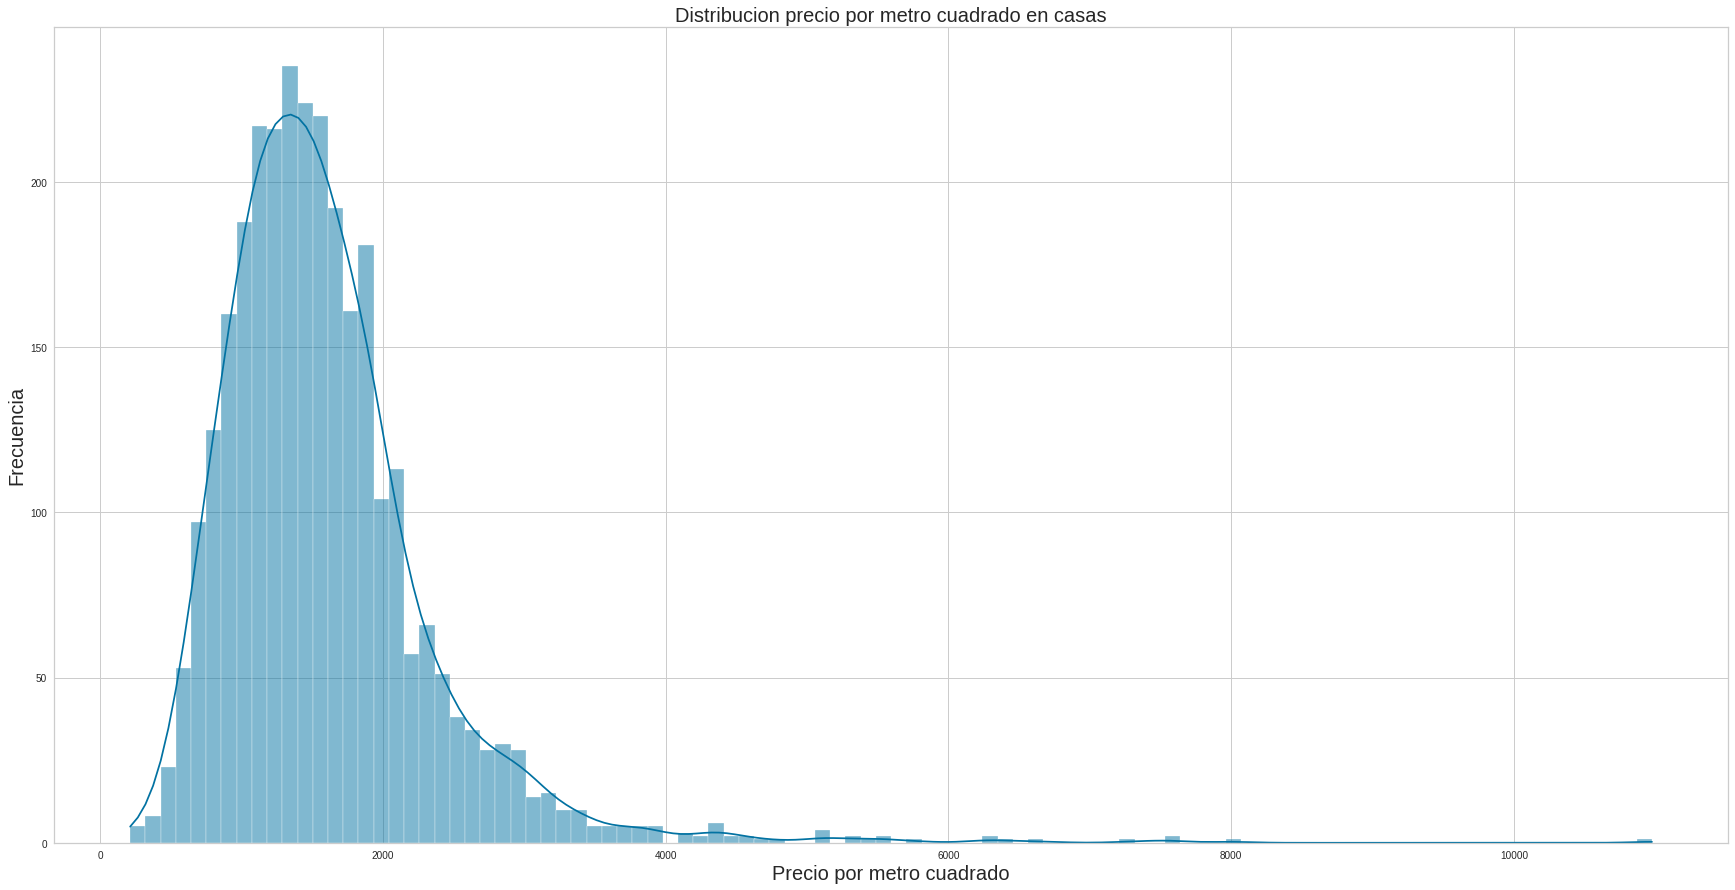

In [112]:
plt.figure(figsize=(30, 15))
plt.xlabel("Precio por metro cuadrado", fontsize = 20)
plt.ylabel("Frecuencia", fontsize = 20)
sns.histplot(data =pxm2_general_cuartiles_casa['precio_metro_cuadrado'],bins=100, edgecolor='white', kde=True).set_title("Distribucion precio por metro cuadrado en casas",fontsize = 20)
plt.show()

Distribucion del precio por metro cuadrado en departamentos

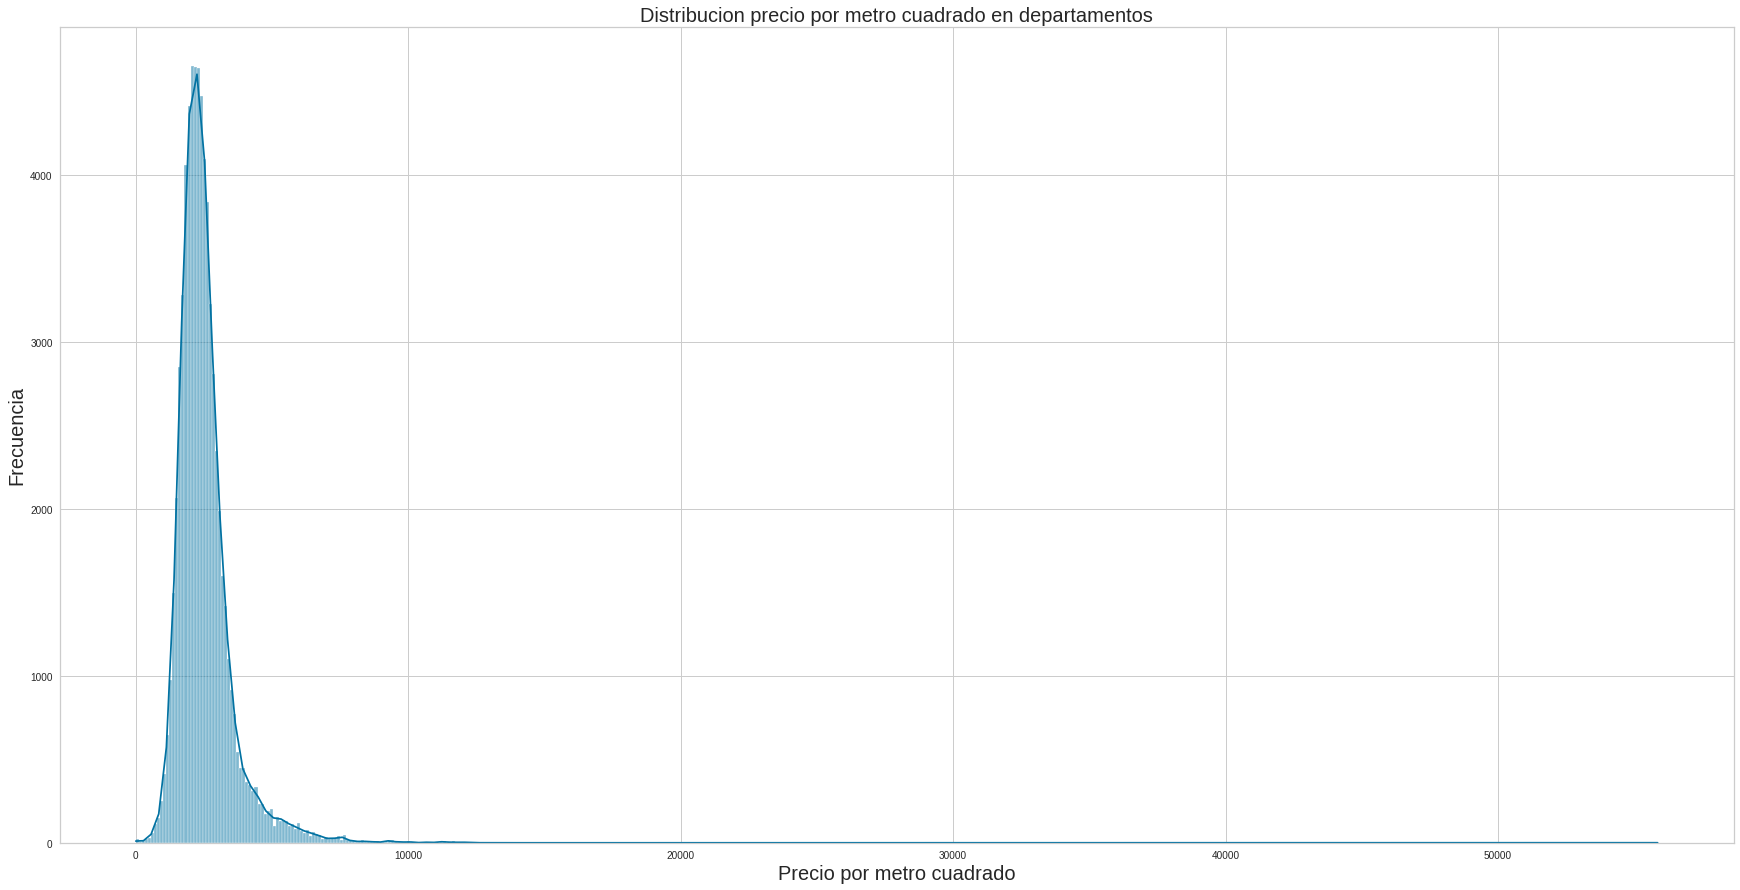

In [113]:
plt.figure(figsize=(30, 15))
plt.xlabel("Precio por metro cuadrado", fontsize = 20)
plt.ylabel("Frecuencia", fontsize = 20)
sns.histplot(data =pxm2_general_cuartiles_depto['precio_metro_cuadrado'],bins=500, edgecolor='white',kde=True).set_title("Distribucion precio por metro cuadrado en departamentos",fontsize = 20)
plt.show()

Distribucion del precio por metro cuadrado en ph

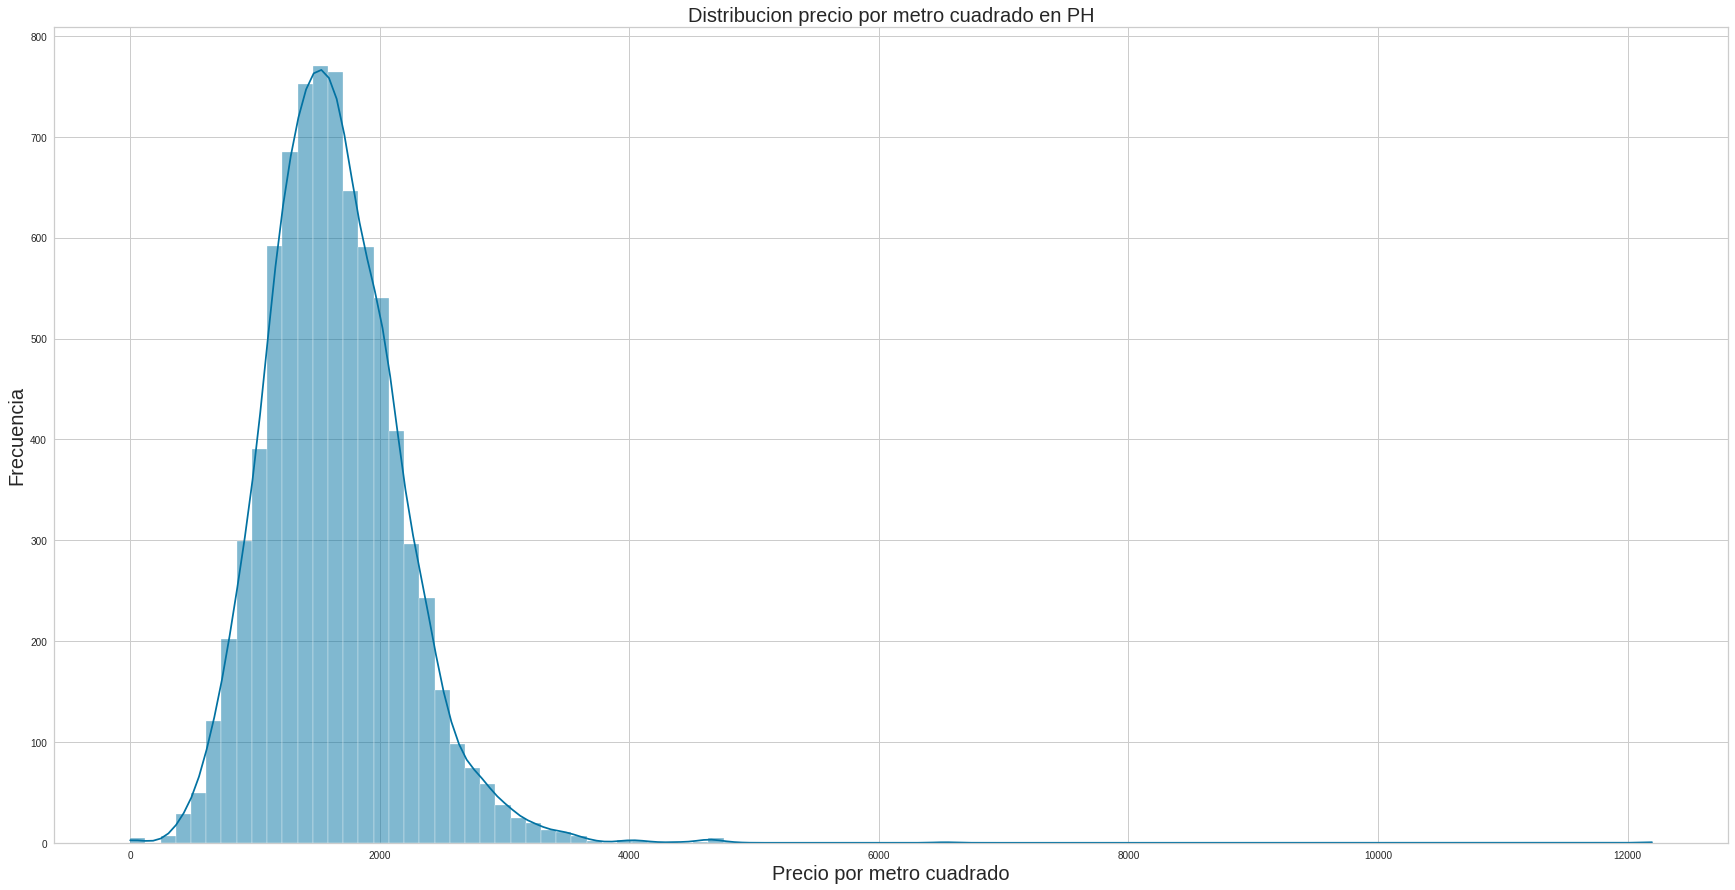

In [114]:
plt.figure(figsize=(30, 15))
plt.xlabel("Precio por metro cuadrado", fontsize = 20)
plt.ylabel("Frecuencia", fontsize = 20)
sns.histplot(data = pxm2_general_cuartiles_ph['precio_metro_cuadrado'],bins=100, edgecolor='white', kde=True).set_title("Distribucion precio por metro cuadrado en PH",fontsize = 20)
plt.show()

Creemos que la mejor alternativa es la tercera, asi podemos tener los precios relacionados con el tipo de propiedad ya que es un factor muy influyente.
Ademas vamos a optar por tener una distribucion equitativa de la variable tipo_precio asi el data set estara balanceado.

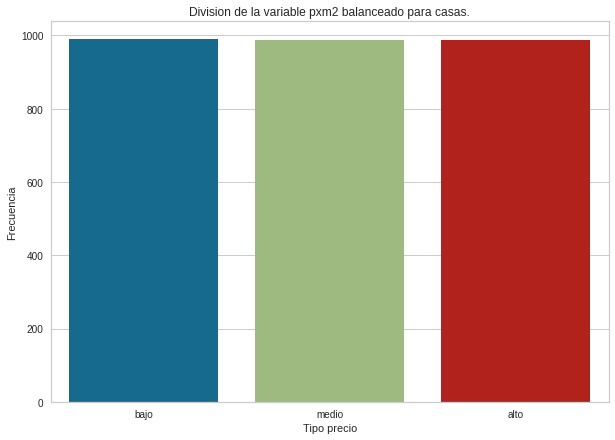

In [115]:
pxm2_casa_balanceado = ds_propiedades.loc[ds_propiedades["property_type"]=="Casa"]
pxm2_casa_balanceado = pxm2_casa_balanceado.assign(tipo_precio = pd.qcut(pxm2_casa_balanceado['precio_metro_cuadrado'], 3, labels=["bajo", "medio", "alto"]))

pxm2_casa_balanceado_test = ds_trabajo_test.loc[ds_trabajo_test["property_type"]=="Casa"]
pxm2_casa_balanceado_test = pxm2_casa_balanceado_test.assign(tipo_precio = pd.qcut(pxm2_casa_balanceado_test['precio_metro_cuadrado'], 3, labels=["bajo", "medio", "alto"]))

pxm2_casa_balanceado_train = ds_trabajo_train.loc[ds_trabajo_train["property_type"]=="Casa"]
pxm2_casa_balanceado_train = pxm2_casa_balanceado_train.assign(tipo_precio = pd.qcut(pxm2_casa_balanceado_train['precio_metro_cuadrado'], 3, labels=["bajo", "medio", "alto"]))

plt.figure(figsize=(10,7))
sns.countplot(pxm2_casa_balanceado['tipo_precio']).set(title='Division de la variable pxm2 balanceado para casas.',ylabel='Frecuencia',xlabel='Tipo precio')
plt.show()

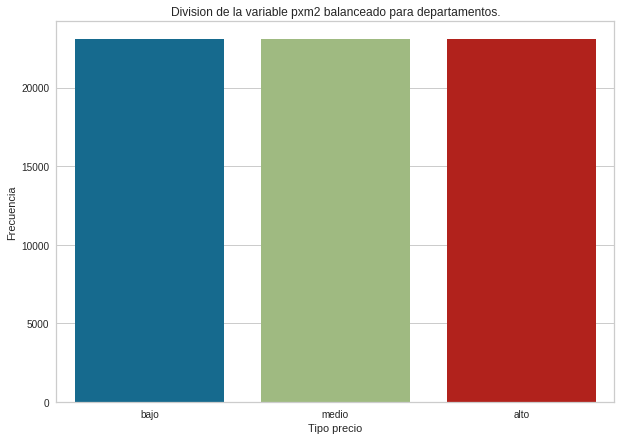

In [116]:
pxm2_depto_balanceado = ds_propiedades.loc[ds_propiedades["property_type"]=="Departamento"]
pxm2_depto_balanceado = pxm2_depto_balanceado.assign(tipo_precio = pd.qcut(pxm2_depto_balanceado['precio_metro_cuadrado'], 3, labels=["bajo", "medio", "alto"]))

pxm2_depto_balanceado_test = ds_trabajo_test.loc[ds_trabajo_test["property_type"]=="Departamento"]
pxm2_depto_balanceado_test = pxm2_depto_balanceado_test.assign(tipo_precio = pd.qcut(pxm2_depto_balanceado_test['precio_metro_cuadrado'], 3, labels=["bajo", "medio", "alto"]))

pxm2_depto_balanceado_train = ds_trabajo_train.loc[ds_trabajo_train["property_type"]=="Departamento"]
pxm2_depto_balanceado_train = pxm2_depto_balanceado_train.assign(tipo_precio = pd.qcut(pxm2_depto_balanceado_train['precio_metro_cuadrado'], 3, labels=["bajo", "medio", "alto"]))

plt.figure(figsize=(10,7))
sns.countplot(pxm2_depto_balanceado['tipo_precio']).set(title='Division de la variable pxm2 balanceado para departamentos.',ylabel='Frecuencia',xlabel='Tipo precio')
plt.show()

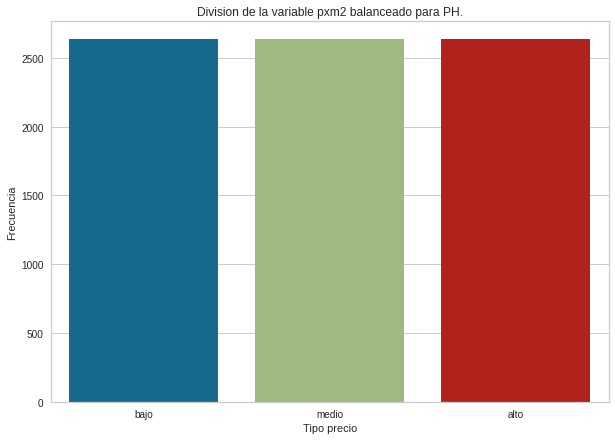

In [117]:
pxm2_ph_balanceado = ds_propiedades.loc[ds_propiedades["property_type"]=="PH"]
pxm2_ph_balanceado = pxm2_ph_balanceado.assign(tipo_precio = pd.qcut(pxm2_ph_balanceado['precio_metro_cuadrado'], 3, labels=["bajo", "medio", "alto"]))

pxm2_ph_balanceado_test = ds_trabajo_test.loc[ds_trabajo_test["property_type"]=="PH"]
pxm2_ph_balanceado_test = pxm2_ph_balanceado_test.assign(tipo_precio = pd.qcut(pxm2_ph_balanceado_test['precio_metro_cuadrado'], 3, labels=["bajo", "medio", "alto"]))

pxm2_ph_balanceado_train = ds_trabajo_train.loc[ds_trabajo_train["property_type"]=="PH"]
pxm2_ph_balanceado_train = pxm2_ph_balanceado_train.assign(tipo_precio = pd.qcut(pxm2_ph_balanceado_train['precio_metro_cuadrado'], 3, labels=["bajo", "medio", "alto"]))

plt.figure(figsize=(10,7))
sns.countplot(pxm2_ph_balanceado['tipo_precio']).set(title='Division de la variable pxm2 balanceado para PH.',ylabel='Frecuencia',xlabel='Tipo precio')
plt.show()

In [118]:
ds_propiedades.loc[pxm2_casa_balanceado.index,"tipo_precio"] = pxm2_casa_balanceado["tipo_precio"] 
ds_propiedades.loc[pxm2_depto_balanceado.index,"tipo_precio"] = pxm2_depto_balanceado["tipo_precio"] 
ds_propiedades.loc[pxm2_ph_balanceado.index,"tipo_precio"] = pxm2_ph_balanceado["tipo_precio"] 
ds_propiedades.drop(['precio_metro_cuadrado'], axis = 1, inplace = True)

ds_trabajo_test.loc[pxm2_casa_balanceado_test.index,"tipo_precio"] = pxm2_casa_balanceado_test["tipo_precio"] 
ds_trabajo_test.loc[pxm2_depto_balanceado_test.index,"tipo_precio"] = pxm2_depto_balanceado_test["tipo_precio"] 
ds_trabajo_test.loc[pxm2_ph_balanceado_test.index,"tipo_precio"] = pxm2_ph_balanceado_test["tipo_precio"] 
ds_trabajo_test.drop(['precio_metro_cuadrado'], axis = 1, inplace = True)

ds_trabajo_train.loc[pxm2_casa_balanceado_train.index,"tipo_precio"] = pxm2_casa_balanceado_train["tipo_precio"] 
ds_trabajo_train.loc[pxm2_depto_balanceado_train.index,"tipo_precio"] = pxm2_depto_balanceado_train["tipo_precio"] 
ds_trabajo_train.loc[pxm2_ph_balanceado_train.index,"tipo_precio"] = pxm2_ph_balanceado_train["tipo_precio"] 
ds_trabajo_train.drop(['precio_metro_cuadrado'], axis = 1, inplace = True)

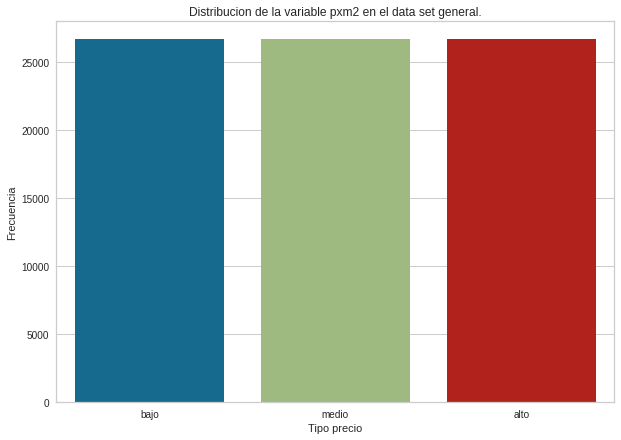

In [119]:
plt.figure(figsize=(10,7))
sns.countplot(ds_propiedades['tipo_precio']).set(title='Distribucion de la variable pxm2 en el data set general.',ylabel='Frecuencia',xlabel='Tipo precio')
plt.show()

Mapa de CABA indicando para cada inmueble a que tipo de precio pertenece

In [120]:
ds_propiedades.loc[ds_propiedades["tipo_precio"]=="bajo", "cluster_label"]= 'green'
ds_propiedades.loc[ds_propiedades["tipo_precio"]=="medio", "cluster_label"]= 'yellow'
ds_propiedades.loc[ds_propiedades["tipo_precio"]=="alto", "cluster_label"]= 'red'

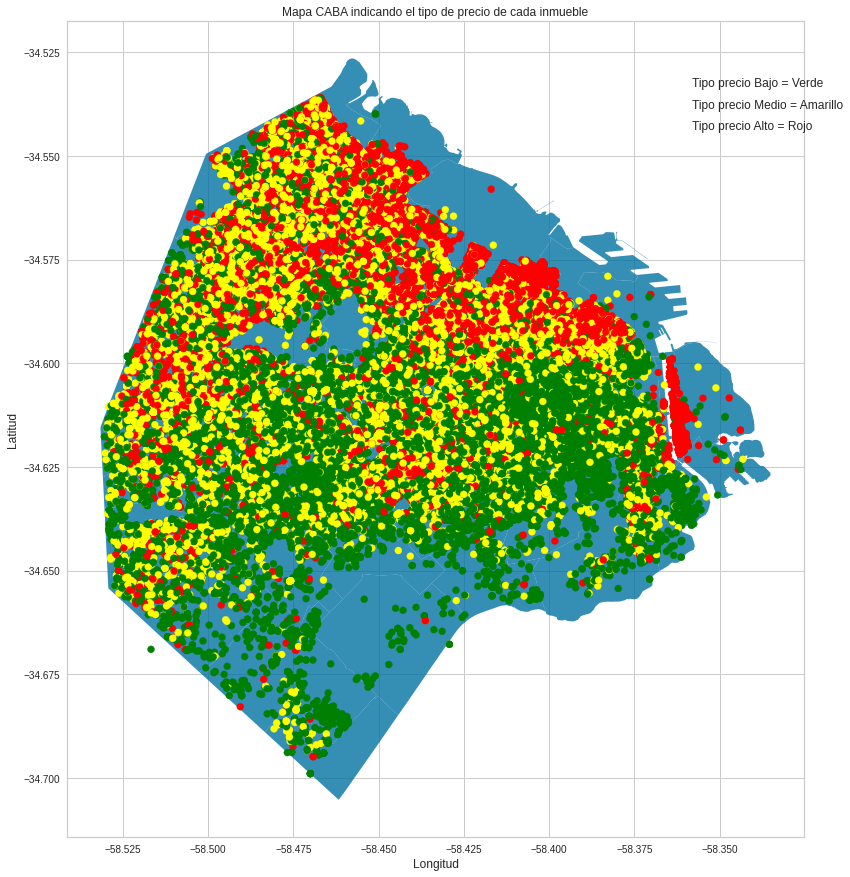

In [121]:
fig, ax = plt.subplots(figsize=(15,15))
plt.title('Mapa CABA indicando el tipo de precio de cada inmueble', fontsize = 12)
plt.xlabel("Longitud", fontsize = 12)
plt.ylabel("Latitud", fontsize = 12)
plt.figtext(.75, .82, "Tipo precio Bajo = Verde")
plt.figtext(.75, .80, "Tipo precio Medio = Amarillo")
plt.figtext(.75, .78, "Tipo precio Alto = Rojo")
poly.plot(ax=ax,alpha=0.8)
plt.scatter(ds_propiedades.longitud,ds_propiedades.latitud,c=ds_propiedades.cluster_label, cmap="plasma")

plt.show()

ds_propiedades.drop(['cluster_label'], axis = 1, inplace = True)

###Entrenamiento y predicción

Creamos los datasets 

In [122]:
ds_trabajo_test = ds_trabajo_test[ds_trabajo_test.property_type != 'Casa de campo']
ds_trabajo_train = ds_trabajo_train[ds_trabajo_train.property_type != 'Casa de campo']

ds_test_reducido = ds_test_reducido[ds_test_reducido.property_type != 'Casa de campo']
ds_train_reducido = ds_train_reducido[ds_train_reducido.property_type != 'Casa de campo']

In [123]:
ds_train_clasificacion_x = ds_trabajo_train.drop(['tipo_precio', 'property_price', 'property_surface_total'], axis='columns', inplace=False)
ds_train_clasificacion_y = ds_trabajo_train['tipo_precio'].copy()

ds_test_clasificacion_x = ds_trabajo_test.drop(['tipo_precio', 'property_price', 'property_surface_total'], axis='columns', inplace=False)
ds_test_clasificacion_y = ds_trabajo_test['tipo_precio'].copy()

ds_train_regresion_x = ds_trabajo_train.drop(['tipo_precio', 'property_price'], axis='columns', inplace=False)
ds_train_regresion_y = ds_trabajo_train['property_price'].copy()


ds_test_regresion_x = ds_trabajo_test.drop(['tipo_precio', 'property_price'], axis='columns', inplace=False)
ds_test_regresion_y = ds_trabajo_test['property_price'].copy()

In [124]:
indices_nulos = ds_train_reducido[ds_train_reducido.cp_1.isna()].index

ds_train_reducido = ds_train_reducido.drop(indices_nulos)

indices_nulos

Int64Index([64056, 64057, 64058, 64059, 64060, 64061, 64062, 64063, 64064,
            64065,
            ...
            65565, 65566, 65567, 65568, 65569, 65570, 65571, 65572, 65573,
            65574],
           dtype='int64', length=1487)

####Árbol de decisión

#####Dataset sin reducir

In [125]:
#separamos nuestros datos por dummies para trabajar con valores numéricos.

ds_dt_train_x = ds_train_clasificacion_x.copy()
ds_dt_train_x = pd.get_dummies(ds_dt_train_x, columns=['barrio', 'property_type'], drop_first=True)

ds_dt_train_y = ds_train_clasificacion_y.copy()

In [126]:
#separamos nuestros datos de entrenamiento y testeo

x_train, x_test, y_train, y_test = train_test_split(ds_dt_train_x,
                                                    ds_dt_train_y, 
                                                    test_size=0.2, #Hacemos una proporcion de 80/20 
                                                    random_state=100)

In [127]:
#Cantidad de combinaciones que quiero porbar
n=10 


params_grid = {'criterion':['gini','entropy'],
               'ccp_alpha':np.linspace(0,0.05,n), 
               'max_depth':list(range(1,10))}

#testeamos los parámetros que separamos arriba 
grid = GridSearchCV(tree.DecisionTreeClassifier(), params_grid)
grid.fit(x_train, y_train)

# save the model to disk
filename = 'arbol_de_decision_sin_reducir.sav'
pickle.dump(grid, open(filename, 'wb'))

In [128]:
#vemos los mejores parámetros
grid.best_params_

{'ccp_alpha': 0.0, 'criterion': 'entropy', 'max_depth': 9}

In [129]:
#evaluamos la efectividad porcentual
round(grid.score(x_train, y_train) * 100, 2)

60.82

In [130]:
#predecimos con los valores óptimos
y_pred = grid.predict(x_test)

In [131]:
pd.DataFrame(zip(y_test,y_pred),columns=['test','pred'])

test   pred
0       alto   alto
1       alto   alto
2      medio   bajo
3       alto  medio
4       alto   bajo
...      ...    ...
12806   bajo  medio
12807   alto   alto
12808  medio   alto
12809   bajo   alto
12810  medio   alto

[12811 rows x 2 columns]

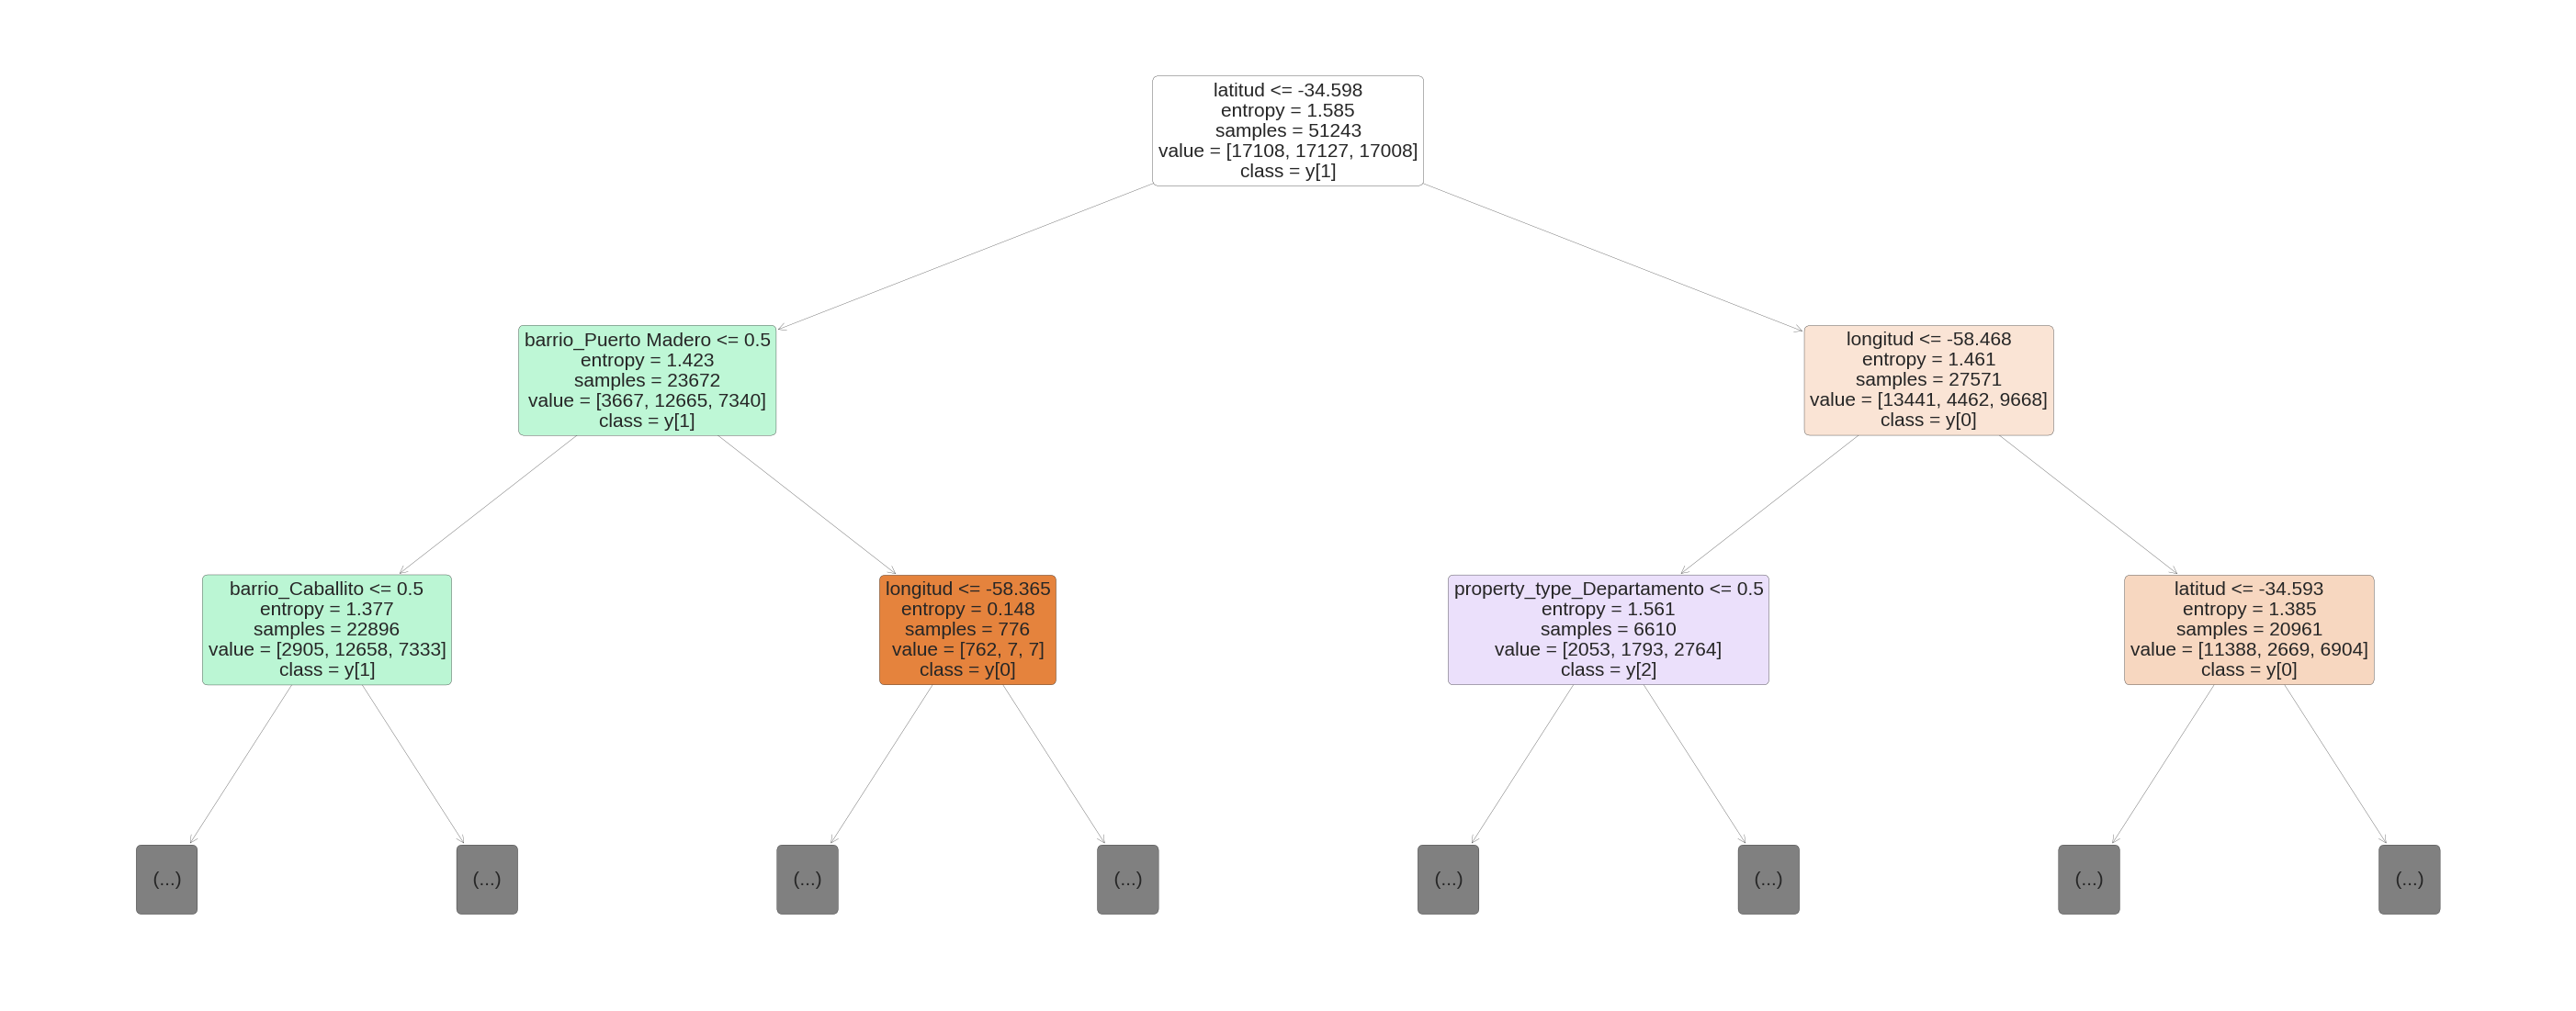

In [132]:
plt.figure(figsize=(50,20))

tree_plot=tree.plot_tree(grid.best_estimator_,
                         max_depth=2,
                         feature_names=ds_dt_train_x.columns.to_list(),
                         filled=True,
                         rounded=True,
                         class_names=True)

#mostramos el árbol
plt.show(tree_plot)



Como podemos observar, de los atributos seleccionados se muestran en el árbol latitud, barrio_Puerto Madero, longitud

Analizamos los resultados de utilizar el modelo de Arbol de decisión como modelo de predicción

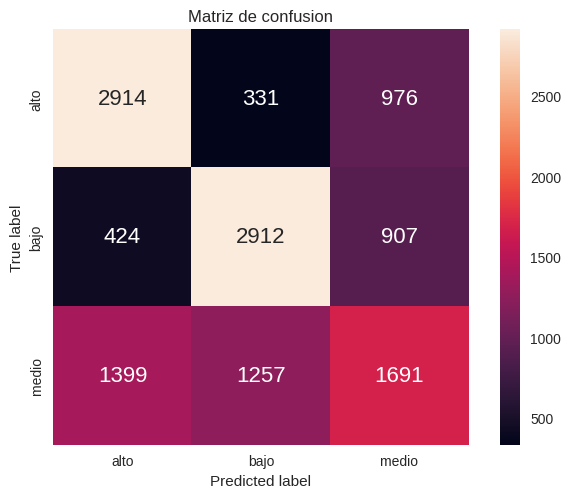

In [133]:
plot_confusion_matrix(y_test, y_pred)

In [134]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        alto       0.62      0.69      0.65      4221
        bajo       0.65      0.69      0.67      4243
       medio       0.47      0.39      0.43      4347

    accuracy                           0.59     12811
   macro avg       0.58      0.59      0.58     12811
weighted avg       0.58      0.59      0.58     12811



#####Dataset reducido


Separamos los datos del dataset reducido por dummies para trabajar con valores numéricos

In [135]:
ds_train_x_1d = pd.get_dummies(ds_train_reducido, columns=['barrio', 'property_type'])

ds_test_x_1d = pd.get_dummies(ds_test_reducido, columns=['barrio', 'property_type'])

ds_dt_train_y = ds_train_clasificacion_y.copy()

In [136]:
ds_dt_train_y = ds_dt_train_y.drop(indices_nulos)

In [137]:
#separamos nuestros datos de entrenamiento y testeo

x_train, x_test, y_train, y_test = train_test_split(ds_train_x_1d,
                                                    ds_dt_train_y, 
                                                    test_size=0.2, #Hacemos una proporcion de 80/20 
                                                    random_state=100)

In [138]:
#Cantidad de combinaciones que quiero porbar
n=10 

params_grid = {'criterion':['gini','entropy'],
               'ccp_alpha':np.linspace(0,0.05,n), 
               'max_depth':list(range(1,10))}

#testeamos los parámetros que separamos arriba 
grid = GridSearchCV(tree.DecisionTreeClassifier(), params_grid)
grid.fit(x_train, y_train)

# save the model to disk
filename = 'arbol_de_decision_reducido.sav'
pickle.dump(grid, open(filename, 'wb'))

In [139]:
#vemos los mejores parámetros
grid.best_params_

{'ccp_alpha': 0.0, 'criterion': 'gini', 'max_depth': 9}

In [140]:
#evaluamos la efectividad porcentual
round(grid.score(x_train, y_train) * 100, 2)

54.75

In [141]:
#predecimos con los valores óptimos
y_pred = grid.predict(x_test)

In [142]:
pd.DataFrame(zip(y_test,y_pred),columns=['test','pred'])

test   pred
0      medio   alto
1      medio   bajo
2      medio   bajo
3       bajo   bajo
4       alto   alto
...      ...    ...
12509   bajo   bajo
12510  medio   alto
12511  medio  medio
12512   bajo   alto
12513   bajo   bajo

[12514 rows x 2 columns]

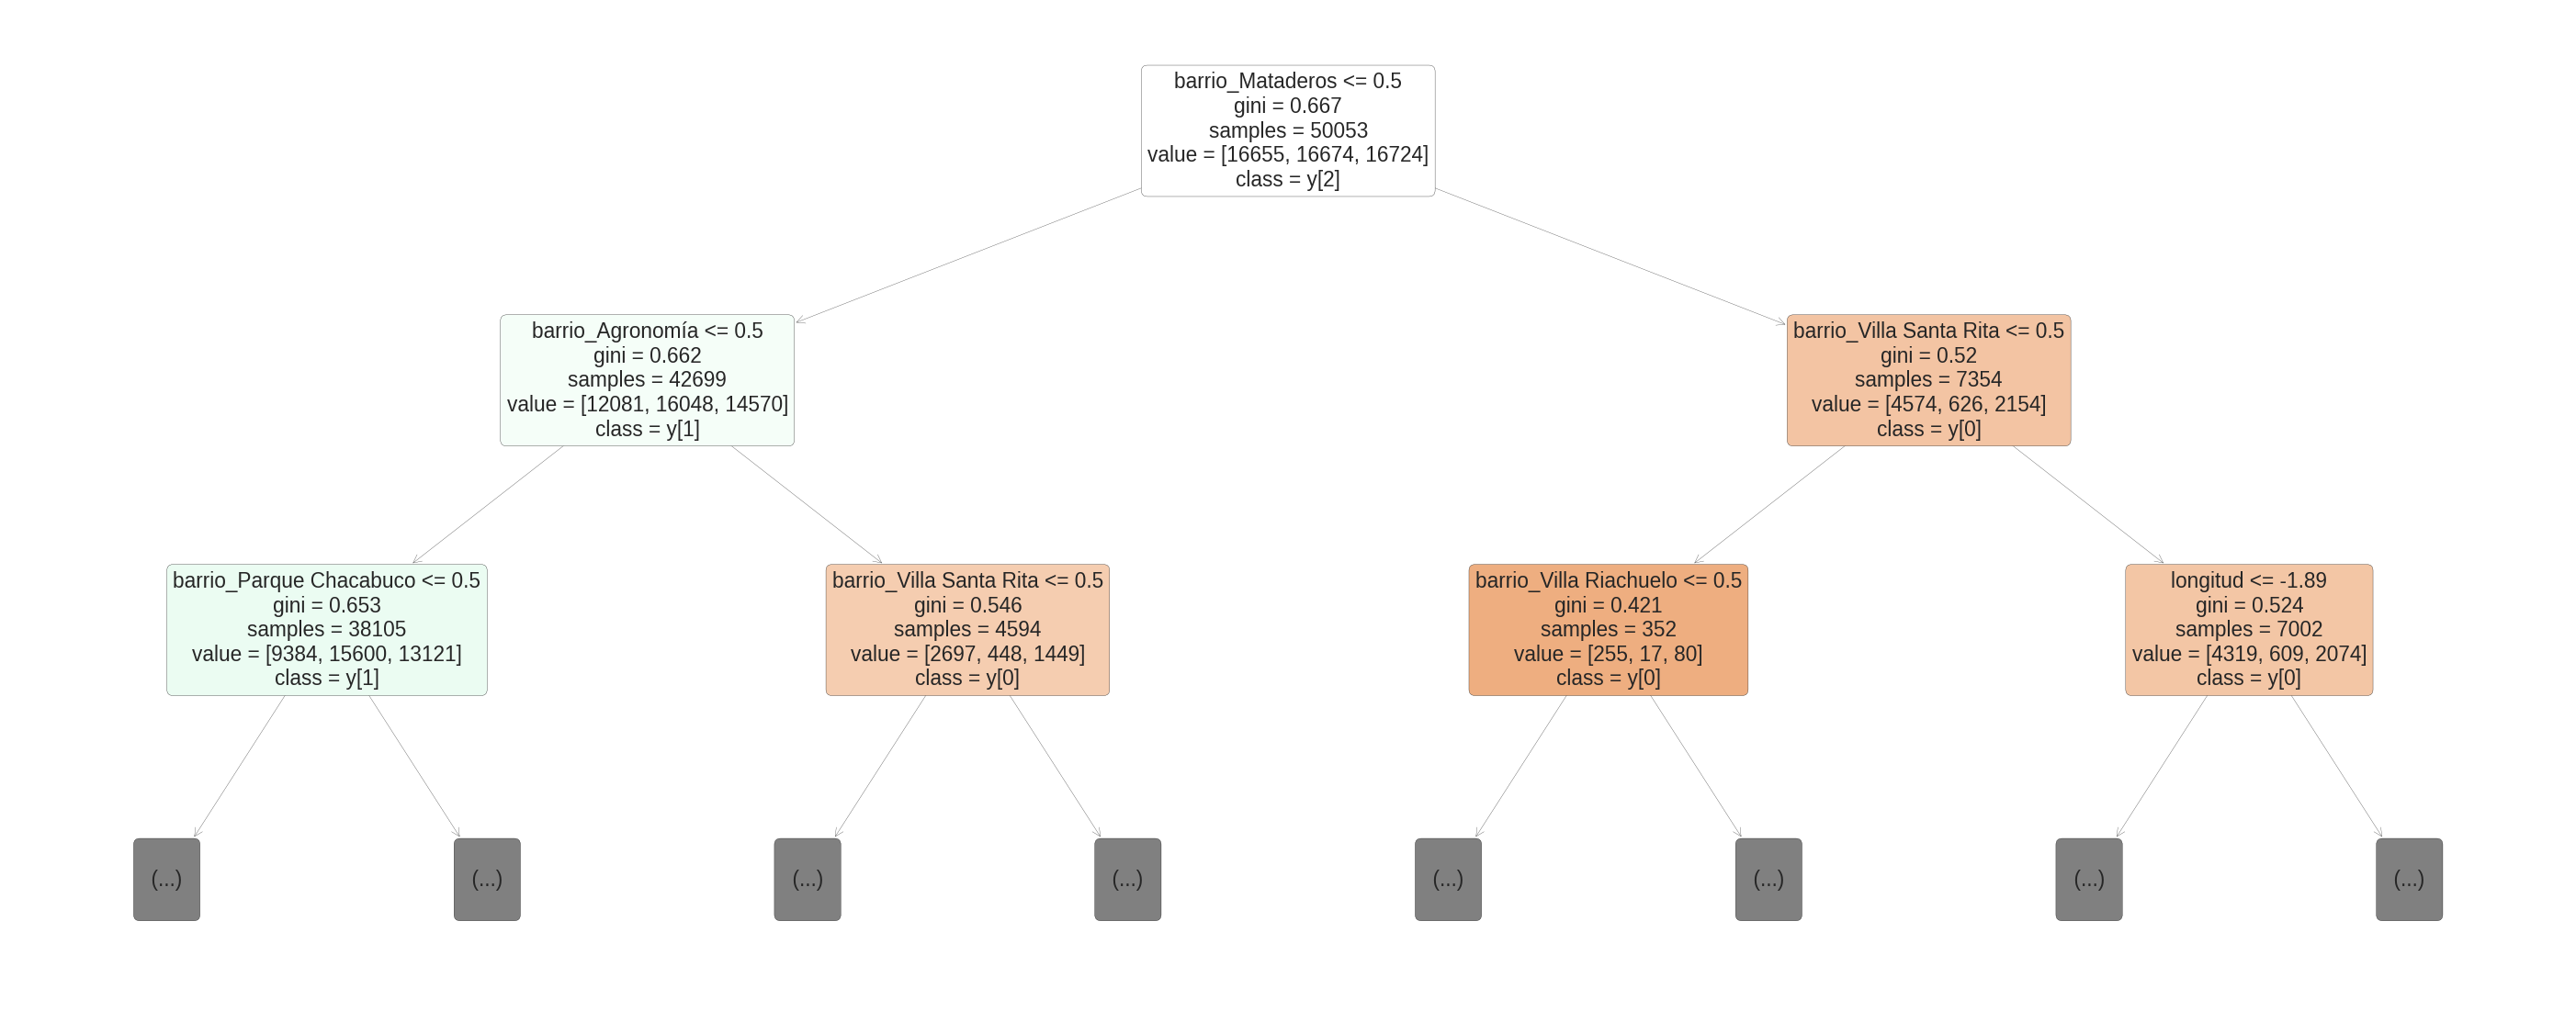

In [143]:
plt.figure(figsize=(50,20))

tree_plot=tree.plot_tree(grid.best_estimator_,
                         max_depth=2,
                         feature_names=ds_dt_train_x.columns.to_list(),
                         filled=True,
                         rounded=True,
                         class_names=True)

#mostramos el árbol
plt.show(tree_plot)

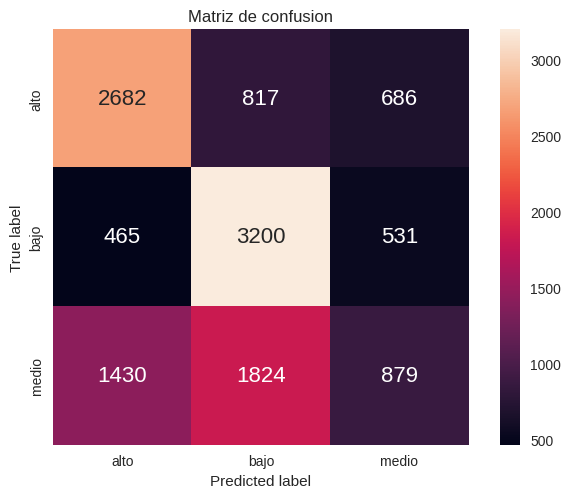

In [144]:
plot_confusion_matrix(y_test, y_pred)

In [145]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        alto       0.59      0.64      0.61      4185
        bajo       0.55      0.76      0.64      4196
       medio       0.42      0.21      0.28      4133

    accuracy                           0.54     12514
   macro avg       0.52      0.54      0.51     12514
weighted avg       0.52      0.54      0.51     12514



####Random Forest

In [146]:
# Creo el modelo
rf_classifier = RandomForestClassifier()

#####Dataset sin reducir

In [147]:
ds_rf_train_x = ds_train_clasificacion_x.copy()
ds_rf_train_x.drop(['latitud','longitud'], axis = 1, inplace = True)
ds_rf_train_x = pd.get_dummies(ds_rf_train_x, columns=["barrio","property_type"], drop_first=True)

ds_rf_train_y = ds_train_clasificacion_y.copy()

In [148]:
ds_rf_test_x = ds_test_clasificacion_x.copy()
ds_rf_test_x.drop(['latitud','longitud'], axis = 1, inplace = True)
ds_rf_test_x = pd.get_dummies(ds_rf_test_x, columns=["barrio","property_type"], drop_first=True)

ds_rf_test_y = ds_test_clasificacion_y.copy()

Busqueda de hiperparametros. 
Vamos a usar en ambos casos 3 folds.

In [149]:
# Numero de arboles en random forest
n_estimators = [10, 20, 30, 40, 50]
# Numero de features a considerar en cada split
max_features = ['auto', 'sqrt']
# Maxima profundidad de los arboles
max_depth = [1 ,2, 3, 4, 5, 6, 7, 8, 9, 10]
max_depth.append(None)
#Minima cantidad de muestras para splitear un nodo
min_samples_split = [2, 5, 10]
# Minima cantidad de muestras en cada hoja 
min_samples_leaf = [1, 2, 4]
# Metodo para seleccionar las muestras para el entrenamiento de cada arbol
bootstrap = [True, False]

Randomized Search Cross Validation

In [150]:
# Creo la grilla de parametros
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [151]:
rf_randomSearch = RandomizedSearchCV(estimator = rf_classifier, param_distributions = random_grid, n_iter = 50, cv = 3, verbose=2, n_jobs = -1)
rf_randomSearch.fit(ds_rf_train_x, ds_rf_train_y)



#Mejores hiperparametros del arbol
print(rf_randomSearch.best_params_)
#Mejor métrica
print(rf_randomSearch.best_score_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': None, 'bootstrap': False}
0.5829299895645967


Grid Search con Cross Validation

In [152]:
# Creo la grilla de parametros
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [153]:
grid_search = GridSearchCV(estimator = rf_classifier, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(ds_rf_train_x, ds_rf_train_y)

# save the model to disk
filename = 'random_forest_sin_reducir.sav'
pickle.dump(rf_randomSearch, open(filename, 'wb'))

#Mejores hiperparametros del arbol
print(grid_search.best_params_)
#Mejor métrica
print(grid_search.best_score_)

Fitting 3 folds for each of 180 candidates, totalling 540 fits
{'bootstrap': True, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}
0.585693289617662


La diferencia es muy pequeña pero es cierto que grid search dio un mejor resutado asi que vamos a usar los hiperparametros que obtuvimos con ese metodo

In [154]:
rf_randomSearch = RandomForestClassifier(bootstrap= False, n_estimators=30, max_depth= None, max_features= 'auto', min_samples_leaf=4, min_samples_split=2, random_state=15)

rf_randomSearch.fit(ds_rf_train_x, ds_rf_train_y)
y_pred = rf_randomSearch.predict(ds_rf_test_x)

              precision    recall  f1-score   support

        alto       0.63      0.67      0.65      5332
        bajo       0.63      0.68      0.65      5336
       medio       0.47      0.41      0.44      5327

    accuracy                           0.58     15995
   macro avg       0.58      0.58      0.58     15995
weighted avg       0.58      0.58      0.58     15995

Accuracy: 0.5846201938105658
 


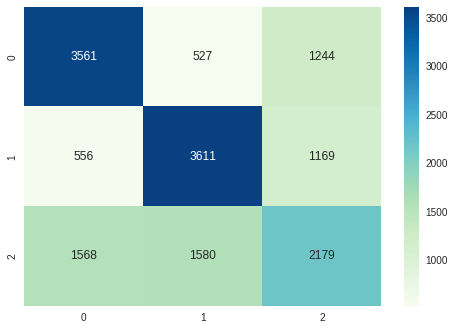

In [155]:
#Calculo las métricas en el conjunto de evaluación
accuracy=accuracy_score(ds_rf_test_y,y_pred)

print(classification_report(ds_rf_test_y,y_pred))
print("Accuracy: "+str(accuracy))
print(" ")

#Creo la matriz de confusión
tabla=confusion_matrix(ds_rf_test_y, y_pred)

#Grafico la matriz de confusión
plt.xlabel('Predicted')
plt.ylabel('True')
sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.show()

Analisis de features de random forest

[5.29436308e-02 4.62947775e-02 5.44841459e-01 3.81746225e-02
 3.78815835e-02 9.41453668e-03 9.02083524e-04 3.09742070e-03
 1.25692335e-02 1.69948457e-03 5.86816600e-03 3.10249081e-02
 3.10446136e-03 2.53025484e-03 3.65928383e-03 4.66299506e-05
 3.49181814e-04 1.48761955e-03 2.30755426e-03 4.84426798e-03
 2.46151899e-03 3.92765581e-03 7.15407974e-03 3.21747200e-03
 1.62147307e-04 1.40045147e-03 1.73330604e-03 3.65902526e-03
 1.14102369e-03 9.53515363e-03 2.46009105e-03 5.19759332e-02
 1.74777648e-03 4.35762133e-04 1.59089456e-03 1.25505194e-03
 1.67579297e-03 1.34479542e-03 1.70108249e-03 2.22047200e-02
 1.69060116e-02 2.12933583e-03 2.68838041e-03 5.58152662e-03
 3.36131454e-03 1.72628036e-03 3.51747922e-04 9.15757253e-04
 9.14603599e-04 2.18016826e-03 2.81651875e-03 1.13660641e-03
 3.89092164e-03 1.39792255e-03 1.41236808e-03 1.48702046e-03
 6.11370870e-04 3.23995591e-04 1.14642175e-03 3.89877925e-04
 6.67075625e-03 1.70051379e-03 9.04316702e-03 7.39251865e-03]


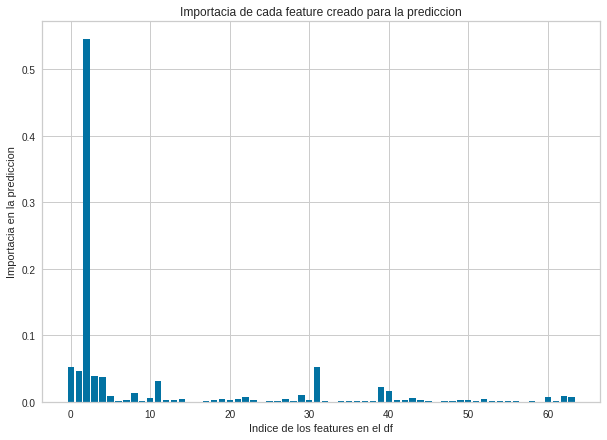

In [156]:
#Veo la importancia de cada feature para este algoritmo
model = ExtraTreesClassifier()
model.fit(ds_rf_train_x, ds_rf_train_y)

print(model.feature_importances_)

#Grafico importancia de cada uno
plt.figure(figsize=(10,7))
plt.title('Importacia de cada feature creado para la prediccion', )
plt.xlabel('Indice de los features en el df')
plt.ylabel('Importacia en la prediccion')

plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.show()

Graficamos uno de los arboles

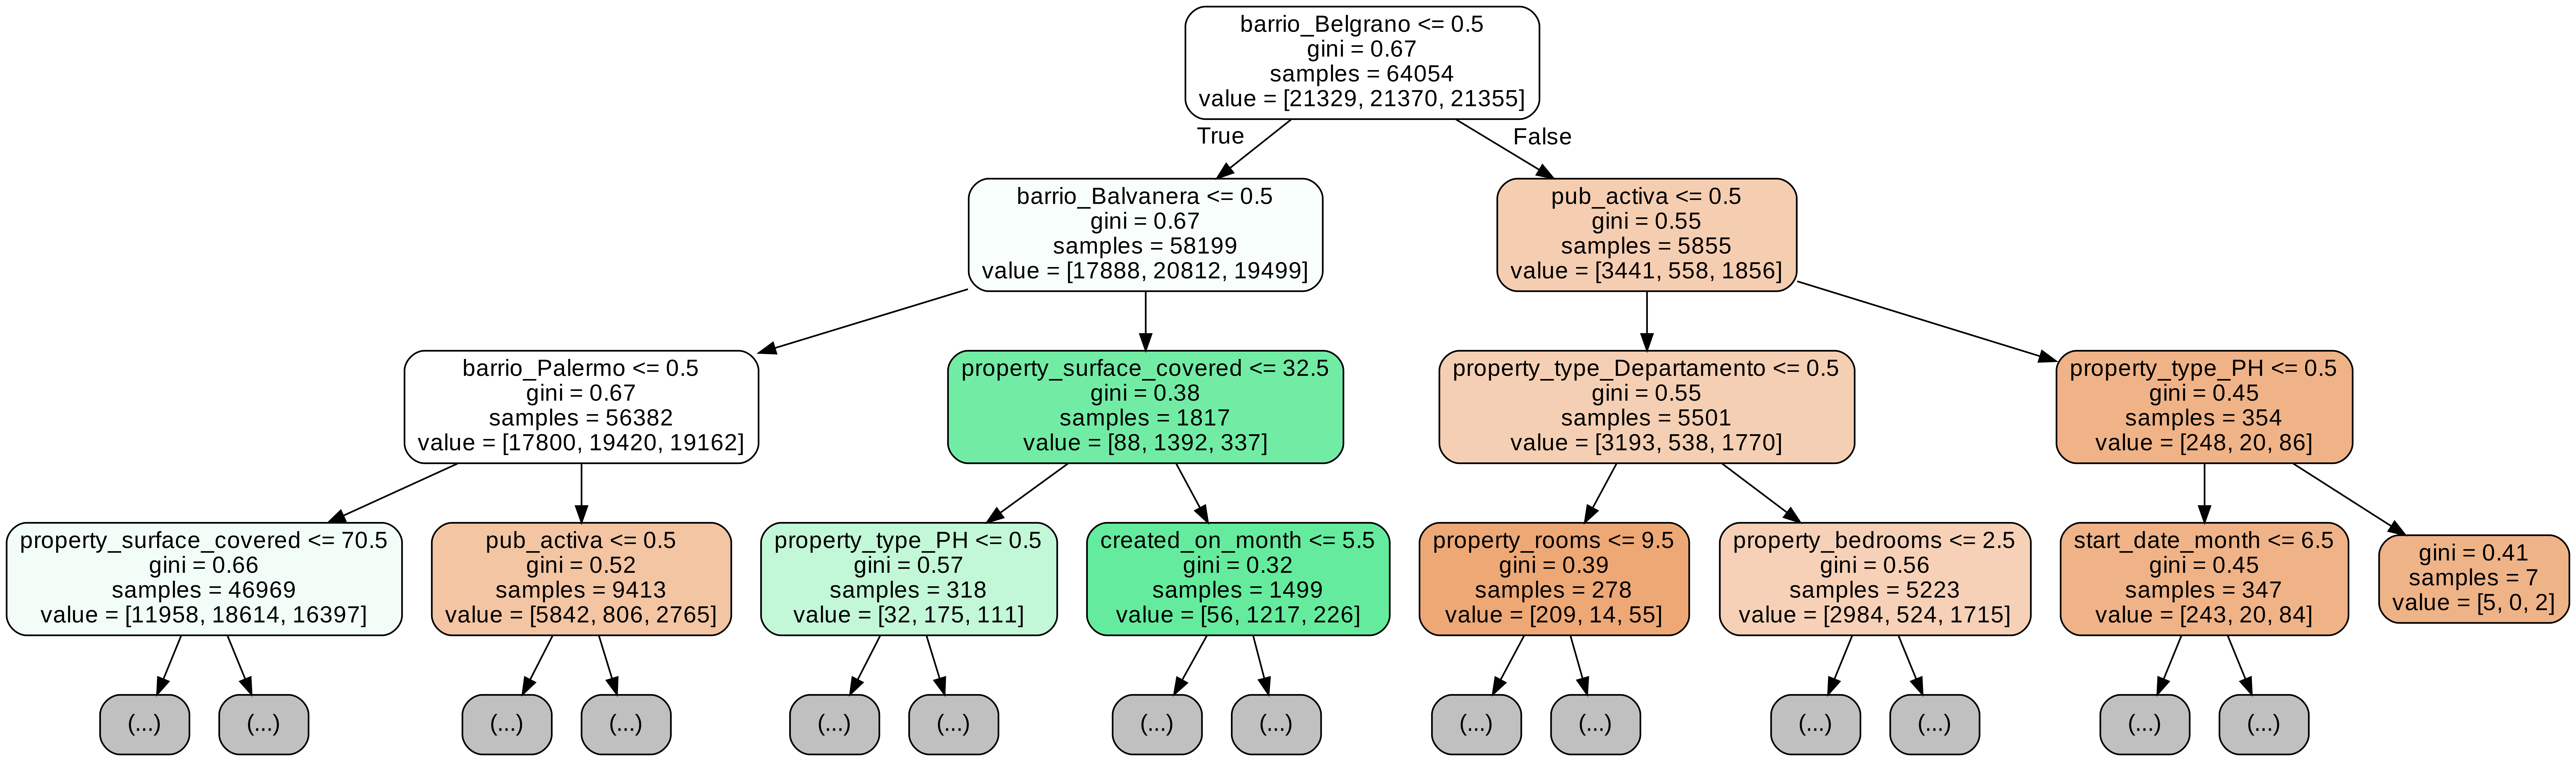

In [157]:
from sklearn.tree import export_graphviz
from IPython.display import Image
from subprocess import call

# estraigo uno de los arboles
tree = rf_randomSearch.estimators_[10]

export_graphviz(tree, out_file='tree.dot', feature_names = ds_rf_train_x.columns.to_list(), max_depth = 3, rounded = True, proportion = False, precision = 2, filled = True)

call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

Image(filename = 'tree.png')

#####Dataset reducido

In [158]:
ds_train_reducido_x = pd.get_dummies(ds_train_reducido, columns=['barrio', 'property_type'])
ds_test_reducido_x = pd.get_dummies(ds_test_reducido, columns=['barrio', 'property_type'])

ds_rf_train_y = ds_rf_train_y.drop(indices_nulos)

In [159]:
indices_nulos

Int64Index([64056, 64057, 64058, 64059, 64060, 64061, 64062, 64063, 64064,
            64065,
            ...
            65565, 65566, 65567, 65568, 65569, 65570, 65571, 65572, 65573,
            65574],
           dtype='int64', length=1487)

Busqueda de hiperparametros. 
Vamos a usar en ambos casos 3 folds.

Randomized Search Cross Validation

In [160]:
# Numero de arboles en random forest
n_estimators = [10, 20, 30, 40, 50]
# Numero de features a considerar en cada split
max_features = ['auto', 'sqrt']
# Maxima profundidad de los arboles
max_depth = [1 ,2, 3, 4, 5, 6, 7, 8, 9, 10]
max_depth.append(None)
#Minima cantidad de muestras para splitear un nodo
min_samples_split = [2, 5, 10]
# Minima cantidad de muestras en cada hoja 
min_samples_leaf = [1, 2, 4]
# Metodo para seleccionar las muestras para el entrenamiento de cada arbol
bootstrap = [True, False]

In [161]:
# Creo la grilla de parametros
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [162]:
ds_rf_train_y.shape

(62567,)

In [163]:
rf_randomSearch = RandomizedSearchCV(estimator = rf_classifier, param_distributions = random_grid, n_iter = 50, cv = 3, verbose=2, n_jobs = -1)
rf_randomSearch.fit(ds_train_reducido_x, ds_rf_train_y)

#Mejores hiperparametros del arbol
print(rf_randomSearch.best_params_)
#Mejor métrica
print(rf_randomSearch.best_score_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'n_estimators': 10, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 9, 'bootstrap': True}
0.5344670832706061


Grid Search con Cross Validation

In [164]:
# Numero de arboles en random forest
n_estimators = [10, 20, 30, 40, 50]
# Numero de features a considerar en cada split
max_features = ['auto', 'sqrt']
#Minima cantidad de muestras para splitear un nodo
min_samples_split = [2, 5, 10]
# Minima cantidad de muestras en cada hoja 
min_samples_leaf = [1, 2, 4]
# Metodo para seleccionar las muestras para el entrenamiento de cada arbol
bootstrap = [True, False]

In [165]:
# Creo la grilla de parametros
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [166]:
# Instancio el modelo de grid search
grid_search = GridSearchCV(estimator = rf_classifier, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(ds_train_reducido_x, ds_rf_train_y)

# save the model to disk
filename = 'random_forest_reducido.sav'
pickle.dump(rf_randomSearch, open(filename, 'wb'))

#Mejores hiperparametros del arbol
print(grid_search.best_params_)
#Mejor métrica
print(grid_search.best_score_)

Fitting 3 folds for each of 180 candidates, totalling 540 fits
{'bootstrap': True, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 30}
0.5177969296281694


La diferencia es muy pequeña pero es cierto que grid search dio un mejor resutado asi que vamos a usar los hiperparametros que obtuvimos con ese metodo

In [167]:
rf_gridSearch=RandomForestClassifier(bootstrap= False, n_estimators=10, max_depth= 8, max_features= 'auto', min_samples_leaf=1, min_samples_split=2, random_state=15)

rf_gridSearch.fit(ds_train_reducido_x, ds_rf_train_y)
y_pred = rf_gridSearch.predict(ds_test_reducido_x)

              precision    recall  f1-score   support

        alto       0.61      0.59      0.60      5332
        bajo       0.51      0.81      0.63      5336
       medio       0.40      0.18      0.25      5327

    accuracy                           0.53     15995
   macro avg       0.51      0.53      0.49     15995
weighted avg       0.51      0.53      0.49     15995

Accuracy: 0.5297905595498593
 


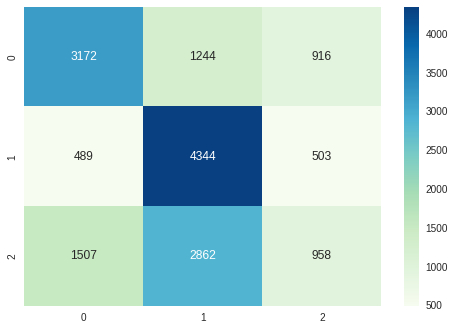

In [168]:
#Calculo las métricas en el conjunto de evaluación
accuracy=accuracy_score(ds_rf_test_y,y_pred)

print(classification_report(ds_rf_test_y,y_pred))
print("Accuracy: "+str(accuracy))
print(" ")

#Creo la matriz de confusión
tabla=confusion_matrix(ds_rf_test_y, y_pred)

#Grafico la matriz de confusión
plt.xlabel('Predicted')
plt.ylabel('True')
sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.show()

Analisis de features de random forest

[3.77267609e-01 3.77459344e-01 3.48244988e-04 2.66152243e-04
 3.33510653e-03 1.31576096e-02 1.50422435e-03 5.12606852e-03
 2.97948849e-02 3.21934725e-03 2.37830449e-03 3.17321326e-03
 4.51507155e-05 8.74574094e-05 7.96481082e-04 1.62896035e-03
 3.75231983e-03 2.49888205e-03 4.19688537e-03 7.52939822e-03
 3.39587698e-03 1.35000732e-04 8.60172973e-04 1.63145831e-03
 3.42442430e-03 5.48827219e-04 7.89709780e-03 2.55013527e-03
 5.15761083e-02 1.91164956e-03 1.28542049e-04 1.21578917e-03
 5.28704832e-04 1.66537556e-03 1.10358894e-03 1.78358348e-03
 2.16593538e-02 1.57604783e-02 1.88887124e-03 1.91810038e-03
 5.17384724e-03 3.41728424e-03 1.07734007e-03 1.98165622e-04
 4.01794077e-04 3.16672255e-04 1.57120291e-03 2.11226933e-03
 7.30750874e-04 4.11354099e-03 7.62623897e-04 5.80634758e-04
 5.47020911e-04 1.81504257e-04 2.50814652e-04 7.58655177e-04
 4.25214962e-04 5.89344362e-03 1.31132276e-03 2.12566433e-03
 5.41821759e-03 3.48323185e-03]


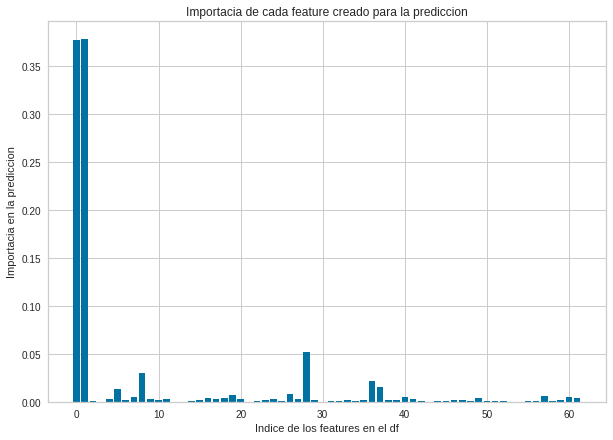

In [169]:
#Veo la importancia de cada feature para este algoritmo
model = ExtraTreesClassifier()
model.fit(ds_train_reducido_x, ds_rf_train_y)

print(model.feature_importances_)

#Grafico importancia de cada uno
plt.figure(figsize=(10,7))
plt.title('Importacia de cada feature creado para la prediccion', )
plt.xlabel('Indice de los features en el df')
plt.ylabel('Importacia en la prediccion')

plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.show()

Graficamos uno de los arboles

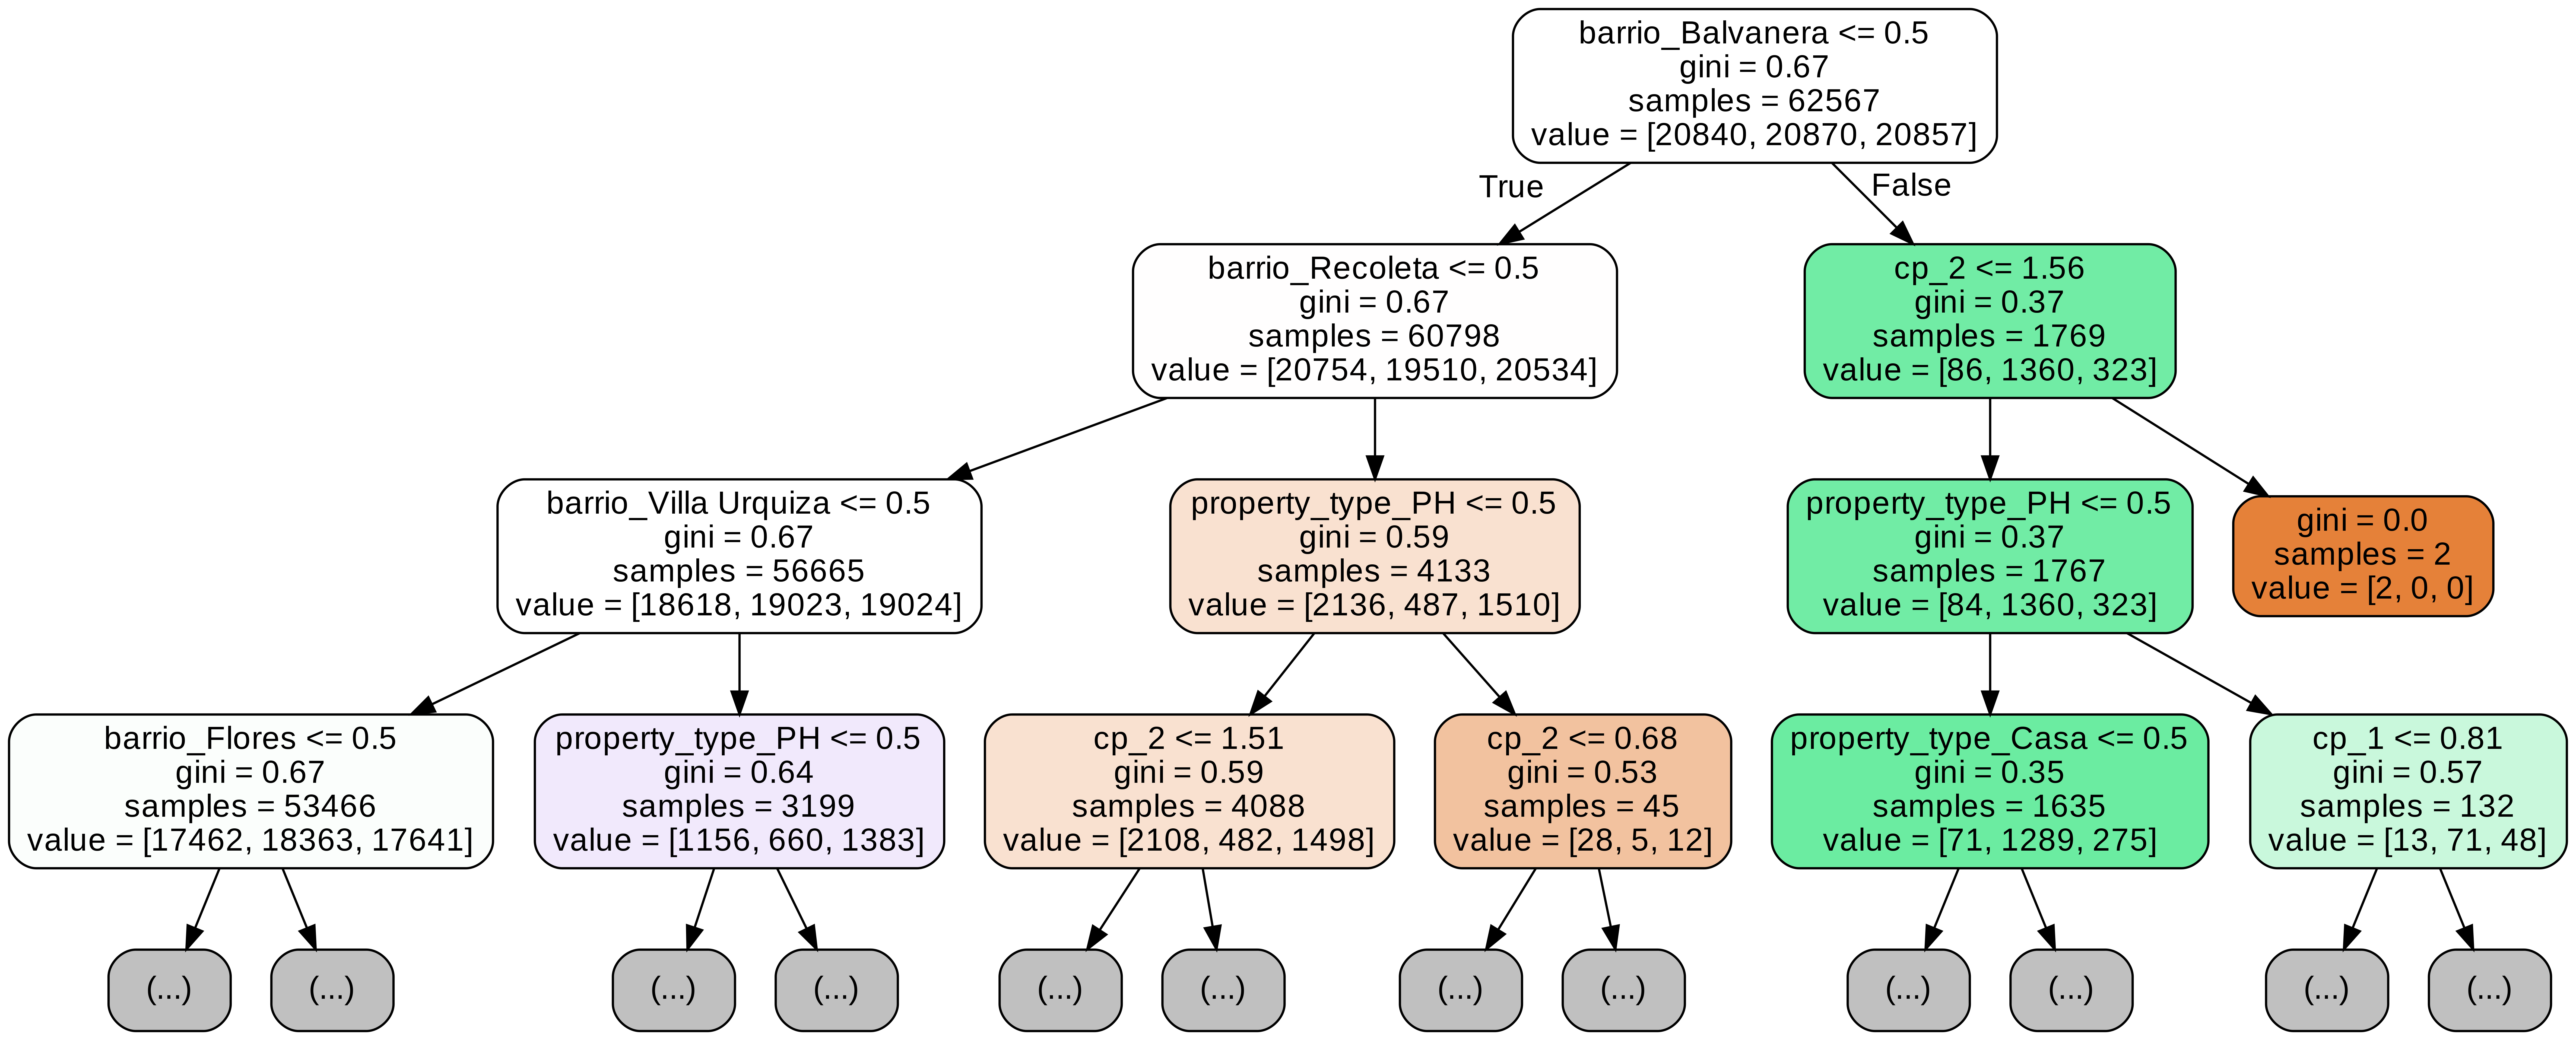

In [170]:
from sklearn.tree import export_graphviz
from IPython.display import Image
from subprocess import call

# estraigo uno de los arboles
tree = rf_gridSearch.estimators_[2]

export_graphviz(tree, out_file='tree.dot', feature_names = ds_train_reducido_x.columns.to_list(), max_depth = 3, rounded = True, proportion = False, precision = 2, filled = True)

call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

Image(filename = 'tree.png')

####AdaBoost

Fuera de los modelos que utilizamos antes que nos parecieron bastante prometedores en terminos de adaptación al modelo, nos parece que AdaBoost tiene grandes cualidades para que no overfitee el modelo y optimizar la clasificación del mismo...

#####Dataset sin reducir

In [171]:
#Preparamos el dataset para usar el AdaBoost
ds_ab_train_x = ds_train_clasificacion_x.copy()
ds_ab_train_x = pd.get_dummies(ds_ab_train_x, columns=['barrio', 'property_type'], drop_first=True)

ds_ab_train_y = ds_train_clasificacion_y.copy()

ds_ab_test_x = ds_test_clasificacion_x.copy()
ds_ab_test_x = pd.get_dummies(ds_ab_test_x, columns=['barrio', 'property_type'], drop_first=True)


In [172]:
abc = AdaBoostClassifier()
model = abc.fit(ds_ab_train_x, ds_ab_train_y)
y_pred = model.predict(ds_ab_test_x)

# save the model to disk
filename = 'adaboost_sin_reducir.sav'
pickle.dump(model, open(filename, 'wb'))

In [173]:
#Evaluamos el modelo y vemos como se ajusta a los datos de testeo.
print("Accuracy:",metrics.accuracy_score(ds_test_clasificacion_y, y_pred))

Accuracy: 0.5661769302907158


#####Dataset reducido

In [174]:
ds_train_x_1d = pd.get_dummies(ds_train_reducido, columns=['barrio', 'property_type'])
ds_test_x_1d = pd.get_dummies(ds_test_reducido, columns=['barrio', 'property_type'])

ds_ab_train_y = ds_train_clasificacion_y.copy()
ds_ab_train_y = ds_ab_train_y.drop(indices_nulos)

In [175]:
abc = AdaBoostClassifier()
model = abc.fit(ds_train_x_1d, ds_ab_train_y)
y_pred = model.predict(ds_test_x_1d)

# save the model to disk
filename = 'adaboost_reducido.sav'
pickle.dump(model, open(filename, 'wb'))

In [176]:
#Evaluamos el modelo y vemos como se ajusta a los datos de testeo.
print("Accuracy:",metrics.accuracy_score(ds_test_clasificacion_y, y_pred))

Accuracy: 0.5551734917161613


# **4. Regresion**








##KNN

In [177]:
#Crear el modelo
KNN_default = KNeighborsRegressor()

#vemos sus parámetros
KNN_default.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

###Dataset sin reducir

In [178]:
ds_knn_train_x = ds_train_regresion_x.copy()
ds_knn_train_y = ds_train_regresion_y.copy()

#One hot encoding para variables categoricas
ds_knn_train_x = pd.get_dummies(ds_knn_train_x, columns=["barrio","property_type"], drop_first=True)
ds_knn_train_x.drop(['latitud','longitud'], axis = 1, inplace = True)

In [179]:
ds_knn_test_x = ds_test_regresion_x.copy()
ds_knn_test_y = ds_test_regresion_y.copy()

#One hot encoding para variables categoricas
ds_knn_test_x = pd.get_dummies(ds_knn_test_x, columns=["barrio","property_type"], drop_first=True)
ds_knn_test_x.drop(['latitud','longitud'], axis = 1, inplace = True)

Primero usamos el modelo standard con sus hiperparametros por defecto.

In [180]:
#Entrenar el modelo
KNN_default.fit(ds_knn_train_x, ds_knn_train_y)

#Predicción sobre test
y_pred = KNN_default.predict(ds_knn_test_x)

# save the model to disk
filename = 'knn_sin_reducir.sav'
pickle.dump(model, open(filename, 'wb'))

In [181]:
report_regression(KNN_default, ds_knn_train_x, ds_knn_train_y, ds_knn_test_x, ds_knn_test_y)


Metricas for regression:
      mean absolute error:            63645.317
    median absolute error:            25180.000
       mean squared error:      26948974529.824
                max error:          4650000.000
                 r2 score:                0.665
 explained variance score:                0.665

Percentiles:
                       25:           -30400.000
                       50:            -4587.600
                       75:            19600.000
El score general del modelo es 0.6651525922684258
La media del cross validation score con k=5 es 0.653744507953236


Normalizamos el data set de train con MinMaxScaler

In [182]:
minMaxScaler = MinMaxScaler()
minMaxScaler.fit(ds_knn_train_x)

x_train_normalized = minMaxScaler.transform(ds_knn_train_x)   
X_test_normalized = minMaxScaler.transform(ds_knn_test_x)   

Buscamos los mejores hiperparametros utilizando 3 folds

In [183]:
n_neighbors = [int(x) for x in np.linspace(start = 5, stop = 30, num=3)]
weights= ['uniform', 'distance']
algorithm= ['ball_tree', 'kd_tree']
n_jobs= [-1]

In [184]:
param_grid  = {'n_neighbors': n_neighbors,
               'weights': weights,
               'algorithm': algorithm,
               'n_jobs': n_jobs}

Grid Search con Cross Validation

In [185]:
grid_search = GridSearchCV(estimator = KNN_default, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(ds_knn_train_x, ds_knn_train_y) #25 minutos
grid_search.best_params_

Fitting 3 folds for each of 48 candidates, totalling 144 fits


{'algorithm': 'auto', 'n_jobs': -1, 'n_neighbors': 15, 'weights': 'distance'}

In [186]:
knn_features = KNeighborsRegressor(n_neighbors=15, algorithm='auto', n_jobs= -1, weights='distance')

In [187]:
knn_features.fit(ds_knn_train_x, ds_knn_train_y)
y_pred = knn_features.predict(ds_knn_test_x)

In [188]:
report_regression(knn_features, ds_knn_train_x, ds_knn_train_y, ds_knn_test_x, ds_knn_test_y)


Metricas for regression:
      mean absolute error:            59016.744
    median absolute error:            22366.494
       mean squared error:      23876464172.769
                max error:          4063930.931
                 r2 score:                0.703
 explained variance score:                0.704

Percentiles:
                       25:           -29256.004
                       50:            -3000.000
                       75:            15000.000
El score general del modelo es 0.7033292630411676
La media del cross validation score con k=5 es 0.6975612007347545


###Dataset reducido

In [189]:
ds_knn_reducido_train_x = pd.get_dummies(ds_train_reducido, columns=['barrio','property_type'], drop_first=True)
ds_knn_reducido_test_x = pd.get_dummies(ds_test_reducido, columns=['barrio','property_type'], drop_first=True)

ds_knn_train_y = ds_knn_train_y.drop(indices_nulos)

Primero usamos el modelo standard con sus hiperparametros por defecto.

In [190]:
#Entrenar el modelo
KNN_default.fit(ds_knn_reducido_train_x, ds_knn_train_y)

#Predicción sobre test
y_pred = KNN_default.predict(ds_knn_reducido_test_x)


# save the model to disk
filename = 'knn_reducido.sav'
pickle.dump(model, open(filename, 'wb'))

In [192]:
report_regression(KNN_default, ds_knn_reducido_train_x, ds_knn_train_y, ds_knn_reducido_test_x, ds_knn_test_y)


Metricas for regression:
      mean absolute error:           134649.521
    median absolute error:            64600.000
       mean squared error:      80096519016.815
                max error:          5432000.000
                 r2 score:                0.005
 explained variance score:                0.005

Percentiles:
                       25:           -79980.000
                       50:           -21900.000
                       75:            41360.000
El score general del modelo es 0.004781731808674916
La media del cross validation score con k=5 es 0.03599806245018611


Ahora vamos a probar normalizando el set de datos y buscando sus mejores hiperparametros

Normalizamos el data set de train con MinMaxScaler

In [193]:
minMaxScaler = MinMaxScaler()
minMaxScaler.fit(ds_knn_reducido_train_x)

x_train_normalized = minMaxScaler.transform(ds_knn_reducido_train_x)   
X_test_normalized = minMaxScaler.transform(ds_knn_reducido_test_x)   

Creamos un modelo analizando sus hiperparametros utilizando Grid Search con Cross Validation

In [198]:
n_neighbors = [int(x) for x in np.linspace(start = 5, stop = 30, num=3)]
weights= ['uniform', 'distance']
algorithm= ['ball_tree', 'kd_tree']
n_jobs= [-1]

In [199]:
param_grid  = {'n_neighbors': n_neighbors,
               'weights': weights,
               'algorithm': algorithm,
               'n_jobs': n_jobs}

Vamos a usar 3 folds



In [200]:
grid_search = GridSearchCV(estimator = KNN_default, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(ds_knn_reducido_train_x, ds_knn_train_y) 
grid_search.best_params_

Fitting 3 folds for each of 12 candidates, totalling 36 fits


{'algorithm': 'ball_tree',
 'n_jobs': -1,
 'n_neighbors': 30,
 'weights': 'uniform'}

In [201]:
knn_features = KNeighborsRegressor(n_neighbors=30, algorithm='auto', n_jobs= -1, weights='distance')

In [202]:
knn_features.fit(ds_knn_reducido_train_x, ds_knn_train_y)
y_pred = knn_features.predict(ds_knn_reducido_test_x)

In [204]:
report_regression(knn_features, ds_knn_reducido_train_x, ds_knn_train_y, ds_knn_reducido_test_x, ds_knn_test_y)


Metricas for regression:
      mean absolute error:           138328.967
    median absolute error:            66600.000
       mean squared error:      90909260116.601
                max error:          5464300.000
                 r2 score:               -0.130
 explained variance score:               -0.130

Percentiles:
                       25:           -80247.686
                       50:           -19975.000
                       75:            45453.425
El score general del modelo es -0.12956914390755703
La media del cross validation score con k=5 es -0.0707882526932424


##XGBoost

In [219]:
!pip install xgboost==1.6.2
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 255.9 MB 28 kB/s 
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


### Dataset sin reducir


In [220]:
ds_xgb_train_x = pd.get_dummies(ds_train_regresion_x, columns=['barrio','property_type'], drop_first=True)
ds_xgb_test_x = pd.get_dummies(ds_test_regresion_x, columns=['barrio','property_type'], drop_first=True)
ds_xgb_train_y = ds_train_regresion_y.copy()
ds_xgb_test_y = ds_test_regresion_y.copy()



In [221]:
parameters = { 'objective' : ['reg:squarederror', 'reg:squaredlogerror'], 'n_estimators' : [100], 'max_depth' : [6], 'learning_rate' : [0.3, 0.5], 'booster': ['gbtree', 'dart'], 'eval_metric' : ['rmse'] }
model = xgb.XGBRegressor()

In [222]:
gscv = RandomizedSearchCV(model, parameters, scoring='neg_root_mean_squared_error', n_jobs=-1)


In [229]:
gscv.fit(ds_xgb_train_x, ds_xgb_train_y)

RandomizedSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, gamma=None,
                                          gpu_id=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None, max_bin=None,
                                          max_ca...
                                          n_estimators=100, n_jobs=None,
                                          num_paralle

In [230]:
# save the model to disk
filename = 'xgboost_sin_reducir.sav'
pickle.dump(gscv, open(filename, 'wb'))

In [231]:
report_regression(gscv.best_estimator_, ds_xgb_train_x, ds_xgb_train_y, ds_xgb_test_x, ds_xgb_test_y)




Metricas for regression:
      mean absolute error:            37743.271
    median absolute error:            19256.516
       mean squared error:       7714529531.927
                max error:          2796443.000
                 r2 score:                0.904
 explained variance score:                0.904

Percentiles:
                       25:           -19935.477
                       50:            -1731.445
                       75:            18252.336
El score general del modelo es 0.9041451387036762
La media del cross validation score con k=5 es 0.8918112482015562


### Dataset reducido

In [217]:
ds_xgb_reducido_train_x = ds_train_reducido_x.copy()
ds_xgb_reducido_test_x = ds_test_reducido_x.copy()
ds_xgb_reducido_train_y = ds_train_regresion_y.drop(indices_nulos)
ds_xgb_reducido_test_y = ds_test_regresion_y.copy()

In [223]:
gscv.fit(ds_xgb_reducido_train_x, ds_xgb_reducido_train_y)



RandomizedSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, gamma=None,
                                          gpu_id=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None, max_bin=None,
                                          max_ca...
                                          n_estimators=100, n_jobs=None,
                                          num_paralle

In [226]:
# save the model to disk
filename = 'xgboost_reducido.sav'
pickle.dump(gscv, open(filename, 'wb'))

In [228]:
report_regression(gscv.best_estimator_, ds_xgb_reducido_train_x, ds_xgb_reducido_train_y, ds_xgb_reducido_test_x, ds_xgb_reducido_test_y)

Metricas for regression:
      mean absolute error:           121074.448
    median absolute error:            65038.766
       mean squared error:      67828199232.512
                max error:          5361200.844
                 r2 score:                0.157
 explained variance score:                0.157

Percentiles:
                       25:           -86843.258
                       50:           -32575.062
                       75:            27455.719
El score general del modelo es 0.15721851831605915
La media del cross validation score con k=5 es 0.16034069457000044


## SVM

In [205]:
from sklearn.svm import SVR

### Dataset sin reducir

In [207]:
# Creamos el dataset para SVM
ds_svm_train_x = pd.get_dummies(ds_train_regresion_x, columns=['barrio','property_type'], drop_first=True)
ds_svm_test_x = pd.get_dummies(ds_test_regresion_x, columns=['barrio','property_type'], drop_first=True)
ds_svm_train_y = ds_train_regresion_y.copy()
ds_svm_test_y = ds_test_regresion_y.copy()

In [208]:
# Lo escalamos
scaler_x_train = StandardScaler()
scaler_y_train = StandardScaler()
scaler_x_test = StandardScaler()
scaler_y_test = StandardScaler()
ds_svm_scaled_train_x = scaler_x_train.fit_transform(ds_svm_train_x)
ds_svm_scaled_train_y = scaler_y_train.fit_transform(np.asarray(ds_svm_train_y).reshape(-1, 1))
ds_svm_scaled_test_x = scaler_x_test.fit_transform(ds_svm_test_x)
ds_svm_scaled_test_y = scaler_y_test.fit_transform(np.asarray(ds_svm_test_y).reshape(-1, 1))


In [209]:
svm = SVR(kernel='rbf')
svm.fit(ds_svm_scaled_train_x,ds_svm_scaled_train_y)

# save the model to disk
filename = 'svm_sin_reducir.sav'
pickle.dump(model, open(filename, 'wb'))

In [210]:
report_regression(svm, ds_svm_scaled_train_x, ds_svm_scaled_train_y, ds_svm_scaled_test_x, ds_svm_scaled_test_y)

Metricas for regression:
      mean absolute error:                1.234
    median absolute error:                0.884
       mean squared error:                3.837
                max error:               18.798
                 r2 score:               -2.837
 explained variance score:               -2.834

Percentiles:
                       25:               -0.356
                       50:                0.605
                       75:                1.434
El score general del modelo es -2.83652369706679
La media del cross validation score con k=5 es 0.725983733200149


### Datased reducido

In [213]:
# Creamos el dataset para SVM
ds_svm_reducido_train_x = ds_train_reducido_x.copy()
ds_svm_reducido_test_x = ds_test_reducido_x.copy()
ds_svm_reducido_train_y = ds_train_regresion_y.drop(indices_nulos)
ds_svm_reducido_test_y = ds_test_regresion_y.copy()

In [214]:
# Lo escalamos
scaler_x_reducido_train = StandardScaler()
scaler_y_reducido_train = StandardScaler()
scaler_x_reducido_test = StandardScaler()
scaler_y_reducido_test = StandardScaler()
ds_svm_reducido_scaled_train_x = scaler_x_train.fit_transform(ds_svm_train_x)
ds_svm_reducido_scaled_train_y = scaler_y_train.fit_transform(np.asarray(ds_svm_train_y).reshape(-1, 1))
ds_svm_reducido_scaled_test_x = scaler_x_test.fit_transform(ds_svm_test_x)
ds_svm_reducido_scaled_test_y = scaler_y_test.fit_transform(np.asarray(ds_svm_test_y).reshape(-1, 1))


In [215]:
svm = SVR(kernel='rbf')
svm.fit(ds_svm_reducido_scaled_train_x,ds_svm_reducido_scaled_train_y)

# save the model to disk
filename = 'svm_reducir.sav'
pickle.dump(model, open(filename, 'wb'))

In [216]:
report_regression(svm, ds_svm_reducido_scaled_train_x, ds_svm_reducido_scaled_train_y, ds_svm_reducido_scaled_test_x, ds_svm_reducido_scaled_test_y)

Metricas for regression:
      mean absolute error:                1.234
    median absolute error:                0.884
       mean squared error:                3.837
                max error:               18.798
                 r2 score:               -2.837
 explained variance score:               -2.834

Percentiles:
                       25:               -0.356
                       50:                0.605
                       75:                1.434
El score general del modelo es -2.83652369706679
La media del cross validation score con k=5 es 0.725983733200149


# **5. Conclusiones**

Observamos que todos los modelos (ya sean de clasificacion o regresion), tuvieron un rendimiento muy por debajo de nuestras expectativas, llegamos a la conclusion que nuestro prepocesamiento de datos e ingenieria de features no fue muy buena.

***Clasificación***

Los tres metodos analizados dieron resultados muy similares obteniendo apenas una leve ventaja el Modelo de Árbol de Decisión respecto de Random Forest y AdaBoost.

Sin embargo, preferimos AdaBoost ya que además de ejecutarse de manera bastante rápida, fue usado con parámetros base, mientras que los otros dos fueron usados con los supuestos mejores hiperparámetros para su ejecución y no obtuvieron resultados considerablemente mejores.

> Con el set de datos reducidos, AdaBoost obtuvo una precisión casi igual (0.56 vs 0.55), el arbol de decision empeoro su precision con el dataset reducido (de 0.59 a 0.54) y random forest tambien empeoro su precision con el dataset reducito (de 0.58 a 0.52), nuestra conclusion es que para los modelos de clasificacion, la reduccion de dimensinalidad elimina informacion util para estos y empeora la presicion.


***Regresión***

Con el dataset que nos quedo del preprocesamiento el mejor modelo de regresión resulta ser SVM, XGBoost con un score casi perfecto nos da la sensacion que esta overfitteando. Mientras que KNN resulto ser el peor modelo por lejos.



> Con el set de datos reducidos, KNN se vio beneficiado al usar el dataset reducido, mejorando su r2 de 0.6 a 0.7, SVM dio exactamente el mismo score en todas las metricas con el dataset reducido, cosa que no sabemos explicar porque, XGBoost disminuyo mucho su rendimiento con el dataset reducido.

